In [1]:
import torch
from torch.nn import MSELoss
from tqdm import trange
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import pickle
import wandb

from torch.utils.data import Dataset, DataLoader, Subset, random_split
import tonic

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

class CCMKDataset(Dataset):
    def __init__(self, spikes_tensor, labels_tensor, nchannels=None, target_label=2, seed=None, device=None):
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.spikes_tensor = spikes_tensor.to(device)
        self.labels_tensor = labels_tensor.to(device)

        if nchannels is not None:
            self.spikes_tensor = self.spikes_tensor[:, nchannels, :]
        
        # Ignore labels 1, 3, and 4
        valid_mask = (self.labels_tensor == 0) | (self.labels_tensor == target_label)
        self.spikes_tensor = self.spikes_tensor[valid_mask]
        self.labels_tensor = self.labels_tensor[valid_mask]
        
        # Convert the target label (2) to 1
        self.labels_tensor[self.labels_tensor == target_label] = 1
        
        # Downsampling: Match the number of label 0 samples to the number of label 1 samples
        label_0_indices = torch.where(self.labels_tensor == 0)[0]
        label_1_indices = torch.where(self.labels_tensor == 1)[0]
        num_samples = min(len(label_1_indices), len(label_0_indices))

        # Randomly sample from label 0 and label 1 indices
        #CPU
        # selected_label_0_indices = torch.tensor(np.random.choice(label_0_indices.cpu(), size=num_samples, replace=False), device=self.device)
        # selected_label_1_indices = torch.tensor(np.random.choice(label_1_indices.cpu(), size=num_samples, replace=False), device=self.device)

        # GPU
        selected_label_0_indices = label_0_indices[torch.randperm(len(label_0_indices))[:num_samples]].to(self.device)
        selected_label_1_indices = label_1_indices[torch.randperm(len(label_1_indices))[:num_samples]].to(self.device)


        # Combine the downsampled label 0 indices with label 1 indices
        balanced_indices = torch.cat([selected_label_0_indices, selected_label_1_indices])

        # Apply the balanced indices to spikes and labels
        self.spikes_tensor = self.spikes_tensor[balanced_indices]
        self.labels_tensor = self.labels_tensor[balanced_indices]

        # Debugging: Check the distribution of labels after processing
        print(f"Filtered Labels distribution after processing: {torch.bincount(self.labels_tensor.int().cpu())}")

    def __len__(self):
        return len(self.labels_tensor)
    
    def __getitem__(self, idx):
        spike_data = self.spikes_tensor[idx]
        label = self.labels_tensor[idx]
        return spike_data, label

c:\Users\Angela\anaconda3\envs\capstone_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_loader = torch.load('saved_loaders_bs32/train_loader.pth')
val_loader = torch.load('saved_loaders_bs32/val_loader.pth')
test_loader = torch.load('saved_loaders_bs32/test_loader.pth')

C:\Users\Angela\AppData\Local\Temp\ipykernel_170540\3645305366.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load('saved_loaders_bs32/train_loader

In [3]:
import pickle
import numpy as np
from sklearn.metrics import precision_score, recall_score
import wandb
from torch.nn import MSELoss
from torch.optim import Adam
from tqdm import trange
import matplotlib.pyplot as plt
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking
from torch.nn.utils import clip_grad_norm_
import itertools
import os


seed = 42
learning_rate = 1e-3
size_hidden_layers=[48, 48, 48]        
time_constants_per_layer=[2, 4, 8]
target_class_potential = 3
non_target_class_potential = -3

# Parameter grid
param_grid = {
    'size_hidden_layers': [
        [32, 32, 32], [32, 48, 32], [48, 48, 48]
    ],
    'time_constants_per_layer': [
        [2, 4, 8], [4, 8, 10]
    ]
}

param_combinations = list(itertools.product(
    param_grid['size_hidden_layers'],
    param_grid['time_constants_per_layer']
))

device = torch.device("cpu")  
for size_hidden_layers, time_constants_per_layer in param_combinations:

    
    wandb.init(
        project="final_training",  
        config={
            "learning_rate": learning_rate,
            "size_hidden_layers": size_hidden_layers,
            "time_constants_per_layer": time_constants_per_layer,
            "architecture": "SNN",
            "dataset": "Meerkat calls",
            "epochs": 200,
            "target_class_potential": target_class_potential,
            "non_target_class_potential": non_target_class_potential,
            "packages": ["torch", "numpy", "pickle", "wandb"]
        }
    )

    config = wandb.config

    torch.manual_seed(seed)

    model = SynNet(
        output="vmem",
        n_channels=16,                        
        n_classes=1,
        dt=10e-3,                           
        size_hidden_layers=size_hidden_layers,        
        time_constants_per_layer=time_constants_per_layer,
        tau_syn_base=0.02,  
        tau_mem=0.02,
        tau_syn_out=0.02,
        train_threshold=True,
        p_dropout=0.2
    ).to(device)

    # Hyperparameters
    n_epochs = config.epochs
    optimizer = Adam(model.parameters().astorch(), lr=learning_rate)
    loss_fun = MSELoss()

    # Store losses, internal states, and metrics
    train_losses = []
    val_losses = []
    membrane_potentials = []
    spike_outputs = []
    synaptic_currents = []

    # Training phase
    for epoch in trange(n_epochs):
        model.train()
        epoch_loss = 0
        predictions_train = []
        ground_truths_train = []
            
        for batch in train_loader:
            inputs, labels = batch
            inputs = inputs.permute(0, 2, 1).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs, _, _ = model(inputs, record=True)
            # Outputs is vmem, shape [B, T, 1]
            outputs_vmem = outputs
            
            # Target membrane potential values
            # Targets should be shape [B, T, 1]
            # Each sample in target should be +A or -A, depending on target/non-target label
            target_membrane_potential = torch.zeros_like(outputs_vmem).to(device)
            target_membrane_potential[labels == 1, :, :] = target_class_potential  # Target class
            target_membrane_potential[labels == 0, :, :] = non_target_class_potential  # Non-target class

            # Compute loss (MSE)
            loss = loss_fun(outputs_vmem, target_membrane_potential)
            loss.backward()

            # Clip gradients to avoid exploding gradients
            valid_params = [p for p in model.parameters() if isinstance(p, torch.nn.Parameter)]
            torch.nn.utils.clip_grad_norm_(valid_params, max_norm=1.0)
                        
            optimizer.step()
            epoch_loss += loss.item()

            # Only collect predictions and ground truths during the final epoch
            if epoch == n_epochs - 1:
                predictions_train.append(outputs_vmem.detach().cpu().numpy())
                ground_truths_train.append(labels.cpu().numpy())

            # Access internal layer membrane potentials, spikes, synaptic currents
            for lyr_name in model.lif_names:
                lyr = model.seq[lyr_name]

                v_mem = lyr.vmem.detach().cpu().numpy()  
                spikes = lyr.spikes.detach().cpu().numpy()  
                i_syn = lyr.isyn.detach().cpu().numpy()  

                membrane_potentials.append(v_mem)
                spike_outputs.append(spikes)
                synaptic_currents.append(i_syn)

        train_losses.append(epoch_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0
        predictions_val = []
        ground_truths_val = []
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = inputs.permute(0, 2, 1).to(device)
                labels = labels.to(device)
                outputs, _, _ = model(inputs, record=True)
                outputs_vmem = outputs

                # Target membrane potential values
                target_membrane_potential = torch.zeros_like(outputs_vmem).to(device)
                target_membrane_potential[labels == 1, :, :] = target_class_potential  
                target_membrane_potential[labels == 0, :, :] = non_target_class_potential  

                # Compute validation loss
                loss = loss_fun(outputs_vmem, target_membrane_potential)
                val_loss += loss.item()

                # Only collect predictions and ground truths during the final epoch
                if epoch == n_epochs - 1:
                    predictions_val.append(outputs_vmem.detach().cpu().numpy())
                    ground_truths_val.append(labels.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))

        # Log loss for the current epoch
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_losses[-1],
            "val_loss": val_losses[-1]
        })
        print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    # Initialize metrics
    train_accuracy = 0.0
    train_precision = 0.0
    train_recall = 0.0
    val_accuracy = 0.0
    val_precision = 0.0
    val_recall = 0.0

    # Calculate metrics for training and validation at the final epoch
    if predictions_train and ground_truths_train:
        # Concatenate predictions and convert to binary labels (1 for positive, 0 for negative)
        predictions_train_concat = np.concatenate(predictions_train)
        predicted_labels_train = np.where(predictions_train_concat > 0, 1, 0).flatten()
        
        # Expand ground truths to match the shape of predictions across time steps
        ground_truths_train_concat = np.concatenate(ground_truths_train)
        ground_truths_train_expanded = np.repeat(ground_truths_train_concat[:, np.newaxis], predictions_train_concat.shape[1], axis=1).flatten()
        
        # Calculate accuracy, precision, and recall
        train_accuracy = np.mean(predicted_labels_train == ground_truths_train_expanded) * 100
        train_precision = precision_score(ground_truths_train_expanded, predicted_labels_train)
        train_recall = recall_score(ground_truths_train_expanded, predicted_labels_train)
        print(f"Train Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}")

    if predictions_val and ground_truths_val:
        # Concatenate predictions and convert to binary labels (1 for positive, 0 for negative)
        predictions_val_concat = np.concatenate(predictions_val)
        predicted_labels_val = np.where(predictions_val_concat > 0, 1, 0).flatten()
        
        # Expand ground truths to match the shape of predictions across time steps
        ground_truths_val_concat = np.concatenate(ground_truths_val)
        ground_truths_val_expanded = np.repeat(ground_truths_val_concat[:, np.newaxis], predictions_val_concat.shape[1], axis=1).flatten()
        
        # Calculate accuracy, precision, and recall
        val_accuracy = np.mean(predicted_labels_val == ground_truths_val_expanded) * 100
        val_precision = precision_score(ground_truths_val_expanded, predicted_labels_val)
        val_recall = recall_score(ground_truths_val_expanded, predicted_labels_val)
        print(f"Validation Accuracy: {val_accuracy:.2f}%, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}")

    # Log metrics from the final epoch to wandb
    wandb.log({
        "final_train_accuracy": train_accuracy,
        "final_train_precision": train_precision,
        "final_train_recall": train_recall,
        "final_val_accuracy": val_accuracy,
        "final_val_precision": val_precision,
        "final_val_recall": val_recall
    })

    print(f"Final Training Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}")
    print(f"Final Validation Accuracy: {val_accuracy:.2f}%, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}")

    # Save results and model state for this configuration
    results_folder = "final_training_results"
    os.makedirs(results_folder, exist_ok=True)

    output_filename = f"{results_folder}/final_results{size_hidden_layers}_{time_constants_per_layer}.pkl"
    with open(output_filename, 'wb') as f:
        pickle.dump({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracy': train_accuracy,
            'train_precision': train_precision,
            'train_recall': train_recall,
            'val_accuracy': val_accuracy,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'membrane_potentials': membrane_potentials,
            'spike_outputs': spike_outputs,
            'synaptic_currents': synaptic_currents,
            'predictions_train': predictions_train,
            'ground_truths_train': ground_truths_train,
            'predictions_val': predictions_val,
            'ground_truths_val': ground_truths_val
        }, f)

    # Save model state
    model_state_filename = f"{results_folder}/final_state{size_hidden_layers}_{time_constants_per_layer}.pt"
    torch.save(model.state_dict(), model_state_filename)

    # Finish the wandb run for this configuration
    wandb.finish()

c:\Users\Angela\anaconda3\envs\capstone_gpu\lib\site-packages\rockpool\nn\networks\__init__.py:15: UserWarning: This module needs to be ported to teh v2 API.
  warnings.warn(f"{err}")
c:\Users\Angela\anaconda3\envs\capstone_gpu\lib\site-packages\rockpool\nn\networks\__init__.py:20: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: angelajcnto (angelajcnto-the-university-of-western-australia). Use `wandb login --relogin` to force relogin


  0%|          | 1/200 [00:16<54:27, 16.42s/it]

Epoch 1/200, Training Loss: 9.026461394327992, Validation Loss: 7.215937205723354


  1%|          | 2/200 [00:32<53:44, 16.28s/it]

Epoch 2/200, Training Loss: 8.492195417296212, Validation Loss: 12.09222228186471


  2%|▏         | 3/200 [00:48<52:27, 15.98s/it]

Epoch 3/200, Training Loss: 8.58944056169042, Validation Loss: 9.60781216621399


  2%|▏         | 4/200 [01:03<51:47, 15.86s/it]

Epoch 4/200, Training Loss: 8.280291485336592, Validation Loss: 11.098444734300886


  2%|▎         | 5/200 [01:19<51:09, 15.74s/it]

Epoch 5/200, Training Loss: 8.872099885400736, Validation Loss: 10.463837453297206


  3%|▎         | 6/200 [01:35<51:22, 15.89s/it]

Epoch 6/200, Training Loss: 8.170127760689214, Validation Loss: 8.727030856268746


  4%|▎         | 7/200 [01:51<51:24, 15.98s/it]

Epoch 7/200, Training Loss: 8.37355672188525, Validation Loss: 8.922994818006243


  4%|▍         | 8/200 [02:08<51:25, 16.07s/it]

Epoch 8/200, Training Loss: 8.180882363949182, Validation Loss: 8.664119788578578


  4%|▍         | 9/200 [02:25<52:18, 16.43s/it]

Epoch 9/200, Training Loss: 8.331260699146199, Validation Loss: 8.010585580553327


  5%|▌         | 10/200 [02:41<51:23, 16.23s/it]

Epoch 10/200, Training Loss: 8.13563704940508, Validation Loss: 8.782578706741333


  6%|▌         | 11/200 [02:56<50:15, 15.96s/it]

Epoch 11/200, Training Loss: 8.083831868081722, Validation Loss: 7.565653937203543


  6%|▌         | 12/200 [03:12<50:25, 16.10s/it]

Epoch 12/200, Training Loss: 7.927814618596491, Validation Loss: 8.383331792695182


  6%|▋         | 13/200 [03:28<50:01, 16.05s/it]

Epoch 13/200, Training Loss: 7.805890308236176, Validation Loss: 6.987691232136318


  7%|▋         | 14/200 [03:46<51:08, 16.50s/it]

Epoch 14/200, Training Loss: 7.975522140287003, Validation Loss: 8.123517019408089


  8%|▊         | 15/200 [04:02<50:20, 16.33s/it]

Epoch 15/200, Training Loss: 7.978475129829262, Validation Loss: 7.077628459249224


  8%|▊         | 16/200 [04:18<49:52, 16.26s/it]

Epoch 16/200, Training Loss: 7.814899282635383, Validation Loss: 8.410518952778407


  8%|▊         | 17/200 [04:33<48:16, 15.83s/it]

Epoch 17/200, Training Loss: 7.687957439782484, Validation Loss: 8.010559797286987


  9%|▉         | 18/200 [04:47<46:51, 15.45s/it]

Epoch 18/200, Training Loss: 7.692773315141785, Validation Loss: 8.237333527633123


 10%|▉         | 19/200 [05:02<46:19, 15.36s/it]

Epoch 19/200, Training Loss: 7.760934973662755, Validation Loss: 7.596880163465228


 10%|█         | 20/200 [05:17<45:40, 15.22s/it]

Epoch 20/200, Training Loss: 7.735311643132624, Validation Loss: 7.59294239112309


 10%|█         | 21/200 [05:32<44:45, 15.00s/it]

Epoch 21/200, Training Loss: 7.703240574530835, Validation Loss: 8.455040965761457


 11%|█         | 22/200 [05:46<44:02, 14.85s/it]

Epoch 22/200, Training Loss: 7.5234637170467735, Validation Loss: 7.869290471076965


 12%|█▏        | 23/200 [06:01<44:06, 14.95s/it]

Epoch 23/200, Training Loss: 7.59058641037851, Validation Loss: 8.035701666559492


 12%|█▏        | 24/200 [06:16<43:42, 14.90s/it]

Epoch 24/200, Training Loss: 7.524917944422308, Validation Loss: 7.414263572011675


 12%|█▎        | 25/200 [06:31<42:58, 14.74s/it]

Epoch 25/200, Training Loss: 7.503611519651593, Validation Loss: 7.925862346376691


 13%|█▎        | 26/200 [06:45<42:33, 14.67s/it]

Epoch 26/200, Training Loss: 7.515487994787828, Validation Loss: 8.599299533026558


 14%|█▎        | 27/200 [06:59<42:01, 14.57s/it]

Epoch 27/200, Training Loss: 7.579924538450421, Validation Loss: 8.78220595206533


 14%|█▍        | 28/200 [07:14<41:29, 14.47s/it]

Epoch 28/200, Training Loss: 7.51864589835113, Validation Loss: 7.6298331788608005


 14%|█▍        | 29/200 [07:29<41:33, 14.58s/it]

Epoch 29/200, Training Loss: 7.589669065655403, Validation Loss: 8.004830385957446


 15%|█▌        | 30/200 [07:43<41:02, 14.48s/it]

Epoch 30/200, Training Loss: 7.615793309121762, Validation Loss: 7.978995093277523


 16%|█▌        | 31/200 [07:58<41:32, 14.75s/it]

Epoch 31/200, Training Loss: 7.408587473743367, Validation Loss: 7.692948741572244


 16%|█▌        | 32/200 [08:13<41:29, 14.82s/it]

Epoch 32/200, Training Loss: 7.735710521913925, Validation Loss: 7.922945933682578


 16%|█▋        | 33/200 [08:28<41:09, 14.79s/it]

Epoch 33/200, Training Loss: 7.447811765490838, Validation Loss: 8.05031714269093


 17%|█▋        | 34/200 [08:44<42:28, 15.35s/it]

Epoch 34/200, Training Loss: 7.418077270939665, Validation Loss: 7.950866098914828


 18%|█▊        | 35/200 [09:02<43:50, 15.94s/it]

Epoch 35/200, Training Loss: 7.459761070755293, Validation Loss: 8.5216075863157


 18%|█▊        | 36/200 [09:17<42:55, 15.71s/it]

Epoch 36/200, Training Loss: 7.505334836132121, Validation Loss: 8.310814559459686


 18%|█▊        | 37/200 [09:31<41:29, 15.27s/it]

Epoch 37/200, Training Loss: 7.416101995504127, Validation Loss: 8.355820000171661


 19%|█▉        | 38/200 [09:45<40:20, 14.94s/it]

Epoch 38/200, Training Loss: 7.606800745118339, Validation Loss: 8.780805655888148


 20%|█▉        | 39/200 [10:00<40:04, 14.94s/it]

Epoch 39/200, Training Loss: 7.354280930645061, Validation Loss: 8.530677148274012


 20%|██        | 40/200 [10:15<39:20, 14.75s/it]

Epoch 40/200, Training Loss: 7.382870737111793, Validation Loss: 8.772137897355217


 20%|██        | 41/200 [10:29<38:52, 14.67s/it]

Epoch 41/200, Training Loss: 7.556372408596975, Validation Loss: 8.029559748513359


 21%|██        | 42/200 [10:44<38:27, 14.61s/it]

Epoch 42/200, Training Loss: 7.319938353772433, Validation Loss: 9.11082911491394


 22%|██▏       | 43/200 [10:59<38:35, 14.75s/it]

Epoch 43/200, Training Loss: 7.420554125084068, Validation Loss: 9.759805696351188


 22%|██▏       | 44/200 [11:14<38:28, 14.80s/it]

Epoch 44/200, Training Loss: 7.480952415826185, Validation Loss: 9.397371079240527


 22%|██▎       | 45/200 [11:28<37:49, 14.64s/it]

Epoch 45/200, Training Loss: 7.386270640031347, Validation Loss: 9.481178283691406


 23%|██▎       | 46/200 [11:43<37:35, 14.65s/it]

Epoch 46/200, Training Loss: 7.4449615928362, Validation Loss: 9.152083328792028


 24%|██▎       | 47/200 [11:58<37:46, 14.81s/it]

Epoch 47/200, Training Loss: 7.401408222486388, Validation Loss: 8.23521535737174


 24%|██▍       | 48/200 [12:12<37:19, 14.74s/it]

Epoch 48/200, Training Loss: 7.3600398639463025, Validation Loss: 8.641689121723175


 24%|██▍       | 49/200 [12:27<37:02, 14.72s/it]

Epoch 49/200, Training Loss: 7.416814813074076, Validation Loss: 8.283599598067147


 25%|██▌       | 50/200 [12:41<36:27, 14.59s/it]

Epoch 50/200, Training Loss: 7.319748914466714, Validation Loss: 9.608620022024427


 26%|██▌       | 51/200 [12:55<35:56, 14.47s/it]

Epoch 51/200, Training Loss: 7.24570702606777, Validation Loss: 8.88074025937489


 26%|██▌       | 52/200 [13:10<35:41, 14.47s/it]

Epoch 52/200, Training Loss: 7.325965998307714, Validation Loss: 8.415236813681465


 26%|██▋       | 53/200 [13:24<35:22, 14.44s/it]

Epoch 53/200, Training Loss: 7.370925354507734, Validation Loss: 7.887229331902096


 27%|██▋       | 54/200 [13:39<35:09, 14.45s/it]

Epoch 54/200, Training Loss: 7.313350740468727, Validation Loss: 8.445034214428492


 28%|██▊       | 55/200 [13:54<35:14, 14.58s/it]

Epoch 55/200, Training Loss: 7.374206345036344, Validation Loss: 8.48457510130746


 28%|██▊       | 56/200 [14:08<35:08, 14.65s/it]

Epoch 56/200, Training Loss: 7.2190056476952895, Validation Loss: 9.104831780706133


 28%|██▊       | 57/200 [14:23<34:47, 14.59s/it]

Epoch 57/200, Training Loss: 7.417502673167102, Validation Loss: 8.485184022358485


 29%|██▉       | 58/200 [14:37<34:19, 14.51s/it]

Epoch 58/200, Training Loss: 7.249646114853193, Validation Loss: 8.423808481012072


 30%|██▉       | 59/200 [14:53<34:39, 14.75s/it]

Epoch 59/200, Training Loss: 7.218414819465493, Validation Loss: 8.53742972442082


 30%|███       | 60/200 [15:07<34:27, 14.77s/it]

Epoch 60/200, Training Loss: 7.447011011951375, Validation Loss: 8.031397019113813


 30%|███       | 61/200 [15:22<33:50, 14.61s/it]

Epoch 61/200, Training Loss: 7.201491787748517, Validation Loss: 8.790107548236847


 31%|███       | 62/200 [15:36<33:32, 14.58s/it]

Epoch 62/200, Training Loss: 7.285943724074453, Validation Loss: 8.320849895477295


 32%|███▏      | 63/200 [15:50<33:10, 14.53s/it]

Epoch 63/200, Training Loss: 7.3505938008146465, Validation Loss: 8.336213009698051


 32%|███▏      | 64/200 [16:05<32:52, 14.50s/it]

Epoch 64/200, Training Loss: 7.295736870675717, Validation Loss: 8.29399834360395


 32%|███▎      | 65/200 [16:19<32:36, 14.50s/it]

Epoch 65/200, Training Loss: 7.197950992944105, Validation Loss: 9.083182385989598


 33%|███▎      | 66/200 [16:34<32:10, 14.41s/it]

Epoch 66/200, Training Loss: 7.224417632480837, Validation Loss: 9.815569247518267


 34%|███▎      | 67/200 [16:49<32:32, 14.68s/it]

Epoch 67/200, Training Loss: 7.363240143038192, Validation Loss: 8.616390475205012


 34%|███▍      | 68/200 [17:04<32:14, 14.66s/it]

Epoch 68/200, Training Loss: 7.3627607777433575, Validation Loss: 8.188369171960014


 34%|███▍      | 69/200 [17:18<31:44, 14.54s/it]

Epoch 69/200, Training Loss: 7.282589048709509, Validation Loss: 8.147185725825173


 35%|███▌      | 70/200 [17:32<31:33, 14.57s/it]

Epoch 70/200, Training Loss: 7.199659734402063, Validation Loss: 8.596344296421323


 36%|███▌      | 71/200 [17:48<31:46, 14.78s/it]

Epoch 71/200, Training Loss: 7.244163531177449, Validation Loss: 9.896215421812874


 36%|███▌      | 72/200 [18:02<31:23, 14.71s/it]

Epoch 72/200, Training Loss: 7.368375031453259, Validation Loss: 9.127931901386805


 36%|███▋      | 73/200 [18:17<30:51, 14.58s/it]

Epoch 73/200, Training Loss: 7.124976347077568, Validation Loss: 8.517459120069232


 37%|███▋      | 74/200 [18:31<30:27, 14.50s/it]

Epoch 74/200, Training Loss: 7.322840474686533, Validation Loss: 8.225806168147496


 38%|███▊      | 75/200 [18:45<30:18, 14.55s/it]

Epoch 75/200, Training Loss: 7.268991488330769, Validation Loss: 9.003173564161573


 38%|███▊      | 76/200 [19:00<29:52, 14.46s/it]

Epoch 76/200, Training Loss: 7.229109413218948, Validation Loss: 8.030955714838845


 38%|███▊      | 77/200 [19:14<29:34, 14.43s/it]

Epoch 77/200, Training Loss: 7.2863264083862305, Validation Loss: 8.355779605252403


 39%|███▉      | 78/200 [19:29<29:28, 14.50s/it]

Epoch 78/200, Training Loss: 7.264682310932088, Validation Loss: 8.33781668969563


 40%|███▉      | 79/200 [19:44<29:32, 14.65s/it]

Epoch 79/200, Training Loss: 7.266113965016491, Validation Loss: 8.263064622879028


 40%|████      | 80/200 [19:59<29:32, 14.77s/it]

Epoch 80/200, Training Loss: 7.250955032852461, Validation Loss: 8.362550190516881


 40%|████      | 81/200 [20:13<28:58, 14.61s/it]

Epoch 81/200, Training Loss: 7.2309566443821165, Validation Loss: 8.799118050507136


 41%|████      | 82/200 [20:28<28:40, 14.58s/it]

Epoch 82/200, Training Loss: 7.367117512900874, Validation Loss: 9.018171966075897


 42%|████▏     | 83/200 [20:43<28:54, 14.83s/it]

Epoch 83/200, Training Loss: 7.226493457578263, Validation Loss: 8.18318601165499


 42%|████▏     | 84/200 [20:57<28:26, 14.71s/it]

Epoch 84/200, Training Loss: 7.345090551196404, Validation Loss: 8.814285244260516


 42%|████▎     | 85/200 [21:12<28:05, 14.66s/it]

Epoch 85/200, Training Loss: 7.332540476097251, Validation Loss: 8.685380407742091


 43%|████▎     | 86/200 [21:26<27:45, 14.61s/it]

Epoch 86/200, Training Loss: 7.379774660434363, Validation Loss: 8.713022078786578


 44%|████▎     | 87/200 [21:41<27:19, 14.51s/it]

Epoch 87/200, Training Loss: 7.473964115358749, Validation Loss: 8.463957565171379


 44%|████▍     | 88/200 [21:55<27:06, 14.52s/it]

Epoch 88/200, Training Loss: 7.282018616514386, Validation Loss: 8.85012720312391


 44%|████▍     | 89/200 [22:10<26:47, 14.48s/it]

Epoch 89/200, Training Loss: 7.156475274068005, Validation Loss: 8.067814588546753


 45%|████▌     | 90/200 [22:24<26:30, 14.46s/it]

Epoch 90/200, Training Loss: 7.223384785202314, Validation Loss: 9.084038385323115


 46%|████▌     | 91/200 [22:39<26:33, 14.62s/it]

Epoch 91/200, Training Loss: 7.232041466910884, Validation Loss: 8.414597971098763


 46%|████▌     | 92/200 [22:54<26:21, 14.64s/it]

Epoch 92/200, Training Loss: 7.226118960470523, Validation Loss: 8.413774388177055


 46%|████▋     | 93/200 [23:08<26:06, 14.64s/it]

Epoch 93/200, Training Loss: 7.178752719231372, Validation Loss: 8.62892701796123


 47%|████▋     | 94/200 [23:23<25:42, 14.55s/it]

Epoch 94/200, Training Loss: 7.172109900780444, Validation Loss: 8.834687505449567


 48%|████▊     | 95/200 [23:38<25:43, 14.70s/it]

Epoch 95/200, Training Loss: 7.102478882051864, Validation Loss: 7.933442209448133


 48%|████▊     | 96/200 [23:53<25:33, 14.74s/it]

Epoch 96/200, Training Loss: 7.232620311233233, Validation Loss: 8.757533201149531


 48%|████▊     | 97/200 [24:07<25:06, 14.63s/it]

Epoch 97/200, Training Loss: 7.230947062654315, Validation Loss: 9.21713239806039


 49%|████▉     | 98/200 [24:21<24:46, 14.57s/it]

Epoch 98/200, Training Loss: 7.1194330611318914, Validation Loss: 8.86418320451464


 50%|████▉     | 99/200 [24:36<24:23, 14.49s/it]

Epoch 99/200, Training Loss: 7.308170948388441, Validation Loss: 9.039174318313599


 50%|█████     | 100/200 [24:50<24:03, 14.43s/it]

Epoch 100/200, Training Loss: 7.182492625038579, Validation Loss: 9.10823040349143


 50%|█████     | 101/200 [25:05<23:59, 14.54s/it]

Epoch 101/200, Training Loss: 7.233285616028984, Validation Loss: 8.699977023260933


 51%|█████     | 102/200 [25:19<23:41, 14.50s/it]

Epoch 102/200, Training Loss: 7.216843146198201, Validation Loss: 9.011942625045776


 52%|█████▏    | 103/200 [25:34<23:41, 14.66s/it]

Epoch 103/200, Training Loss: 7.180831657265717, Validation Loss: 8.92772889988763


 52%|█████▏    | 104/200 [25:49<23:41, 14.81s/it]

Epoch 104/200, Training Loss: 7.1798306950983015, Validation Loss: 8.744374513626099


 52%|█████▎    | 105/200 [26:04<23:13, 14.67s/it]

Epoch 105/200, Training Loss: 7.2557327342483235, Validation Loss: 9.080485514232091


 53%|█████▎    | 106/200 [26:18<22:53, 14.61s/it]

Epoch 106/200, Training Loss: 7.2632696133739545, Validation Loss: 8.544725222246987


 54%|█████▎    | 107/200 [26:33<22:52, 14.76s/it]

Epoch 107/200, Training Loss: 7.220154501357168, Validation Loss: 8.322081071989876


 54%|█████▍    | 108/200 [26:48<22:38, 14.77s/it]

Epoch 108/200, Training Loss: 7.347813984133163, Validation Loss: 8.262953383581978


 55%|█████▍    | 109/200 [27:03<22:19, 14.72s/it]

Epoch 109/200, Training Loss: 7.158967998792541, Validation Loss: 9.072400093078613


 55%|█████▌    | 110/200 [27:17<21:53, 14.59s/it]

Epoch 110/200, Training Loss: 7.174243639100273, Validation Loss: 8.904830932617188


 56%|█████▌    | 111/200 [27:32<21:36, 14.56s/it]

Epoch 111/200, Training Loss: 7.190267526878501, Validation Loss: 9.111845378364835


 56%|█████▌    | 112/200 [27:46<21:23, 14.59s/it]

Epoch 112/200, Training Loss: 7.298762879281674, Validation Loss: 8.932649476187569


 56%|█████▋    | 113/200 [28:00<21:02, 14.51s/it]

Epoch 113/200, Training Loss: 7.220956991303642, Validation Loss: 8.690912740571159


 57%|█████▋    | 114/200 [28:15<20:49, 14.53s/it]

Epoch 114/200, Training Loss: 7.009509734387668, Validation Loss: 9.227385150534767


 57%|█████▊    | 115/200 [28:30<20:46, 14.66s/it]

Epoch 115/200, Training Loss: 7.1862736827922316, Validation Loss: 8.690946757793427


 58%|█████▊    | 116/200 [28:45<20:41, 14.78s/it]

Epoch 116/200, Training Loss: 7.14453504670341, Validation Loss: 8.591842378888812


 58%|█████▊    | 117/200 [28:59<20:16, 14.66s/it]

Epoch 117/200, Training Loss: 7.224956008623231, Validation Loss: 8.735670847552162


 59%|█████▉    | 118/200 [29:14<19:52, 14.54s/it]

Epoch 118/200, Training Loss: 7.243191898993726, Validation Loss: 8.209644547530583


 60%|█████▉    | 119/200 [29:29<20:01, 14.84s/it]

Epoch 119/200, Training Loss: 7.151749817830212, Validation Loss: 9.11364575794765


 60%|██████    | 120/200 [29:44<19:43, 14.79s/it]

Epoch 120/200, Training Loss: 7.121066660251257, Validation Loss: 8.836560623986381


 60%|██████    | 121/200 [29:58<19:17, 14.65s/it]

Epoch 121/200, Training Loss: 7.144628794688098, Validation Loss: 8.777707185064044


 61%|██████    | 122/200 [30:13<19:00, 14.62s/it]

Epoch 122/200, Training Loss: 7.126501326291066, Validation Loss: 9.066004880837031


 62%|██████▏   | 123/200 [30:27<18:41, 14.56s/it]

Epoch 123/200, Training Loss: 7.134529149757241, Validation Loss: 9.057538253920418


 62%|██████▏   | 124/200 [30:42<18:23, 14.52s/it]

Epoch 124/200, Training Loss: 7.286251275044568, Validation Loss: 8.176269888877869


 62%|██████▎   | 125/200 [30:56<18:05, 14.47s/it]

Epoch 125/200, Training Loss: 7.164461405772083, Validation Loss: 8.667574865477425


 63%|██████▎   | 126/200 [31:10<17:46, 14.41s/it]

Epoch 126/200, Training Loss: 7.194140839126875, Validation Loss: 8.829914961542402


 64%|██████▎   | 127/200 [31:26<17:55, 14.73s/it]

Epoch 127/200, Training Loss: 7.103578072673869, Validation Loss: 10.017194015639168


 64%|██████▍   | 128/200 [31:40<17:39, 14.72s/it]

Epoch 128/200, Training Loss: 7.166339136519522, Validation Loss: 8.55448192358017


 64%|██████▍   | 129/200 [31:55<17:19, 14.64s/it]

Epoch 129/200, Training Loss: 7.249625880763216, Validation Loss: 8.241664000919886


 65%|██████▌   | 130/200 [32:10<17:20, 14.86s/it]

Epoch 130/200, Training Loss: 7.157703957467709, Validation Loss: 9.3371114390237


 66%|██████▌   | 131/200 [32:25<16:58, 14.76s/it]

Epoch 131/200, Training Loss: 7.242839138462858, Validation Loss: 8.785842180252075


 66%|██████▌   | 132/200 [32:39<16:40, 14.71s/it]

Epoch 132/200, Training Loss: 7.043970881767993, Validation Loss: 8.712422132492065


 66%|██████▋   | 133/200 [32:54<16:18, 14.60s/it]

Epoch 133/200, Training Loss: 7.047794288059451, Validation Loss: 8.681904000895363


 67%|██████▋   | 134/200 [33:08<15:58, 14.52s/it]

Epoch 134/200, Training Loss: 7.137835952470887, Validation Loss: 8.664341926574707


 68%|██████▊   | 135/200 [33:23<15:47, 14.58s/it]

Epoch 135/200, Training Loss: 7.227791471301384, Validation Loss: 8.963287668568748


 68%|██████▊   | 136/200 [33:37<15:29, 14.52s/it]

Epoch 136/200, Training Loss: 7.1633014768924355, Validation Loss: 8.966421570096697


 68%|██████▊   | 137/200 [33:52<15:12, 14.49s/it]

Epoch 137/200, Training Loss: 7.144459418530734, Validation Loss: 8.712217995098658


 69%|██████▉   | 138/200 [34:07<15:09, 14.67s/it]

Epoch 138/200, Training Loss: 7.170879355016744, Validation Loss: 8.535153167588371


 70%|██████▉   | 139/200 [34:22<15:00, 14.76s/it]

Epoch 139/200, Training Loss: 7.172187445298681, Validation Loss: 8.66937888094357


 70%|███████   | 140/200 [34:36<14:43, 14.73s/it]

Epoch 140/200, Training Loss: 7.043826301142855, Validation Loss: 8.606581568717957


 70%|███████   | 141/200 [34:51<14:22, 14.62s/it]

Epoch 141/200, Training Loss: 7.17973829665274, Validation Loss: 7.909598997661045


 71%|███████   | 142/200 [35:06<14:18, 14.80s/it]

Epoch 142/200, Training Loss: 7.125425320751262, Validation Loss: 8.977425234658378


 72%|███████▏  | 143/200 [35:21<14:06, 14.85s/it]

Epoch 143/200, Training Loss: 7.182946726960956, Validation Loss: 9.012780751500811


 72%|███████▏  | 144/200 [35:35<13:40, 14.66s/it]

Epoch 144/200, Training Loss: 7.224322148089139, Validation Loss: 8.879534108298165


 72%|███████▎  | 145/200 [35:50<13:27, 14.68s/it]

Epoch 145/200, Training Loss: 7.121936033356865, Validation Loss: 8.749635151454381


 73%|███████▎  | 146/200 [36:04<13:07, 14.58s/it]

Epoch 146/200, Training Loss: 7.117882845536718, Validation Loss: 8.397032746246882


 74%|███████▎  | 147/200 [36:19<12:49, 14.52s/it]

Epoch 147/200, Training Loss: 7.073142213641472, Validation Loss: 8.370600376810346


 74%|███████▍  | 148/200 [36:33<12:36, 14.55s/it]

Epoch 148/200, Training Loss: 7.115153240707685, Validation Loss: 8.624712433133807


 74%|███████▍  | 149/200 [36:47<12:18, 14.48s/it]

Epoch 149/200, Training Loss: 7.187539244597813, Validation Loss: 8.368628595556531


 75%|███████▌  | 150/200 [37:03<12:12, 14.66s/it]

Epoch 150/200, Training Loss: 7.007260457524714, Validation Loss: 8.360161117144994


 76%|███████▌  | 151/200 [37:17<12:02, 14.75s/it]

Epoch 151/200, Training Loss: 7.020002149186045, Validation Loss: 9.003282921654838


 76%|███████▌  | 152/200 [37:32<11:42, 14.63s/it]

Epoch 152/200, Training Loss: 7.1405107660113645, Validation Loss: 8.430276351315635


 76%|███████▋  | 153/200 [37:46<11:27, 14.62s/it]

Epoch 153/200, Training Loss: 7.148519300064951, Validation Loss: 8.211508120809283


 77%|███████▋  | 154/200 [38:01<11:18, 14.75s/it]

Epoch 154/200, Training Loss: 7.153010296371748, Validation Loss: 8.106125823089055


 78%|███████▊  | 155/200 [38:16<11:05, 14.79s/it]

Epoch 155/200, Training Loss: 7.212003653904177, Validation Loss: 8.516762750489372


 78%|███████▊  | 156/200 [38:31<10:46, 14.69s/it]

Epoch 156/200, Training Loss: 7.127310204056074, Validation Loss: 8.42206176689693


 78%|███████▊  | 157/200 [38:45<10:26, 14.57s/it]

Epoch 157/200, Training Loss: 6.9991716168961435, Validation Loss: 9.122226417064667


 79%|███████▉  | 158/200 [39:00<10:10, 14.54s/it]

Epoch 158/200, Training Loss: 7.165180107332626, Validation Loss: 8.797933271953038


 80%|███████▉  | 159/200 [39:14<09:56, 14.55s/it]

Epoch 159/200, Training Loss: 7.044193258825338, Validation Loss: 9.217652865818568


 80%|████████  | 160/200 [39:28<09:39, 14.48s/it]

Epoch 160/200, Training Loss: 7.1368341625861405, Validation Loss: 8.42094533784049


 80%|████████  | 161/200 [39:43<09:26, 14.52s/it]

Epoch 161/200, Training Loss: 7.083926191869772, Validation Loss: 8.883041722433907


 81%|████████  | 162/200 [39:58<09:17, 14.67s/it]

Epoch 162/200, Training Loss: 7.102313140653214, Validation Loss: 8.776595899036952


 82%|████████▏ | 163/200 [40:13<09:07, 14.81s/it]

Epoch 163/200, Training Loss: 7.1330618498460305, Validation Loss: 8.806576132774353


 82%|████████▏ | 164/200 [40:28<08:49, 14.70s/it]

Epoch 164/200, Training Loss: 7.213851667800039, Validation Loss: 9.391255093472344


 82%|████████▎ | 165/200 [40:42<08:30, 14.59s/it]

Epoch 165/200, Training Loss: 7.171338711144789, Validation Loss: 8.627258113452367


 83%|████████▎ | 166/200 [40:57<08:24, 14.83s/it]

Epoch 166/200, Training Loss: 7.213384538326624, Validation Loss: 8.685700714588165


 84%|████████▎ | 167/200 [41:12<08:08, 14.79s/it]

Epoch 167/200, Training Loss: 6.968265839342801, Validation Loss: 8.797916344233922


 84%|████████▍ | 168/200 [41:26<07:49, 14.67s/it]

Epoch 168/200, Training Loss: 7.072732034719215, Validation Loss: 8.888426797730583


 84%|████████▍ | 169/200 [41:41<07:33, 14.63s/it]

Epoch 169/200, Training Loss: 6.983352112320234, Validation Loss: 8.622210885797228


 85%|████████▌ | 170/200 [41:55<07:16, 14.55s/it]

Epoch 170/200, Training Loss: 6.96862981004535, Validation Loss: 8.630563735961914


 86%|████████▌ | 171/200 [42:10<07:03, 14.60s/it]

Epoch 171/200, Training Loss: 7.1407939443048445, Validation Loss: 8.407126069068909


 86%|████████▌ | 172/200 [42:24<06:46, 14.51s/it]

Epoch 172/200, Training Loss: 7.258018376692286, Validation Loss: 8.361202597618103


 86%|████████▋ | 173/200 [42:39<06:29, 14.44s/it]

Epoch 173/200, Training Loss: 7.099974434330778, Validation Loss: 8.84068741117205


 87%|████████▋ | 174/200 [42:54<06:22, 14.70s/it]

Epoch 174/200, Training Loss: 7.016468407972804, Validation Loss: 8.706445119210652


 88%|████████▊ | 175/200 [43:09<06:08, 14.75s/it]

Epoch 175/200, Training Loss: 7.16480016708374, Validation Loss: 8.32102644443512


 88%|████████▊ | 176/200 [43:23<05:52, 14.67s/it]

Epoch 176/200, Training Loss: 7.090352463272382, Validation Loss: 8.451922476291656


 88%|████████▊ | 177/200 [43:38<05:35, 14.61s/it]

Epoch 177/200, Training Loss: 7.227109675137502, Validation Loss: 8.953178133283343


 89%|████████▉ | 178/200 [43:53<05:24, 14.75s/it]

Epoch 178/200, Training Loss: 7.19778614224128, Validation Loss: 8.185954451560974


 90%|████████▉ | 179/200 [44:08<05:11, 14.84s/it]

Epoch 179/200, Training Loss: 7.085756994643301, Validation Loss: 9.268516157354627


 90%|█████████ | 180/200 [44:22<04:53, 14.69s/it]

Epoch 180/200, Training Loss: 7.285622722697708, Validation Loss: 8.277576855250768


 90%|█████████ | 181/200 [44:37<04:37, 14.60s/it]

Epoch 181/200, Training Loss: 7.22819333706262, Validation Loss: 8.428206426756722


 91%|█████████ | 182/200 [44:51<04:22, 14.61s/it]

Epoch 182/200, Training Loss: 7.200243050197385, Validation Loss: 8.305868378707341


 92%|█████████▏| 183/200 [45:06<04:07, 14.55s/it]

Epoch 183/200, Training Loss: 7.045482383584076, Validation Loss: 8.613258344786507


 92%|█████████▏| 184/200 [45:20<03:53, 14.56s/it]

Epoch 184/200, Training Loss: 7.1092411527093855, Validation Loss: 8.255986554282051


 92%|█████████▎| 185/200 [45:35<03:38, 14.56s/it]

Epoch 185/200, Training Loss: 7.06922056090157, Validation Loss: 8.651638048035759


 93%|█████████▎| 186/200 [45:50<03:25, 14.66s/it]

Epoch 186/200, Training Loss: 7.125228216063301, Validation Loss: 8.652986407279968


 94%|█████████▎| 187/200 [46:05<03:12, 14.83s/it]

Epoch 187/200, Training Loss: 7.327098612515432, Validation Loss: 8.36252076285226


 94%|█████████▍| 188/200 [46:19<02:56, 14.71s/it]

Epoch 188/200, Training Loss: 7.175303036311887, Validation Loss: 8.606611200741359


 94%|█████████▍| 189/200 [46:34<02:41, 14.64s/it]

Epoch 189/200, Training Loss: 7.015833422822772, Validation Loss: 9.18164951460702


 95%|█████████▌| 190/200 [46:49<02:29, 14.92s/it]

Epoch 190/200, Training Loss: 7.022320819350909, Validation Loss: 8.459834149905614


 96%|█████████▌| 191/200 [47:04<02:13, 14.88s/it]

Epoch 191/200, Training Loss: 7.069649534405403, Validation Loss: 8.584830301148552


 96%|█████████▌| 192/200 [47:19<01:58, 14.82s/it]

Epoch 192/200, Training Loss: 7.089596343490313, Validation Loss: 8.376571689333234


 96%|█████████▋| 193/200 [47:33<01:42, 14.70s/it]

Epoch 193/200, Training Loss: 7.052588273894112, Validation Loss: 9.189368392739977


 97%|█████████▋| 194/200 [47:48<01:27, 14.58s/it]

Epoch 194/200, Training Loss: 7.219687092978999, Validation Loss: 8.420154656682696


 98%|█████████▊| 195/200 [48:02<01:13, 14.66s/it]

Epoch 195/200, Training Loss: 7.066644596603681, Validation Loss: 8.848430752754211


 98%|█████████▊| 196/200 [48:17<00:58, 14.57s/it]

Epoch 196/200, Training Loss: 7.092567110961339, Validation Loss: 8.541382687432426


 98%|█████████▊| 197/200 [48:31<00:43, 14.55s/it]

Epoch 197/200, Training Loss: 6.992985275556457, Validation Loss: 8.491995768887657


 99%|█████████▉| 198/200 [48:47<00:29, 14.83s/it]

Epoch 198/200, Training Loss: 7.09986393406706, Validation Loss: 8.921158160482134


100%|█████████▉| 199/200 [49:02<00:14, 14.79s/it]

Epoch 199/200, Training Loss: 7.19230473716304, Validation Loss: 8.317192128726415


100%|██████████| 200/200 [49:17<00:00, 14.79s/it]

Epoch 200/200, Training Loss: 7.065426745504703, Validation Loss: 8.273001304694585
Train Accuracy: 71.00%, Precision: 0.75, Recall: 0.64
Validation Accuracy: 68.72%, Precision: 0.69, Recall: 0.69
Final Training Accuracy: 71.00%, Precision: 0.75, Recall: 0.64
Final Validation Accuracy: 68.72%, Precision: 0.69, Recall: 0.69


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
final_train_accuracy,▁
final_train_precision,▁
final_train_recall,▁
final_val_accuracy,▁
final_val_precision,▁
final_val_recall,▁
train_loss,█▆▇▅▆▆▅▄▄▃▃▄▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▂▁▁
val_loss,█▃▃▁▁▁▂▂▂▃▄▃▃▂▂▂▃▃▃▃▃▃▃▃▃▃▄▃▂▂▃▃▂▂▂▃▃▃▄▂
epoch,200
final_train_accuracy,70.99638


  0%|          | 1/200 [00:15<50:58, 15.37s/it]

Epoch 1/200, Training Loss: 8.998055844936731, Validation Loss: 8.151624270847865


  1%|          | 2/200 [00:29<49:13, 14.92s/it]

Epoch 2/200, Training Loss: 8.466434442772055, Validation Loss: 10.449601088251386


  2%|▏         | 3/200 [00:44<48:42, 14.83s/it]

Epoch 3/200, Training Loss: 8.439782781421014, Validation Loss: 9.890225172042847


  2%|▏         | 4/200 [00:59<48:01, 14.70s/it]

Epoch 4/200, Training Loss: 8.351608798188984, Validation Loss: 9.92847922870091


  2%|▎         | 5/200 [01:13<47:07, 14.50s/it]

Epoch 5/200, Training Loss: 9.764593574236024, Validation Loss: 13.516105788094658


  3%|▎         | 6/200 [01:28<47:34, 14.71s/it]

Epoch 6/200, Training Loss: 8.443623101936197, Validation Loss: 9.720444679260254


  4%|▎         | 7/200 [01:43<47:57, 14.91s/it]

Epoch 7/200, Training Loss: 8.334616301194677, Validation Loss: 10.851600102015905


  4%|▍         | 8/200 [01:58<47:49, 14.94s/it]

Epoch 8/200, Training Loss: 8.245234399471643, Validation Loss: 7.685065558978489


  4%|▍         | 9/200 [02:14<47:49, 15.02s/it]

Epoch 9/200, Training Loss: 8.336114730475083, Validation Loss: 7.732384272984096


  5%|▌         | 10/200 [02:29<47:38, 15.05s/it]

Epoch 10/200, Training Loss: 8.581173078069147, Validation Loss: 8.548789603369576


  6%|▌         | 11/200 [02:43<46:33, 14.78s/it]

Epoch 11/200, Training Loss: 8.205276264334625, Validation Loss: 7.107437423297337


  6%|▌         | 12/200 [02:58<46:46, 14.93s/it]

Epoch 12/200, Training Loss: 7.919538030084574, Validation Loss: 7.644510856696537


  6%|▋         | 13/200 [03:12<45:55, 14.74s/it]

Epoch 13/200, Training Loss: 7.860693094865331, Validation Loss: 6.857960173061916


  7%|▋         | 14/200 [03:27<45:30, 14.68s/it]

Epoch 14/200, Training Loss: 8.119390541652464, Validation Loss: 8.134808123111725


  8%|▊         | 15/200 [03:41<44:47, 14.53s/it]

Epoch 15/200, Training Loss: 7.922577965934321, Validation Loss: 8.30064240523747


  8%|▊         | 16/200 [03:56<45:00, 14.68s/it]

Epoch 16/200, Training Loss: 7.797056054169277, Validation Loss: 9.517625502177648


  8%|▊         | 17/200 [04:11<44:54, 14.73s/it]

Epoch 17/200, Training Loss: 7.740158962753584, Validation Loss: 9.064557135105133


  9%|▉         | 18/200 [04:25<44:05, 14.54s/it]

Epoch 18/200, Training Loss: 7.710830355590245, Validation Loss: 8.549315656934466


 10%|▉         | 19/200 [04:39<43:31, 14.43s/it]

Epoch 19/200, Training Loss: 7.799408633753939, Validation Loss: 8.24231607573373


 10%|█         | 20/200 [04:54<43:40, 14.56s/it]

Epoch 20/200, Training Loss: 7.731618377397645, Validation Loss: 8.181152139391218


 10%|█         | 21/200 [05:09<43:37, 14.62s/it]

Epoch 21/200, Training Loss: 7.594186665876856, Validation Loss: 8.682747278894697


 11%|█         | 22/200 [05:23<43:07, 14.54s/it]

Epoch 22/200, Training Loss: 7.5076093673706055, Validation Loss: 8.156453362533025


 12%|█▏        | 23/200 [05:37<42:41, 14.47s/it]

Epoch 23/200, Training Loss: 7.578521791494118, Validation Loss: 8.109501617295402


 12%|█▏        | 24/200 [05:53<43:00, 14.66s/it]

Epoch 24/200, Training Loss: 7.557585185428835, Validation Loss: 8.006868873323713


 12%|█▎        | 25/200 [06:07<42:55, 14.72s/it]

Epoch 25/200, Training Loss: 7.564854271007034, Validation Loss: 8.121425747871399


 13%|█▎        | 26/200 [06:22<42:18, 14.59s/it]

Epoch 26/200, Training Loss: 7.551985641695419, Validation Loss: 8.331297176224846


 14%|█▎        | 27/200 [06:36<41:40, 14.45s/it]

Epoch 27/200, Training Loss: 7.574086531153265, Validation Loss: 8.799642086029053


 14%|█▍        | 28/200 [06:51<41:39, 14.53s/it]

Epoch 28/200, Training Loss: 7.570781041991036, Validation Loss: 7.648765529905047


 14%|█▍        | 29/200 [07:05<41:04, 14.41s/it]

Epoch 29/200, Training Loss: 7.623957220113502, Validation Loss: 7.784679557595934


 15%|█▌        | 30/200 [07:19<40:50, 14.41s/it]

Epoch 30/200, Training Loss: 7.732013576435593, Validation Loss: 7.456011567796979


 16%|█▌        | 31/200 [07:34<40:38, 14.43s/it]

Epoch 31/200, Training Loss: 7.40393279633432, Validation Loss: 7.379442231995719


 16%|█▌        | 32/200 [07:49<40:49, 14.58s/it]

Epoch 32/200, Training Loss: 7.845403779227778, Validation Loss: 7.726812022072928


 16%|█▋        | 33/200 [08:04<41:02, 14.75s/it]

Epoch 33/200, Training Loss: 7.437315778912239, Validation Loss: 7.648570690836225


 17%|█▋        | 34/200 [08:18<40:14, 14.54s/it]

Epoch 34/200, Training Loss: 7.425148891952802, Validation Loss: 7.607366042477744


 18%|█▊        | 35/200 [08:32<39:54, 14.51s/it]

Epoch 35/200, Training Loss: 7.470911619798192, Validation Loss: 7.794305784361703


 18%|█▊        | 36/200 [08:48<40:25, 14.79s/it]

Epoch 36/200, Training Loss: 7.5815071879692795, Validation Loss: 7.8470083219664435


 18%|█▊        | 37/200 [09:02<39:55, 14.70s/it]

Epoch 37/200, Training Loss: 7.471811474494214, Validation Loss: 7.990331036703927


 19%|█▉        | 38/200 [09:17<39:31, 14.64s/it]

Epoch 38/200, Training Loss: 7.664147359020305, Validation Loss: 8.231854166303362


 20%|█▉        | 39/200 [09:31<38:59, 14.53s/it]

Epoch 39/200, Training Loss: 7.385400655134669, Validation Loss: 7.819208226033619


 20%|██        | 40/200 [09:45<38:29, 14.44s/it]

Epoch 40/200, Training Loss: 7.454165431688416, Validation Loss: 7.647381867681231


 20%|██        | 41/200 [10:00<38:20, 14.47s/it]

Epoch 41/200, Training Loss: 7.589954250263718, Validation Loss: 7.434973290988377


 21%|██        | 42/200 [10:14<38:00, 14.43s/it]

Epoch 42/200, Training Loss: 7.3365949144903215, Validation Loss: 8.019491468157087


 22%|██▏       | 43/200 [10:28<37:36, 14.38s/it]

Epoch 43/200, Training Loss: 7.479869059796603, Validation Loss: 9.615455303873334


 22%|██▏       | 44/200 [10:43<37:59, 14.61s/it]

Epoch 44/200, Training Loss: 7.596452533074145, Validation Loss: 9.21500494650432


 22%|██▎       | 45/200 [10:58<37:58, 14.70s/it]

Epoch 45/200, Training Loss: 7.438265143700366, Validation Loss: 8.598106741905212


 23%|██▎       | 46/200 [11:13<37:33, 14.63s/it]

Epoch 46/200, Training Loss: 7.491652029865193, Validation Loss: 8.079127396856036


 24%|██▎       | 47/200 [11:28<37:46, 14.81s/it]

Epoch 47/200, Training Loss: 7.497207524641505, Validation Loss: 7.496957881110055


 24%|██▍       | 48/200 [11:42<37:14, 14.70s/it]

Epoch 48/200, Training Loss: 7.3981549245006635, Validation Loss: 7.738789115633283


 24%|██▍       | 49/200 [11:57<36:58, 14.69s/it]

Epoch 49/200, Training Loss: 7.522948732915914, Validation Loss: 7.851611188479832


 25%|██▌       | 50/200 [12:11<36:20, 14.54s/it]

Epoch 50/200, Training Loss: 7.369941639450361, Validation Loss: 9.016349307128362


 26%|██▌       | 51/200 [12:26<35:52, 14.45s/it]

Epoch 51/200, Training Loss: 7.3517463702075885, Validation Loss: 8.372264615127019


 26%|██▌       | 52/200 [12:40<35:46, 14.50s/it]

Epoch 52/200, Training Loss: 7.402828153574242, Validation Loss: 7.952873408794403


 26%|██▋       | 53/200 [12:54<35:17, 14.41s/it]

Epoch 53/200, Training Loss: 7.44120433195582, Validation Loss: 7.452433254037585


 27%|██▋       | 54/200 [13:09<35:04, 14.42s/it]

Epoch 54/200, Training Loss: 7.347120437981947, Validation Loss: 7.6624118600572855


 28%|██▊       | 55/200 [13:24<35:21, 14.63s/it]

Epoch 55/200, Training Loss: 7.478187462068954, Validation Loss: 7.932761022022793


 28%|██▊       | 56/200 [13:39<35:14, 14.68s/it]

Epoch 56/200, Training Loss: 7.314022001230492, Validation Loss: 8.13054360662188


 28%|██▊       | 57/200 [13:53<34:51, 14.63s/it]

Epoch 57/200, Training Loss: 7.548624020702434, Validation Loss: 7.657328460897718


 29%|██▉       | 58/200 [14:07<34:21, 14.51s/it]

Epoch 58/200, Training Loss: 7.333971149516556, Validation Loss: 8.260144659451075


 30%|██▉       | 59/200 [14:23<34:32, 14.70s/it]

Epoch 59/200, Training Loss: 7.306413560543421, Validation Loss: 7.974216435636793


 30%|███       | 60/200 [14:37<34:22, 14.74s/it]

Epoch 60/200, Training Loss: 7.567731938272153, Validation Loss: 8.29768899508885


 30%|███       | 61/200 [14:52<33:42, 14.55s/it]

Epoch 61/200, Training Loss: 7.348590077094312, Validation Loss: 7.850501733166831


 31%|███       | 62/200 [15:06<33:21, 14.50s/it]

Epoch 62/200, Training Loss: 7.404482706537786, Validation Loss: 7.913892098835537


 32%|███▏      | 63/200 [15:20<33:08, 14.51s/it]

Epoch 63/200, Training Loss: 7.4411874177320945, Validation Loss: 7.930261867386954


 32%|███▏      | 64/200 [15:35<32:43, 14.43s/it]

Epoch 64/200, Training Loss: 7.458726568042107, Validation Loss: 7.635487488337925


 32%|███▎      | 65/200 [15:49<32:27, 14.42s/it]

Epoch 65/200, Training Loss: 7.29203842271049, Validation Loss: 8.04875957114356


 33%|███▎      | 66/200 [16:03<32:05, 14.37s/it]

Epoch 66/200, Training Loss: 7.343389843994716, Validation Loss: 9.067743335451398


 34%|███▎      | 67/200 [16:18<32:15, 14.56s/it]

Epoch 67/200, Training Loss: 7.41639887611821, Validation Loss: 8.228113651275635


 34%|███▍      | 68/200 [16:33<32:23, 14.72s/it]

Epoch 68/200, Training Loss: 7.42118111196554, Validation Loss: 8.433722172464643


 34%|███▍      | 69/200 [16:48<31:48, 14.57s/it]

Epoch 69/200, Training Loss: 7.371851309290472, Validation Loss: 7.854987595762525


 35%|███▌      | 70/200 [17:02<31:31, 14.55s/it]

Epoch 70/200, Training Loss: 7.322362890783346, Validation Loss: 8.12304654291698


 36%|███▌      | 71/200 [17:18<31:48, 14.79s/it]

Epoch 71/200, Training Loss: 7.372130618905121, Validation Loss: 8.687813196863447


 36%|███▌      | 72/200 [17:32<31:23, 14.71s/it]

Epoch 72/200, Training Loss: 7.544590770073657, Validation Loss: 7.924283589635577


 36%|███▋      | 73/200 [17:46<30:56, 14.62s/it]

Epoch 73/200, Training Loss: 7.285439446287335, Validation Loss: 8.126169775213514


 37%|███▋      | 74/200 [18:01<30:37, 14.58s/it]

Epoch 74/200, Training Loss: 7.379201142293103, Validation Loss: 8.531813553401403


 38%|███▊      | 75/200 [18:15<30:08, 14.47s/it]

Epoch 75/200, Training Loss: 7.403546333312988, Validation Loss: 8.579730808734894


 38%|███▊      | 76/200 [18:30<29:52, 14.46s/it]

Epoch 76/200, Training Loss: 7.291752491357191, Validation Loss: 7.972745367458889


 38%|███▊      | 77/200 [18:44<29:29, 14.39s/it]

Epoch 77/200, Training Loss: 7.421155947559285, Validation Loss: 8.038502182279315


 39%|███▉      | 78/200 [18:58<29:15, 14.39s/it]

Epoch 78/200, Training Loss: 7.298671632442835, Validation Loss: 8.382778550897326


 40%|███▉      | 79/200 [19:13<29:28, 14.61s/it]

Epoch 79/200, Training Loss: 7.389579772949219, Validation Loss: 7.8965716532298496


 40%|████      | 80/200 [19:28<29:19, 14.66s/it]

Epoch 80/200, Training Loss: 7.328496285204618, Validation Loss: 8.103270939418248


 40%|████      | 81/200 [19:43<28:58, 14.61s/it]

Epoch 81/200, Training Loss: 7.293227312699804, Validation Loss: 8.358390701668602


 41%|████      | 82/200 [19:57<28:44, 14.61s/it]

Epoch 82/200, Training Loss: 7.488829657716571, Validation Loss: 8.105233584131513


 42%|████▏     | 83/200 [20:12<28:44, 14.74s/it]

Epoch 83/200, Training Loss: 7.333511235579005, Validation Loss: 7.937647504465921


 42%|████▏     | 84/200 [20:27<28:29, 14.74s/it]

Epoch 84/200, Training Loss: 7.440143648183571, Validation Loss: 8.186184508459908


 42%|████▎     | 85/200 [20:41<28:06, 14.67s/it]

Epoch 85/200, Training Loss: 7.438420871518693, Validation Loss: 8.132024415901729


 43%|████▎     | 86/200 [20:56<27:40, 14.56s/it]

Epoch 86/200, Training Loss: 7.381201870036575, Validation Loss: 8.229267920766558


 44%|████▎     | 87/200 [21:10<27:23, 14.54s/it]

Epoch 87/200, Training Loss: 7.5389240462824985, Validation Loss: 8.043901903288704


 44%|████▍     | 88/200 [21:25<27:01, 14.48s/it]

Epoch 88/200, Training Loss: 7.379488828047267, Validation Loss: 8.428765160696846


 44%|████▍     | 89/200 [21:39<26:52, 14.53s/it]

Epoch 89/200, Training Loss: 7.25953859653113, Validation Loss: 7.959414729050228


 45%|████▌     | 90/200 [21:54<26:31, 14.47s/it]

Epoch 90/200, Training Loss: 7.268597593847311, Validation Loss: 9.173007871423449


 46%|████▌     | 91/200 [22:08<26:29, 14.58s/it]

Epoch 91/200, Training Loss: 7.290593282231745, Validation Loss: 8.74327354346003


 46%|████▌     | 92/200 [22:24<26:31, 14.74s/it]

Epoch 92/200, Training Loss: 7.338369990294835, Validation Loss: 8.280457786151342


 46%|████▋     | 93/200 [22:38<26:07, 14.65s/it]

Epoch 93/200, Training Loss: 7.232672331468114, Validation Loss: 8.094851016998291


 47%|████▋     | 94/200 [22:52<25:40, 14.53s/it]

Epoch 94/200, Training Loss: 7.260714099092303, Validation Loss: 9.293921917676926


 48%|████▊     | 95/200 [23:08<25:56, 14.82s/it]

Epoch 95/200, Training Loss: 7.149636871409866, Validation Loss: 8.00005796125957


 48%|████▊     | 96/200 [23:22<25:26, 14.68s/it]

Epoch 96/200, Training Loss: 7.3743903591947735, Validation Loss: 8.770270100661687


 48%|████▊     | 97/200 [23:37<25:12, 14.68s/it]

Epoch 97/200, Training Loss: 7.310566182406443, Validation Loss: 8.935737005301885


 49%|████▉     | 98/200 [23:51<24:48, 14.60s/it]

Epoch 98/200, Training Loss: 7.221994103125806, Validation Loss: 8.967203480856758


 50%|████▉     | 99/200 [24:05<24:19, 14.45s/it]

Epoch 99/200, Training Loss: 7.378657844831359, Validation Loss: 8.605605500085014


 50%|█████     | 100/200 [24:20<24:13, 14.53s/it]

Epoch 100/200, Training Loss: 7.279593125829157, Validation Loss: 9.054426244327


 50%|█████     | 101/200 [24:34<23:51, 14.46s/it]

Epoch 101/200, Training Loss: 7.341269025262797, Validation Loss: 8.68688782623836


 51%|█████     | 102/200 [24:48<23:28, 14.37s/it]

Epoch 102/200, Training Loss: 7.349770842858081, Validation Loss: 8.613395942108971


 52%|█████▏    | 103/200 [25:04<23:37, 14.62s/it]

Epoch 103/200, Training Loss: 7.261378045352, Validation Loss: 8.853081924574715


 52%|█████▏    | 104/200 [25:19<23:35, 14.74s/it]

Epoch 104/200, Training Loss: 7.240432766248595, Validation Loss: 8.348366520234517


 52%|█████▎    | 105/200 [25:33<23:10, 14.64s/it]

Epoch 105/200, Training Loss: 7.358921123000811, Validation Loss: 8.827154057366508


 53%|█████▎    | 106/200 [25:48<22:53, 14.61s/it]

Epoch 106/200, Training Loss: 7.322231670595565, Validation Loss: 8.290405324527196


 54%|█████▎    | 107/200 [26:03<22:49, 14.72s/it]

Epoch 107/200, Training Loss: 7.3459818408174336, Validation Loss: 8.038279839924403


 54%|█████▍    | 108/200 [26:18<22:40, 14.79s/it]

Epoch 108/200, Training Loss: 7.4147405174543275, Validation Loss: 8.15573479448046


 55%|█████▍    | 109/200 [26:32<22:10, 14.62s/it]

Epoch 109/200, Training Loss: 7.196211032147677, Validation Loss: 8.513738325663976


 55%|█████▌    | 110/200 [26:46<21:47, 14.53s/it]

Epoch 110/200, Training Loss: 7.206858158111572, Validation Loss: 8.616254040173121


 56%|█████▌    | 111/200 [27:01<21:34, 14.55s/it]

Epoch 111/200, Training Loss: 7.24553285454804, Validation Loss: 9.584964300904955


 56%|█████▌    | 112/200 [27:15<21:17, 14.52s/it]

Epoch 112/200, Training Loss: 7.411795319251294, Validation Loss: 8.34918223108564


 56%|█████▋    | 113/200 [27:29<20:56, 14.44s/it]

Epoch 113/200, Training Loss: 7.267698162006882, Validation Loss: 8.94098207780293


 57%|█████▋    | 114/200 [27:44<20:41, 14.43s/it]

Epoch 114/200, Training Loss: 7.111737368241796, Validation Loss: 9.031479452337537


 57%|█████▊    | 115/200 [27:59<20:37, 14.56s/it]

Epoch 115/200, Training Loss: 7.259829080329751, Validation Loss: 8.48560653414045


 58%|█████▊    | 116/200 [28:14<20:36, 14.73s/it]

Epoch 116/200, Training Loss: 7.239239485758655, Validation Loss: 8.537517258099147


 58%|█████▊    | 117/200 [28:28<20:12, 14.61s/it]

Epoch 117/200, Training Loss: 7.303245346501188, Validation Loss: 8.351465361458915


 59%|█████▉    | 118/200 [28:42<19:49, 14.50s/it]

Epoch 118/200, Training Loss: 7.378019971667595, Validation Loss: 8.058240149702344


 60%|█████▉    | 119/200 [28:58<20:02, 14.85s/it]

Epoch 119/200, Training Loss: 7.302414489242266, Validation Loss: 8.736881145409175


 60%|██████    | 120/200 [29:13<19:43, 14.79s/it]

Epoch 120/200, Training Loss: 7.23883375131859, Validation Loss: 8.122558168002538


 60%|██████    | 121/200 [29:27<19:17, 14.65s/it]

Epoch 121/200, Training Loss: 7.2232476720270125, Validation Loss: 8.859286091157369


 61%|██████    | 122/200 [29:42<19:00, 14.62s/it]

Epoch 122/200, Training Loss: 7.175507716412814, Validation Loss: 8.907052508422307


 62%|██████▏   | 123/200 [29:56<18:38, 14.53s/it]

Epoch 123/200, Training Loss: 7.170514340670604, Validation Loss: 8.9385638322149


 62%|██████▏   | 124/200 [30:11<18:27, 14.57s/it]

Epoch 124/200, Training Loss: 7.347923566710274, Validation Loss: 8.358387819358281


 62%|██████▎   | 125/200 [30:25<18:09, 14.53s/it]

Epoch 125/200, Training Loss: 7.243244288102636, Validation Loss: 8.58118801031794


 63%|██████▎   | 126/200 [30:39<17:50, 14.47s/it]

Epoch 126/200, Training Loss: 7.249817101460583, Validation Loss: 8.422106180872236


 64%|██████▎   | 127/200 [30:55<17:53, 14.71s/it]

Epoch 127/200, Training Loss: 7.151597373890427, Validation Loss: 9.839734826769147


 64%|██████▍   | 128/200 [31:10<17:44, 14.79s/it]

Epoch 128/200, Training Loss: 7.253500479572224, Validation Loss: 8.763080354247775


 64%|██████▍   | 129/200 [31:24<17:17, 14.62s/it]

Epoch 129/200, Training Loss: 7.322924775897332, Validation Loss: 8.118145900113243


 65%|██████▌   | 130/200 [31:38<17:02, 14.60s/it]

Epoch 130/200, Training Loss: 7.214051237646139, Validation Loss: 9.693508284432548


 66%|██████▌   | 131/200 [31:53<16:58, 14.76s/it]

Epoch 131/200, Training Loss: 7.386599153842566, Validation Loss: 8.59854392494474


 66%|██████▌   | 132/200 [32:08<16:47, 14.81s/it]

Epoch 132/200, Training Loss: 7.125013180498807, Validation Loss: 8.203374453953334


 66%|██████▋   | 133/200 [32:23<16:24, 14.69s/it]

Epoch 133/200, Training Loss: 7.13957745174192, Validation Loss: 8.330647681440626


 67%|██████▋   | 134/200 [32:37<16:02, 14.59s/it]

Epoch 134/200, Training Loss: 7.20594752509639, Validation Loss: 8.537005807672228


 68%|██████▊   | 135/200 [32:52<15:47, 14.58s/it]

Epoch 135/200, Training Loss: 7.272727588437638, Validation Loss: 9.277806767395564


 68%|██████▊   | 136/200 [33:06<15:31, 14.56s/it]

Epoch 136/200, Training Loss: 7.337718090921078, Validation Loss: 8.959560343197413


 68%|██████▊   | 137/200 [33:21<15:12, 14.48s/it]

Epoch 137/200, Training Loss: 7.172238844745564, Validation Loss: 8.795204026358467


 69%|██████▉   | 138/200 [33:35<15:02, 14.56s/it]

Epoch 138/200, Training Loss: 7.27378337788132, Validation Loss: 8.294637850352697


 70%|██████▉   | 139/200 [33:50<14:53, 14.64s/it]

Epoch 139/200, Training Loss: 7.168833228777039, Validation Loss: 8.35689583846501


 70%|███████   | 140/200 [34:05<14:46, 14.78s/it]

Epoch 140/200, Training Loss: 7.138574492256597, Validation Loss: 8.518485614231654


 70%|███████   | 141/200 [34:20<14:30, 14.76s/it]

Epoch 141/200, Training Loss: 7.262120147921005, Validation Loss: 8.029257365635463


 71%|███████   | 142/200 [34:34<14:09, 14.65s/it]

Epoch 142/200, Training Loss: 7.176844488899663, Validation Loss: 9.237532539027077


 72%|███████▏  | 143/200 [34:50<14:08, 14.89s/it]

Epoch 143/200, Training Loss: 7.262619918247439, Validation Loss: 8.786819057805198


 72%|███████▏  | 144/200 [35:05<13:52, 14.86s/it]

Epoch 144/200, Training Loss: 7.29627481496559, Validation Loss: 8.927529317992073


 72%|███████▎  | 145/200 [35:19<13:28, 14.69s/it]

Epoch 145/200, Training Loss: 7.159755130983749, Validation Loss: 8.738253661564418


 73%|███████▎  | 146/200 [35:34<13:14, 14.71s/it]

Epoch 146/200, Training Loss: 7.198553283259554, Validation Loss: 8.279360158102852


 74%|███████▎  | 147/200 [35:48<12:57, 14.66s/it]

Epoch 147/200, Training Loss: 7.113984197940466, Validation Loss: 9.019160151481628


 74%|███████▍  | 148/200 [36:03<12:39, 14.61s/it]

Epoch 148/200, Training Loss: 7.168733956678858, Validation Loss: 8.875097010816846


 74%|███████▍  | 149/200 [36:17<12:23, 14.58s/it]

Epoch 149/200, Training Loss: 7.274429951073988, Validation Loss: 8.546653875282832


 75%|███████▌  | 150/200 [36:32<12:05, 14.52s/it]

Epoch 150/200, Training Loss: 7.161029014947279, Validation Loss: 8.729407625538963


 76%|███████▌  | 151/200 [36:47<12:00, 14.71s/it]

Epoch 151/200, Training Loss: 7.121579746030411, Validation Loss: 8.921631225517817


 76%|███████▌  | 152/200 [37:02<11:51, 14.83s/it]

Epoch 152/200, Training Loss: 7.188381635917808, Validation Loss: 8.738314909594399


 76%|███████▋  | 153/200 [37:16<11:29, 14.67s/it]

Epoch 153/200, Training Loss: 7.275953535763723, Validation Loss: 8.76868658406394


 77%|███████▋  | 154/200 [37:31<11:15, 14.68s/it]

Epoch 154/200, Training Loss: 7.227029233608606, Validation Loss: 8.586881518363953


 78%|███████▊  | 155/200 [37:46<11:05, 14.79s/it]

Epoch 155/200, Training Loss: 7.325623692206617, Validation Loss: 8.32455016885485


 78%|███████▊  | 156/200 [38:01<10:49, 14.77s/it]

Epoch 156/200, Training Loss: 7.221389914458653, Validation Loss: 8.551647594996862


 78%|███████▊  | 157/200 [38:15<10:31, 14.69s/it]

Epoch 157/200, Training Loss: 7.072778413880546, Validation Loss: 9.300478735140391


 79%|███████▉  | 158/200 [38:29<10:12, 14.58s/it]

Epoch 158/200, Training Loss: 7.1714455136713, Validation Loss: 9.28333033834185


 80%|███████▉  | 159/200 [38:44<09:56, 14.55s/it]

Epoch 159/200, Training Loss: 7.103937688863502, Validation Loss: 8.874434496675219


 80%|████████  | 160/200 [38:59<09:44, 14.60s/it]

Epoch 160/200, Training Loss: 7.260219591968465, Validation Loss: 8.61177888086864


 80%|████████  | 161/200 [39:13<09:27, 14.56s/it]

Epoch 161/200, Training Loss: 7.209321597837052, Validation Loss: 9.09448596409389


 81%|████████  | 162/200 [39:28<09:12, 14.55s/it]

Epoch 162/200, Training Loss: 7.202905070106938, Validation Loss: 8.865924426487513


 82%|████████▏ | 163/200 [39:43<09:03, 14.70s/it]

Epoch 163/200, Training Loss: 7.224083270666735, Validation Loss: 8.952424100467137


 82%|████████▏ | 164/200 [39:58<08:52, 14.79s/it]

Epoch 164/200, Training Loss: 7.239518030634466, Validation Loss: 9.77319400225367


 82%|████████▎ | 165/200 [40:12<08:37, 14.79s/it]

Epoch 165/200, Training Loss: 7.185232657306599, Validation Loss: 9.075555741786957


 83%|████████▎ | 166/200 [40:27<08:17, 14.64s/it]

Epoch 166/200, Training Loss: 7.315109639797571, Validation Loss: 8.74417754156249


 84%|████████▎ | 167/200 [40:42<08:08, 14.80s/it]

Epoch 167/200, Training Loss: 7.092243851355787, Validation Loss: 9.20270666054317


 84%|████████▍ | 168/200 [40:57<07:56, 14.88s/it]

Epoch 168/200, Training Loss: 7.1810429591052936, Validation Loss: 8.890970536640712


 84%|████████▍ | 169/200 [41:11<07:36, 14.74s/it]

Epoch 169/200, Training Loss: 7.079232134909, Validation Loss: 9.200759828090668


 85%|████████▌ | 170/200 [41:26<07:20, 14.68s/it]

Epoch 170/200, Training Loss: 7.062330263965535, Validation Loss: 8.95928863116673


 86%|████████▌ | 171/200 [41:40<07:03, 14.62s/it]

Epoch 171/200, Training Loss: 7.238481962455894, Validation Loss: 8.414929287774223


 86%|████████▌ | 172/200 [41:55<06:48, 14.60s/it]

Epoch 172/200, Training Loss: 7.3270967411545085, Validation Loss: 8.412936474595751


 86%|████████▋ | 173/200 [42:10<06:34, 14.62s/it]

Epoch 173/200, Training Loss: 7.171874622129044, Validation Loss: 8.680920941489083


 87%|████████▋ | 174/200 [42:24<06:18, 14.55s/it]

Epoch 174/200, Training Loss: 7.123652800074163, Validation Loss: 9.145705874477114


 88%|████████▊ | 175/200 [42:39<06:07, 14.68s/it]

Epoch 175/200, Training Loss: 7.294456670869072, Validation Loss: 8.819747703416008


 88%|████████▊ | 176/200 [42:54<05:55, 14.83s/it]

Epoch 176/200, Training Loss: 7.2279536499167385, Validation Loss: 8.769037625619344


 88%|████████▊ | 177/200 [43:09<05:39, 14.75s/it]

Epoch 177/200, Training Loss: 7.2956218089697495, Validation Loss: 9.175483073507037


 89%|████████▉ | 178/200 [43:24<05:29, 14.99s/it]

Epoch 178/200, Training Loss: 7.346639075369205, Validation Loss: 8.540553723062787


 90%|████████▉ | 179/200 [43:39<05:13, 14.92s/it]

Epoch 179/200, Training Loss: 7.2253339605511355, Validation Loss: 9.466799301760537


 90%|█████████ | 180/200 [43:54<04:56, 14.82s/it]

Epoch 180/200, Training Loss: 7.405043413054268, Validation Loss: 8.278788123811994


 90%|█████████ | 181/200 [44:08<04:40, 14.75s/it]

Epoch 181/200, Training Loss: 7.253361486039072, Validation Loss: 8.549824680600848


 91%|█████████ | 182/200 [44:23<04:23, 14.66s/it]

Epoch 182/200, Training Loss: 7.234988491490202, Validation Loss: 8.429129770823888


 92%|█████████▏| 183/200 [44:37<04:08, 14.61s/it]

Epoch 183/200, Training Loss: 7.126417043074122, Validation Loss: 8.44620144367218


 92%|█████████▏| 184/200 [44:52<03:54, 14.67s/it]

Epoch 184/200, Training Loss: 7.249048278016864, Validation Loss: 8.327158655439105


 92%|█████████▎| 185/200 [45:06<03:37, 14.53s/it]

Epoch 185/200, Training Loss: 7.171759209542905, Validation Loss: 8.37175783940724


 93%|█████████▎| 186/200 [45:21<03:25, 14.70s/it]

Epoch 186/200, Training Loss: 7.22671308157579, Validation Loss: 8.894005818026406


 94%|█████████▎| 187/200 [45:36<03:11, 14.76s/it]

Epoch 187/200, Training Loss: 7.3649983136159065, Validation Loss: 8.717708689825875


 94%|█████████▍| 188/200 [45:51<02:56, 14.68s/it]

Epoch 188/200, Training Loss: 7.325234773024073, Validation Loss: 8.373939667429243


 94%|█████████▍| 189/200 [46:05<02:40, 14.62s/it]

Epoch 189/200, Training Loss: 7.1015970212108686, Validation Loss: 9.074749061039515


 95%|█████████▌| 190/200 [46:20<02:28, 14.80s/it]

Epoch 190/200, Training Loss: 7.122298636526431, Validation Loss: 8.043291466576713


 96%|█████████▌| 191/200 [46:35<02:12, 14.71s/it]

Epoch 191/200, Training Loss: 7.091055105317314, Validation Loss: 8.55728452546256


 96%|█████████▌| 192/200 [46:49<01:57, 14.67s/it]

Epoch 192/200, Training Loss: 7.134639119202236, Validation Loss: 8.161632095064435


 96%|█████████▋| 193/200 [47:04<01:42, 14.62s/it]

Epoch 193/200, Training Loss: 7.124726403434321, Validation Loss: 9.483153364488057


 97%|█████████▋| 194/200 [47:18<01:27, 14.51s/it]

Epoch 194/200, Training Loss: 7.183363995462094, Validation Loss: 8.364573776721954


 98%|█████████▊| 195/200 [47:33<01:12, 14.56s/it]

Epoch 195/200, Training Loss: 7.113920319755122, Validation Loss: 8.805870737348284


 98%|█████████▊| 196/200 [47:47<00:58, 14.53s/it]

Epoch 196/200, Training Loss: 7.13139136332386, Validation Loss: 8.407519834382194


 98%|█████████▊| 197/200 [48:02<00:43, 14.61s/it]

Epoch 197/200, Training Loss: 7.166635351360969, Validation Loss: 8.78171335373606


 99%|█████████▉| 198/200 [48:17<00:29, 14.78s/it]

Epoch 198/200, Training Loss: 7.171465455361132, Validation Loss: 9.184823087283544


100%|█████████▉| 199/200 [48:32<00:14, 14.77s/it]

Epoch 199/200, Training Loss: 7.2423208614565295, Validation Loss: 8.59648949759347


100%|██████████| 200/200 [48:47<00:00, 14.64s/it]

Epoch 200/200, Training Loss: 7.202223921721837, Validation Loss: 8.396967164107732
Train Accuracy: 70.25%, Precision: 0.75, Recall: 0.62
Validation Accuracy: 68.10%, Precision: 0.69, Recall: 0.67
Final Training Accuracy: 70.25%, Precision: 0.75, Recall: 0.62
Final Validation Accuracy: 68.10%, Precision: 0.69, Recall: 0.67


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
final_train_accuracy,▁
final_train_precision,▁
final_train_recall,▁
final_val_accuracy,▁
final_val_precision,▁
final_val_recall,▁
train_loss,▆█▆▆▄▄▄▃▃▃▃▃▂▃▂▂▃▂▂▂▁▂▂▂▂▁▂▂▁▁▁▂▂▂▁▃▂▁▁▂
val_loss,██▃▁▄▅▃▂▃▂▄▃▄▄▄▄▄▇▆▅▄▇▆▆▆▄▅▄▅▄▅▆▆▅▇▆▅▅▄▅
epoch,200
final_train_accuracy,70.24788


  0%|          | 1/200 [00:15<50:25, 15.20s/it]

Epoch 1/200, Training Loss: 8.772011226078249, Validation Loss: 8.563995565686907


  1%|          | 2/200 [00:30<50:11, 15.21s/it]

Epoch 2/200, Training Loss: 8.486238092746374, Validation Loss: 9.894287960869926


  2%|▏         | 3/200 [00:45<50:08, 15.27s/it]

Epoch 3/200, Training Loss: 8.48430503089473, Validation Loss: 9.10249468258449


  2%|▏         | 4/200 [01:00<49:42, 15.22s/it]

Epoch 4/200, Training Loss: 8.364767902302292, Validation Loss: 8.054365686007909


  2%|▎         | 5/200 [01:15<48:37, 14.96s/it]

Epoch 5/200, Training Loss: 8.272016777182525, Validation Loss: 10.203892128808159


  3%|▎         | 6/200 [01:29<47:32, 14.70s/it]

Epoch 6/200, Training Loss: 8.480506186215383, Validation Loss: 8.57408424786159


  4%|▎         | 7/200 [01:43<46:47, 14.55s/it]

Epoch 7/200, Training Loss: 8.493350982666016, Validation Loss: 8.791768789291382


  4%|▍         | 8/200 [01:59<47:35, 14.87s/it]

Epoch 8/200, Training Loss: 8.117143639978373, Validation Loss: 9.345405408314296


  4%|▍         | 9/200 [02:14<47:30, 14.92s/it]

Epoch 9/200, Training Loss: 8.276337065786686, Validation Loss: 8.595854912485395


  5%|▌         | 10/200 [02:29<47:34, 15.02s/it]

Epoch 10/200, Training Loss: 8.34913922255894, Validation Loss: 9.468816859381539


  6%|▌         | 11/200 [02:44<47:35, 15.11s/it]

Epoch 11/200, Training Loss: 8.286579114086223, Validation Loss: 7.763181005205427


  6%|▌         | 12/200 [03:00<47:23, 15.13s/it]

Epoch 12/200, Training Loss: 8.022574253802029, Validation Loss: 7.665427105767386


  6%|▋         | 13/200 [03:14<46:51, 15.04s/it]

Epoch 13/200, Training Loss: 8.220598625686934, Validation Loss: 8.571095909391131


  7%|▋         | 14/200 [03:30<46:39, 15.05s/it]

Epoch 14/200, Training Loss: 7.838844866122839, Validation Loss: 9.23146549292973


  8%|▊         | 15/200 [03:44<46:05, 14.95s/it]

Epoch 15/200, Training Loss: 7.847570671225494, Validation Loss: 8.29667638029371


  8%|▊         | 16/200 [03:59<45:42, 14.91s/it]

Epoch 16/200, Training Loss: 7.847017648085108, Validation Loss: 8.162688493728638


  8%|▊         | 17/200 [04:14<45:39, 14.97s/it]

Epoch 17/200, Training Loss: 7.723050162477313, Validation Loss: 8.623615264892578


  9%|▉         | 18/200 [04:29<45:10, 14.89s/it]

Epoch 18/200, Training Loss: 7.554283376009959, Validation Loss: 8.129834149565015


 10%|▉         | 19/200 [04:44<44:43, 14.83s/it]

Epoch 19/200, Training Loss: 7.788160126164274, Validation Loss: 10.313328266143799


 10%|█         | 20/200 [04:58<44:03, 14.68s/it]

Epoch 20/200, Training Loss: 7.579214168044756, Validation Loss: 8.004617946488517


 10%|█         | 21/200 [05:13<44:19, 14.86s/it]

Epoch 21/200, Training Loss: 7.579782009124756, Validation Loss: 8.082523499216352


 11%|█         | 22/200 [05:28<44:20, 14.95s/it]

Epoch 22/200, Training Loss: 7.742224603329065, Validation Loss: 8.338070017950875


 12%|█▏        | 23/200 [05:43<43:33, 14.77s/it]

Epoch 23/200, Training Loss: 7.492257505092981, Validation Loss: 8.562983478818621


 12%|█▏        | 24/200 [05:57<43:15, 14.75s/it]

Epoch 24/200, Training Loss: 7.6607390169827445, Validation Loss: 7.811149716377258


 12%|█▎        | 25/200 [06:13<43:29, 14.91s/it]

Epoch 25/200, Training Loss: 7.583538271346182, Validation Loss: 9.49146865946906


 13%|█▎        | 26/200 [06:27<43:01, 14.84s/it]

Epoch 26/200, Training Loss: 7.449723180734886, Validation Loss: 8.714218386581965


 14%|█▎        | 27/200 [06:42<42:40, 14.80s/it]

Epoch 27/200, Training Loss: 7.552823219659193, Validation Loss: 7.981052262442453


 14%|█▍        | 28/200 [06:57<42:08, 14.70s/it]

Epoch 28/200, Training Loss: 7.508613037613203, Validation Loss: 8.339834783758436


 14%|█▍        | 29/200 [07:11<41:48, 14.67s/it]

Epoch 29/200, Training Loss: 7.4731599519837575, Validation Loss: 8.01537377493722


 15%|█▌        | 30/200 [07:26<41:27, 14.63s/it]

Epoch 30/200, Training Loss: 7.541178775283526, Validation Loss: 7.667111754417419


 16%|█▌        | 31/200 [07:40<40:57, 14.54s/it]

Epoch 31/200, Training Loss: 7.418437615880427, Validation Loss: 8.527613307748522


 16%|█▌        | 32/200 [07:55<40:54, 14.61s/it]

Epoch 32/200, Training Loss: 7.384289750513041, Validation Loss: 10.452234864234924


 16%|█▋        | 33/200 [08:10<41:08, 14.78s/it]

Epoch 33/200, Training Loss: 7.41981655696653, Validation Loss: 8.74930590391159


 17%|█▋        | 34/200 [08:25<40:49, 14.76s/it]

Epoch 34/200, Training Loss: 7.445418168913643, Validation Loss: 9.138058040823255


 18%|█▊        | 35/200 [08:39<40:38, 14.78s/it]

Epoch 35/200, Training Loss: 7.507324668596375, Validation Loss: 8.49233090877533


 18%|█▊        | 36/200 [08:54<39:59, 14.63s/it]

Epoch 36/200, Training Loss: 7.494005878016634, Validation Loss: 8.080775473799024


 18%|█▊        | 37/200 [09:09<40:17, 14.83s/it]

Epoch 37/200, Training Loss: 7.338131733660428, Validation Loss: 7.895412240709577


 19%|█▉        | 38/200 [09:24<40:13, 14.90s/it]

Epoch 38/200, Training Loss: 7.567296585946713, Validation Loss: 8.065671252352852


 20%|█▉        | 39/200 [09:39<39:50, 14.85s/it]

Epoch 39/200, Training Loss: 7.411730217483808, Validation Loss: 10.278518540518624


 20%|██        | 40/200 [09:54<39:25, 14.79s/it]

Epoch 40/200, Training Loss: 7.463750983184239, Validation Loss: 8.0613351890019


 20%|██        | 41/200 [10:08<39:01, 14.72s/it]

Epoch 41/200, Training Loss: 7.319575768596721, Validation Loss: 8.999978857381004


 21%|██        | 42/200 [10:22<38:28, 14.61s/it]

Epoch 42/200, Training Loss: 7.356033703066268, Validation Loss: 8.380816638469696


 22%|██▏       | 43/200 [10:37<38:26, 14.69s/it]

Epoch 43/200, Training Loss: 7.4667718365507305, Validation Loss: 9.058268168142863


 22%|██▏       | 44/200 [10:52<37:56, 14.59s/it]

Epoch 44/200, Training Loss: 7.449182852259222, Validation Loss: 8.68694200686046


 22%|██▎       | 45/200 [11:07<38:03, 14.73s/it]

Epoch 45/200, Training Loss: 7.432672194714816, Validation Loss: 8.251029925686973


 23%|██▎       | 46/200 [11:22<38:11, 14.88s/it]

Epoch 46/200, Training Loss: 7.428633096083155, Validation Loss: 8.826577867780413


 24%|██▎       | 47/200 [11:36<37:36, 14.75s/it]

Epoch 47/200, Training Loss: 7.530737319082584, Validation Loss: 9.534662791660853


 24%|██▍       | 48/200 [11:51<37:05, 14.64s/it]

Epoch 48/200, Training Loss: 7.593771592626032, Validation Loss: 8.48590888295855


 24%|██▍       | 49/200 [12:06<37:36, 14.95s/it]

Epoch 49/200, Training Loss: 7.329217460920226, Validation Loss: 8.311859565121788


 25%|██▌       | 50/200 [12:21<37:19, 14.93s/it]

Epoch 50/200, Training Loss: 7.144798404765579, Validation Loss: 8.834628854479108


 26%|██▌       | 51/200 [12:36<36:56, 14.88s/it]

Epoch 51/200, Training Loss: 7.336571720411193, Validation Loss: 8.7574673976217


 26%|██▌       | 52/200 [12:51<36:22, 14.74s/it]

Epoch 52/200, Training Loss: 7.390167452254385, Validation Loss: 8.368010333606176


 26%|██▋       | 53/200 [13:05<35:59, 14.69s/it]

Epoch 53/200, Training Loss: 7.376762552081414, Validation Loss: 8.914012960025243


 27%|██▋       | 54/200 [13:20<35:48, 14.72s/it]

Epoch 54/200, Training Loss: 7.386855251384231, Validation Loss: 8.973522663116455


 28%|██▊       | 55/200 [13:34<35:26, 14.66s/it]

Epoch 55/200, Training Loss: 7.343051145661552, Validation Loss: 8.866262214524406


 28%|██▊       | 56/200 [13:49<35:10, 14.65s/it]

Epoch 56/200, Training Loss: 7.396428216178462, Validation Loss: 8.784088475363594


 28%|██▊       | 57/200 [14:05<35:43, 14.99s/it]

Epoch 57/200, Training Loss: 7.414079666137695, Validation Loss: 8.472509264945984


 29%|██▉       | 58/200 [14:20<35:19, 14.92s/it]

Epoch 58/200, Training Loss: 7.294973400403869, Validation Loss: 8.4317401604993


 30%|██▉       | 59/200 [14:34<34:53, 14.85s/it]

Epoch 59/200, Training Loss: 7.246251232219192, Validation Loss: 8.78100448846817


 30%|███       | 60/200 [14:49<34:38, 14.85s/it]

Epoch 60/200, Training Loss: 7.347490211702743, Validation Loss: 8.838333002158574


 30%|███       | 61/200 [15:04<34:41, 14.98s/it]

Epoch 61/200, Training Loss: 7.346684734776335, Validation Loss: 8.52744849239077


 31%|███       | 62/200 [15:19<34:28, 14.99s/it]

Epoch 62/200, Training Loss: 7.265793638409309, Validation Loss: 8.875865578651428


 32%|███▏      | 63/200 [15:34<33:53, 14.85s/it]

Epoch 63/200, Training Loss: 7.273612436258568, Validation Loss: 9.355001372950417


 32%|███▏      | 64/200 [15:48<33:27, 14.76s/it]

Epoch 64/200, Training Loss: 7.232532285294443, Validation Loss: 8.662470213004521


 32%|███▎      | 65/200 [16:03<33:18, 14.80s/it]

Epoch 65/200, Training Loss: 7.3580134319809245, Validation Loss: 8.866368532180786


 33%|███▎      | 66/200 [16:18<32:51, 14.72s/it]

Epoch 66/200, Training Loss: 7.176291501746987, Validation Loss: 9.228836502347674


 34%|███▎      | 67/200 [16:32<32:28, 14.65s/it]

Epoch 67/200, Training Loss: 7.244666864287178, Validation Loss: 9.11172352518354


 34%|███▍      | 68/200 [16:47<32:26, 14.75s/it]

Epoch 68/200, Training Loss: 7.164154781485504, Validation Loss: 8.355202342782702


 34%|███▍      | 69/200 [17:03<32:29, 14.88s/it]

Epoch 69/200, Training Loss: 7.424915403689978, Validation Loss: 9.589982211589813


 35%|███▌      | 70/200 [17:18<32:24, 14.96s/it]

Epoch 70/200, Training Loss: 7.292326720255725, Validation Loss: 9.72643084185464


 36%|███▌      | 71/200 [17:32<32:03, 14.91s/it]

Epoch 71/200, Training Loss: 7.299083241876566, Validation Loss: 8.89138332435063


 36%|███▌      | 72/200 [17:47<31:36, 14.82s/it]

Epoch 72/200, Training Loss: 7.252559140043439, Validation Loss: 8.72343373298645


 36%|███▋      | 73/200 [18:03<31:59, 15.11s/it]

Epoch 73/200, Training Loss: 7.3393926440544845, Validation Loss: 8.95028987952641


 37%|███▋      | 74/200 [18:18<31:31, 15.01s/it]

Epoch 74/200, Training Loss: 7.355616560522115, Validation Loss: 9.712947675159999


 38%|███▊      | 75/200 [18:32<31:02, 14.90s/it]

Epoch 75/200, Training Loss: 7.417969262824868, Validation Loss: 8.97265454701015


 38%|███▊      | 76/200 [18:47<30:55, 14.96s/it]

Epoch 76/200, Training Loss: 7.333473358514174, Validation Loss: 9.111509987286158


 38%|███▊      | 77/200 [19:02<30:23, 14.82s/it]

Epoch 77/200, Training Loss: 7.26709122027991, Validation Loss: 8.728906665529523


 39%|███▉      | 78/200 [19:16<29:58, 14.74s/it]

Epoch 78/200, Training Loss: 7.335182594803144, Validation Loss: 8.848737605980464


 40%|███▉      | 79/200 [19:31<29:45, 14.75s/it]

Epoch 79/200, Training Loss: 7.193738667470105, Validation Loss: 9.239389564309802


 40%|████      | 80/200 [19:46<29:17, 14.65s/it]

Epoch 80/200, Training Loss: 7.3019646968481675, Validation Loss: 9.240692394120353


 40%|████      | 81/200 [20:01<29:34, 14.91s/it]

Epoch 81/200, Training Loss: 7.316455364227295, Validation Loss: 9.320528319903783


 41%|████      | 82/200 [20:16<29:26, 14.97s/it]

Epoch 82/200, Training Loss: 7.173610264400266, Validation Loss: 9.893260887690953


 42%|████▏     | 83/200 [20:31<28:56, 14.84s/it]

Epoch 83/200, Training Loss: 7.104659656308732, Validation Loss: 9.552019596099854


 42%|████▏     | 84/200 [20:46<28:43, 14.86s/it]

Epoch 84/200, Training Loss: 7.312489887453475, Validation Loss: 8.980887608868736


 42%|████▎     | 85/200 [21:01<28:46, 15.02s/it]

Epoch 85/200, Training Loss: 7.149939797959238, Validation Loss: 8.742391645908356


 43%|████▎     | 86/200 [21:16<28:27, 14.98s/it]

Epoch 86/200, Training Loss: 7.0712737497293725, Validation Loss: 8.976991295814514


 44%|████▎     | 87/200 [21:31<28:08, 14.94s/it]

Epoch 87/200, Training Loss: 7.2614656484351965, Validation Loss: 9.026688507625035


 44%|████▍     | 88/200 [21:45<27:36, 14.79s/it]

Epoch 88/200, Training Loss: 8.039819285554707, Validation Loss: 8.36944648197719


 44%|████▍     | 89/200 [22:00<27:10, 14.69s/it]

Epoch 89/200, Training Loss: 8.16576967599257, Validation Loss: 8.511267253330775


 45%|████▌     | 90/200 [22:15<27:01, 14.74s/it]

Epoch 90/200, Training Loss: 7.654781692432907, Validation Loss: 8.172035319464547


 46%|████▌     | 91/200 [22:29<26:36, 14.65s/it]

Epoch 91/200, Training Loss: 7.580672021182078, Validation Loss: 7.967459508350918


 46%|████▌     | 92/200 [22:44<26:25, 14.68s/it]

Epoch 92/200, Training Loss: 7.551252248152247, Validation Loss: 8.460624098777771


 46%|████▋     | 93/200 [22:59<26:25, 14.82s/it]

Epoch 93/200, Training Loss: 7.6564458721088915, Validation Loss: 8.5291029214859


 47%|████▋     | 94/200 [23:14<26:18, 14.89s/it]

Epoch 94/200, Training Loss: 7.550378628496854, Validation Loss: 8.15427030835833


 48%|████▊     | 95/200 [23:29<26:00, 14.86s/it]

Epoch 95/200, Training Loss: 7.537342656333491, Validation Loss: 8.129409159932818


 48%|████▊     | 96/200 [23:43<25:34, 14.75s/it]

Epoch 96/200, Training Loss: 7.463063608925298, Validation Loss: 8.121230551174708


 48%|████▊     | 97/200 [23:59<25:37, 14.92s/it]

Epoch 97/200, Training Loss: 7.522848471155706, Validation Loss: 9.394014605454036


 49%|████▉     | 98/200 [24:14<25:31, 15.02s/it]

Epoch 98/200, Training Loss: 7.51499565592352, Validation Loss: 8.346973649093083


 50%|████▉     | 99/200 [24:28<25:01, 14.86s/it]

Epoch 99/200, Training Loss: 7.385006895605123, Validation Loss: 7.844040351254599


 50%|█████     | 100/200 [24:43<24:41, 14.82s/it]

Epoch 100/200, Training Loss: 7.47317669526586, Validation Loss: 8.398963298116412


 50%|█████     | 101/200 [24:58<24:24, 14.80s/it]

Epoch 101/200, Training Loss: 7.381649674109693, Validation Loss: 8.12109500169754


 51%|█████     | 102/200 [25:12<24:00, 14.70s/it]

Epoch 102/200, Training Loss: 7.498555390339978, Validation Loss: 8.092069523675102


 52%|█████▏    | 103/200 [25:27<23:48, 14.73s/it]

Epoch 103/200, Training Loss: 7.374776147446543, Validation Loss: 9.28172676903861


 52%|█████▏    | 104/200 [25:42<23:27, 14.66s/it]

Epoch 104/200, Training Loss: 7.454388591478455, Validation Loss: 7.874847071511405


 52%|█████▎    | 105/200 [25:57<23:26, 14.81s/it]

Epoch 105/200, Training Loss: 7.324221269139704, Validation Loss: 8.140433549880981


 53%|█████▎    | 106/200 [26:12<23:30, 15.00s/it]

Epoch 106/200, Training Loss: 7.46525884124468, Validation Loss: 8.634358525276184


 54%|█████▎    | 107/200 [26:27<23:00, 14.85s/it]

Epoch 107/200, Training Loss: 7.36143528740361, Validation Loss: 8.28252752338137


 54%|█████▍    | 108/200 [26:41<22:37, 14.76s/it]

Epoch 108/200, Training Loss: 7.352407437450481, Validation Loss: 8.283944359847478


 55%|█████▍    | 109/200 [26:57<22:47, 15.03s/it]

Epoch 109/200, Training Loss: 7.352751237041545, Validation Loss: 8.570346934454781


 55%|█████▌    | 110/200 [27:12<22:26, 14.96s/it]

Epoch 110/200, Training Loss: 7.281338556757513, Validation Loss: 8.846024223736354


 56%|█████▌    | 111/200 [27:26<22:03, 14.87s/it]

Epoch 111/200, Training Loss: 7.305944766638414, Validation Loss: 8.130594858101436


 56%|█████▌    | 112/200 [27:41<21:45, 14.84s/it]

Epoch 112/200, Training Loss: 7.341227198546788, Validation Loss: 8.145841922078814


 56%|█████▋    | 113/200 [27:56<21:21, 14.73s/it]

Epoch 113/200, Training Loss: 7.27281907819352, Validation Loss: 8.424829619271415


 57%|█████▋    | 114/200 [28:11<21:12, 14.80s/it]

Epoch 114/200, Training Loss: 7.319523496447869, Validation Loss: 8.551293339048113


 57%|█████▊    | 115/200 [28:25<20:48, 14.69s/it]

Epoch 115/200, Training Loss: 7.356877920762548, Validation Loss: 8.408807814121246


 58%|█████▊    | 116/200 [28:39<20:29, 14.63s/it]

Epoch 116/200, Training Loss: 7.358730352149819, Validation Loss: 8.48381689616612


 58%|█████▊    | 117/200 [28:55<20:41, 14.96s/it]

Epoch 117/200, Training Loss: 7.333781566259996, Validation Loss: 8.390649914741516


 59%|█████▉    | 118/200 [29:10<20:32, 15.03s/it]

Epoch 118/200, Training Loss: 7.328349041488935, Validation Loss: 9.430653401783534


 60%|█████▉    | 119/200 [29:25<20:06, 14.89s/it]

Epoch 119/200, Training Loss: 7.324643377987844, Validation Loss: 8.344762308256966


 60%|██████    | 120/200 [29:40<19:47, 14.85s/it]

Epoch 120/200, Training Loss: 7.344893608453138, Validation Loss: 8.715723016432353


 60%|██████    | 121/200 [29:55<19:49, 15.05s/it]

Epoch 121/200, Training Loss: 7.277883745589346, Validation Loss: 8.191448322364263


 61%|██████    | 122/200 [30:10<19:34, 15.05s/it]

Epoch 122/200, Training Loss: 7.331801423486674, Validation Loss: 8.510251249585833


 62%|██████▏   | 123/200 [30:25<19:06, 14.89s/it]

Epoch 123/200, Training Loss: 7.32523239783521, Validation Loss: 8.643826297351293


 62%|██████▏   | 124/200 [30:39<18:41, 14.76s/it]

Epoch 124/200, Training Loss: 7.340136006193341, Validation Loss: 8.416542376790728


 62%|██████▎   | 125/200 [30:54<18:33, 14.85s/it]

Epoch 125/200, Training Loss: 7.1942093507298885, Validation Loss: 8.400642096996307


 63%|██████▎   | 126/200 [31:09<18:12, 14.76s/it]

Epoch 126/200, Training Loss: 7.292682953600614, Validation Loss: 8.59103512763977


 64%|██████▎   | 127/200 [31:23<17:48, 14.63s/it]

Epoch 127/200, Training Loss: 7.273990091287865, Validation Loss: 9.12607535294124


 64%|██████▍   | 128/200 [31:38<17:38, 14.70s/it]

Epoch 128/200, Training Loss: 7.280016080388483, Validation Loss: 8.751888930797577


 64%|██████▍   | 129/200 [31:54<17:39, 14.93s/it]

Epoch 129/200, Training Loss: 7.243071996940757, Validation Loss: 9.038488166672844


 65%|██████▌   | 130/200 [32:08<17:21, 14.87s/it]

Epoch 130/200, Training Loss: 7.284044220762433, Validation Loss: 8.400553584098816


 66%|██████▌   | 131/200 [32:23<17:06, 14.88s/it]

Epoch 131/200, Training Loss: 7.353616426575859, Validation Loss: 8.787613306726728


 66%|██████▌   | 132/200 [32:38<16:42, 14.74s/it]

Epoch 132/200, Training Loss: 7.282215937128607, Validation Loss: 9.816382646560669


 66%|██████▋   | 133/200 [32:53<16:47, 15.04s/it]

Epoch 133/200, Training Loss: 7.17325134997098, Validation Loss: 8.43327500990459


 67%|██████▋   | 134/200 [33:08<16:28, 14.98s/it]

Epoch 134/200, Training Loss: 7.153738966527975, Validation Loss: 8.708464912005834


 68%|██████▊   | 135/200 [33:23<16:03, 14.82s/it]

Epoch 135/200, Training Loss: 7.252516764514851, Validation Loss: 8.246477374008723


 68%|██████▊   | 136/200 [33:37<15:48, 14.82s/it]

Epoch 136/200, Training Loss: 7.249609587327489, Validation Loss: 8.399933108261653


 68%|██████▊   | 137/200 [33:52<15:32, 14.80s/it]

Epoch 137/200, Training Loss: 7.217330320826116, Validation Loss: 8.589960822037288


 69%|██████▉   | 138/200 [34:07<15:11, 14.71s/it]

Epoch 138/200, Training Loss: 7.278820118814145, Validation Loss: 8.567103590284075


 70%|██████▉   | 139/200 [34:22<15:00, 14.76s/it]

Epoch 139/200, Training Loss: 7.36632298523525, Validation Loss: 8.376941255160741


 70%|███████   | 140/200 [34:36<14:40, 14.67s/it]

Epoch 140/200, Training Loss: 7.2651437273565325, Validation Loss: 8.799915994916644


 70%|███████   | 141/200 [34:52<14:41, 14.95s/it]

Epoch 141/200, Training Loss: 7.0955879553309025, Validation Loss: 8.673897096088954


 71%|███████   | 142/200 [35:07<14:29, 14.99s/it]

Epoch 142/200, Training Loss: 7.293020059477608, Validation Loss: 8.3372728569167


 72%|███████▏  | 143/200 [35:21<14:09, 14.90s/it]

Epoch 143/200, Training Loss: 7.159690110188611, Validation Loss: 9.120616589273725


 72%|███████▏  | 144/200 [35:36<13:53, 14.88s/it]

Epoch 144/200, Training Loss: 7.28616656897203, Validation Loss: 8.53736480644771


 72%|███████▎  | 145/200 [35:52<13:50, 15.10s/it]

Epoch 145/200, Training Loss: 7.186989316400492, Validation Loss: 8.383612300668444


 73%|███████▎  | 146/200 [36:07<13:30, 15.01s/it]

Epoch 146/200, Training Loss: 7.132499451907176, Validation Loss: 8.612485442842756


 74%|███████▎  | 147/200 [36:22<13:14, 15.00s/it]

Epoch 147/200, Training Loss: 7.410705611390887, Validation Loss: 8.677924028464727


 74%|███████▍  | 148/200 [36:36<12:53, 14.87s/it]

Epoch 148/200, Training Loss: 7.2629400829099255, Validation Loss: 8.574984312057495


 74%|███████▍  | 149/200 [36:51<12:36, 14.84s/it]

Epoch 149/200, Training Loss: 7.22148804394704, Validation Loss: 8.310554751328059


 75%|███████▌  | 150/200 [37:06<12:23, 14.86s/it]

Epoch 150/200, Training Loss: 7.2508956621278005, Validation Loss: 8.89003588472094


 76%|███████▌  | 151/200 [37:20<12:03, 14.76s/it]

Epoch 151/200, Training Loss: 7.337603488058414, Validation Loss: 8.647880051817213


 76%|███████▌  | 152/200 [37:35<11:46, 14.72s/it]

Epoch 152/200, Training Loss: 7.112656161470233, Validation Loss: 8.349817190851484


 76%|███████▋  | 153/200 [37:51<11:47, 15.04s/it]

Epoch 153/200, Training Loss: 7.195768905135821, Validation Loss: 8.290312375341143


 77%|███████▋  | 154/200 [38:06<11:28, 14.96s/it]

Epoch 154/200, Training Loss: 7.196543576582423, Validation Loss: 8.334024131298065


 78%|███████▊  | 155/200 [38:20<11:11, 14.91s/it]

Epoch 155/200, Training Loss: 7.2198208862880495, Validation Loss: 9.630354166030884


 78%|███████▊  | 156/200 [38:35<10:53, 14.86s/it]

Epoch 156/200, Training Loss: 7.211752531663427, Validation Loss: 8.80039244890213


 78%|███████▊  | 157/200 [38:51<10:48, 15.07s/it]

Epoch 157/200, Training Loss: 7.329746003420848, Validation Loss: 8.650238335132599


 79%|███████▉  | 158/200 [39:06<10:34, 15.10s/it]

Epoch 158/200, Training Loss: 7.141500032173012, Validation Loss: 9.311228556292397


 80%|███████▉  | 159/200 [39:20<10:12, 14.93s/it]

Epoch 159/200, Training Loss: 7.297429732556613, Validation Loss: 8.714159752641406


 80%|████████  | 160/200 [39:35<09:52, 14.82s/it]

Epoch 160/200, Training Loss: 7.349372953738806, Validation Loss: 8.569871425628662


 80%|████████  | 161/200 [39:50<09:40, 14.88s/it]

Epoch 161/200, Training Loss: 7.122362631671834, Validation Loss: 9.816669021333967


 81%|████████  | 162/200 [40:05<09:21, 14.79s/it]

Epoch 162/200, Training Loss: 7.0871525890422316, Validation Loss: 8.040370873042516


 82%|████████▏ | 163/200 [40:19<09:06, 14.78s/it]

Epoch 163/200, Training Loss: 7.110264850112627, Validation Loss: 9.482555312769753


 82%|████████▏ | 164/200 [40:34<08:52, 14.78s/it]

Epoch 164/200, Training Loss: 7.1601119491289245, Validation Loss: 8.690207702772957


 82%|████████▎ | 165/200 [40:49<08:43, 14.95s/it]

Epoch 165/200, Training Loss: 7.229739234132587, Validation Loss: 8.426455054964338


 83%|████████▎ | 166/200 [41:05<08:30, 15.02s/it]

Epoch 166/200, Training Loss: 7.1561636384928, Validation Loss: 8.236376558031354


 84%|████████▎ | 167/200 [41:19<08:13, 14.94s/it]

Epoch 167/200, Training Loss: 7.245822564610895, Validation Loss: 8.487571273531232


 84%|████████▍ | 168/200 [41:34<07:55, 14.85s/it]

Epoch 168/200, Training Loss: 7.053814690068083, Validation Loss: 8.41248175076076


 84%|████████▍ | 169/200 [41:50<07:50, 15.19s/it]

Epoch 169/200, Training Loss: 7.084473807856722, Validation Loss: 9.225345356123787


 85%|████████▌ | 170/200 [42:05<07:31, 15.07s/it]

Epoch 170/200, Training Loss: 7.2364676223610935, Validation Loss: 8.977318406105042


 86%|████████▌ | 171/200 [42:19<07:10, 14.86s/it]

Epoch 171/200, Training Loss: 7.233600454510383, Validation Loss: 8.381584456988744


 86%|████████▌ | 172/200 [42:34<06:56, 14.88s/it]

Epoch 172/200, Training Loss: 7.173906758146466, Validation Loss: 8.281750406537737


 86%|████████▋ | 173/200 [42:49<06:42, 14.89s/it]

Epoch 173/200, Training Loss: 7.179663739114438, Validation Loss: 8.271747963769096


 87%|████████▋ | 174/200 [43:04<06:25, 14.83s/it]

Epoch 174/200, Training Loss: 7.146782290260747, Validation Loss: 8.798281482287816


 88%|████████▊ | 175/200 [43:18<06:10, 14.81s/it]

Epoch 175/200, Training Loss: 7.077261043044756, Validation Loss: 8.781853173460279


 88%|████████▊ | 176/200 [43:33<05:53, 14.71s/it]

Epoch 176/200, Training Loss: 7.245262640827107, Validation Loss: 8.525352418422699


 88%|████████▊ | 177/200 [43:49<05:44, 14.98s/it]

Epoch 177/200, Training Loss: 7.092946313462168, Validation Loss: 8.418605949197497


 89%|████████▉ | 178/200 [44:04<05:29, 14.97s/it]

Epoch 178/200, Training Loss: 7.230320876499392, Validation Loss: 8.766781747341156


 90%|████████▉ | 179/200 [44:18<05:12, 14.88s/it]

Epoch 179/200, Training Loss: 7.190947685601576, Validation Loss: 8.457830939974103


 90%|█████████ | 180/200 [44:33<04:57, 14.88s/it]

Epoch 180/200, Training Loss: 7.227543453000626, Validation Loss: 8.969062702996391


 90%|█████████ | 181/200 [44:48<04:45, 15.02s/it]

Epoch 181/200, Training Loss: 7.254826887598577, Validation Loss: 9.551622901644025


 91%|█████████ | 182/200 [45:03<04:29, 14.99s/it]

Epoch 182/200, Training Loss: 7.130766976554439, Validation Loss: 8.720901433910642


 92%|█████████▏| 183/200 [45:18<04:14, 14.95s/it]

Epoch 183/200, Training Loss: 7.116794469221583, Validation Loss: 8.747680119105748


 92%|█████████▏| 184/200 [45:33<03:58, 14.88s/it]

Epoch 184/200, Training Loss: 7.120240013554411, Validation Loss: 8.334638008049556


 92%|█████████▎| 185/200 [45:48<03:42, 14.82s/it]

Epoch 185/200, Training Loss: 7.016690200229861, Validation Loss: 8.921916433743068


 93%|█████████▎| 186/200 [46:03<03:28, 14.87s/it]

Epoch 186/200, Training Loss: 7.0939779191646934, Validation Loss: 8.767998508044652


 94%|█████████▎| 187/200 [46:17<03:11, 14.74s/it]

Epoch 187/200, Training Loss: 7.233133594944792, Validation Loss: 8.023445163454328


 94%|█████████▍| 188/200 [46:32<02:57, 14.78s/it]

Epoch 188/200, Training Loss: 7.235426039065954, Validation Loss: 9.145243763923645


 94%|█████████▍| 189/200 [46:47<02:45, 15.03s/it]

Epoch 189/200, Training Loss: 7.11132960949304, Validation Loss: 8.02797303880964


 95%|█████████▌| 190/200 [47:03<02:30, 15.06s/it]

Epoch 190/200, Training Loss: 7.147934166890271, Validation Loss: 8.486757857458931


 96%|█████████▌| 191/200 [47:17<02:15, 15.00s/it]

Epoch 191/200, Training Loss: 7.179585447851217, Validation Loss: 8.60598611831665


 96%|█████████▌| 192/200 [47:32<01:59, 14.88s/it]

Epoch 192/200, Training Loss: 7.22797983997273, Validation Loss: 9.015166682856423


 96%|█████████▋| 193/200 [47:47<01:44, 15.00s/it]

Epoch 193/200, Training Loss: 6.958781098419765, Validation Loss: 9.142148920467921


 97%|█████████▋| 194/200 [48:03<01:30, 15.11s/it]

Epoch 194/200, Training Loss: 7.042743592892053, Validation Loss: 9.654250570705958


 98%|█████████▊| 195/200 [48:17<01:14, 14.95s/it]

Epoch 195/200, Training Loss: 7.119641807844054, Validation Loss: 10.02525725534984


 98%|█████████▊| 196/200 [48:32<00:59, 14.90s/it]

Epoch 196/200, Training Loss: 7.155339061089282, Validation Loss: 8.479026411260877


 98%|█████████▊| 197/200 [48:47<00:44, 14.85s/it]

Epoch 197/200, Training Loss: 7.08938625623595, Validation Loss: 8.518952029091972


 99%|█████████▉| 198/200 [49:01<00:29, 14.78s/it]

Epoch 198/200, Training Loss: 7.244659648751313, Validation Loss: 9.484688086169106


100%|█████████▉| 199/200 [49:16<00:14, 14.85s/it]

Epoch 199/200, Training Loss: 7.068223071548174, Validation Loss: 8.927829350743975


100%|██████████| 200/200 [49:31<00:00, 14.86s/it]

Epoch 200/200, Training Loss: 7.155427374929752, Validation Loss: 8.867221457617623
Train Accuracy: 70.73%, Precision: 0.74, Recall: 0.65
Validation Accuracy: 66.31%, Precision: 0.66, Recall: 0.68
Final Training Accuracy: 70.73%, Precision: 0.74, Recall: 0.65
Final Validation Accuracy: 66.31%, Precision: 0.66, Recall: 0.68


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
final_train_accuracy,▁
final_train_precision,▁
final_train_recall,▁
final_val_accuracy,▁
final_val_precision,▁
final_val_recall,▁
train_loss,███▄▄▃▃▃▃▃▂▂▂▃▂▄▃▃▃▃▃▃▃▃▂▂▂▂▁▂▃▂▂▂▂▁▁▁▁▁
val_loss,▃▁▂▂▃█▄▁█▄▄▄▄▃▅▅▆▄▄▅▃▂▅▁▃▂▂▃▃▄▃▅▆▅▂▅▄▄▃▂
epoch,200
final_train_accuracy,70.72753


  0%|          | 1/200 [00:15<50:02, 15.09s/it]

Epoch 1/200, Training Loss: 9.251841266200227, Validation Loss: 12.92460468837193


  1%|          | 2/200 [00:30<50:44, 15.37s/it]

Epoch 2/200, Training Loss: 8.833321265454563, Validation Loss: 8.656492795263018


  2%|▏         | 3/200 [00:45<49:57, 15.21s/it]

Epoch 3/200, Training Loss: 8.269038182384563, Validation Loss: 8.012721078736442


  2%|▏         | 4/200 [01:00<49:46, 15.24s/it]

Epoch 4/200, Training Loss: 8.136916151586568, Validation Loss: 9.261001144136701


  2%|▎         | 5/200 [01:15<48:37, 14.96s/it]

Epoch 5/200, Training Loss: 8.122676363531149, Validation Loss: 8.153738524232592


  3%|▎         | 6/200 [01:29<47:44, 14.77s/it]

Epoch 6/200, Training Loss: 8.275992384496725, Validation Loss: 9.176982845578875


  4%|▎         | 7/200 [01:45<48:11, 14.98s/it]

Epoch 7/200, Training Loss: 8.49073745619576, Validation Loss: 11.846602235521589


  4%|▍         | 8/200 [02:00<48:18, 15.09s/it]

Epoch 8/200, Training Loss: 8.146142725674611, Validation Loss: 9.649304594312396


  4%|▍         | 9/200 [02:15<48:06, 15.11s/it]

Epoch 9/200, Training Loss: 8.17189261598407, Validation Loss: 9.353581598826818


  5%|▌         | 10/200 [02:31<48:14, 15.23s/it]

Epoch 10/200, Training Loss: 8.12719730161271, Validation Loss: 10.269808190209526


  6%|▌         | 11/200 [02:46<47:55, 15.21s/it]

Epoch 11/200, Training Loss: 8.208991662511286, Validation Loss: 7.980398314339774


  6%|▌         | 12/200 [03:00<47:00, 15.00s/it]

Epoch 12/200, Training Loss: 8.200642036941817, Validation Loss: 8.677036762237549


  6%|▋         | 13/200 [03:16<47:33, 15.26s/it]

Epoch 13/200, Training Loss: 8.300458836105635, Validation Loss: 9.80958366394043


  7%|▋         | 14/200 [03:31<46:34, 15.02s/it]

Epoch 14/200, Training Loss: 7.931656702509466, Validation Loss: 10.843325436115265


  8%|▊         | 15/200 [03:45<45:43, 14.83s/it]

Epoch 15/200, Training Loss: 8.14642865702791, Validation Loss: 8.229056562696185


  8%|▊         | 16/200 [04:00<45:26, 14.82s/it]

Epoch 16/200, Training Loss: 7.992573801076637, Validation Loss: 8.022980570793152


  8%|▊         | 17/200 [04:15<45:31, 14.92s/it]

Epoch 17/200, Training Loss: 7.7688677265958965, Validation Loss: 8.068085585321699


  9%|▉         | 18/200 [04:30<45:07, 14.88s/it]

Epoch 18/200, Training Loss: 7.622548697129735, Validation Loss: 8.813927786690849


 10%|▉         | 19/200 [04:45<44:47, 14.85s/it]

Epoch 19/200, Training Loss: 7.898717898242879, Validation Loss: 10.764138477189201


 10%|█         | 20/200 [04:59<44:09, 14.72s/it]

Epoch 20/200, Training Loss: 7.687728782869735, Validation Loss: 8.032568880489894


 10%|█         | 21/200 [05:14<44:27, 14.90s/it]

Epoch 21/200, Training Loss: 7.639928268936445, Validation Loss: 7.27955572945731


 11%|█         | 22/200 [05:29<44:18, 14.94s/it]

Epoch 22/200, Training Loss: 7.717562522528307, Validation Loss: 8.38055317742484


 12%|█▏        | 23/200 [05:44<43:41, 14.81s/it]

Epoch 23/200, Training Loss: 7.532376901158747, Validation Loss: 8.579702922276088


 12%|█▏        | 24/200 [06:00<44:15, 15.09s/it]

Epoch 24/200, Training Loss: 7.611116850151206, Validation Loss: 8.308359657015119


 12%|█▎        | 25/200 [06:14<43:33, 14.93s/it]

Epoch 25/200, Training Loss: 7.586801519933736, Validation Loss: 8.913968103272575


 13%|█▎        | 26/200 [06:29<42:56, 14.81s/it]

Epoch 26/200, Training Loss: 7.497493159096196, Validation Loss: 8.025976589747838


 14%|█▎        | 27/200 [06:44<42:39, 14.80s/it]

Epoch 27/200, Training Loss: 7.601203684536916, Validation Loss: 7.4931648799351285


 14%|█▍        | 28/200 [06:58<42:03, 14.67s/it]

Epoch 28/200, Training Loss: 7.511772353694124, Validation Loss: 8.294318548270635


 14%|█▍        | 29/200 [07:12<41:36, 14.60s/it]

Epoch 29/200, Training Loss: 7.479591414613544, Validation Loss: 7.698507198265621


 15%|█▌        | 30/200 [07:27<41:36, 14.68s/it]

Epoch 30/200, Training Loss: 7.5751775615620165, Validation Loss: 7.474354539598737


 16%|█▌        | 31/200 [07:42<41:03, 14.58s/it]

Epoch 31/200, Training Loss: 7.454690393411888, Validation Loss: 8.138046767030444


 16%|█▌        | 32/200 [07:57<41:28, 14.81s/it]

Epoch 32/200, Training Loss: 7.453989289841562, Validation Loss: 10.249021862234388


 16%|█▋        | 33/200 [08:12<41:29, 14.91s/it]

Epoch 33/200, Training Loss: 7.4619630147826, Validation Loss: 7.8982433421271185


 17%|█▋        | 34/200 [08:27<40:52, 14.77s/it]

Epoch 34/200, Training Loss: 7.505851529679209, Validation Loss: 8.038045517035894


 18%|█▊        | 35/200 [08:41<40:29, 14.72s/it]

Epoch 35/200, Training Loss: 7.4857599060490445, Validation Loss: 7.691108635493687


 18%|█▊        | 36/200 [08:57<40:51, 14.95s/it]

Epoch 36/200, Training Loss: 7.50074446876094, Validation Loss: 7.6082848991666525


 18%|█▊        | 37/200 [09:11<40:21, 14.86s/it]

Epoch 37/200, Training Loss: 7.397614820948187, Validation Loss: 7.573593923023769


 19%|█▉        | 38/200 [09:26<39:57, 14.80s/it]

Epoch 38/200, Training Loss: 7.568340094584339, Validation Loss: 7.706863420350211


 20%|█▉        | 39/200 [09:40<39:16, 14.64s/it]

Epoch 39/200, Training Loss: 7.402554107162188, Validation Loss: 9.281681963375636


 20%|██        | 40/200 [09:55<38:58, 14.62s/it]

Epoch 40/200, Training Loss: 7.467713823858297, Validation Loss: 7.870821722916195


 20%|██        | 41/200 [10:09<38:49, 14.65s/it]

Epoch 41/200, Training Loss: 7.35295284919019, Validation Loss: 8.36188165630613


 21%|██        | 42/200 [10:24<38:21, 14.57s/it]

Epoch 42/200, Training Loss: 7.404152213402514, Validation Loss: 7.750398184571948


 22%|██▏       | 43/200 [10:39<38:12, 14.60s/it]

Epoch 43/200, Training Loss: 7.469008706650644, Validation Loss: 7.902523040771484


 22%|██▏       | 44/200 [10:54<38:47, 14.92s/it]

Epoch 44/200, Training Loss: 7.461153930088259, Validation Loss: 7.682775514466422


 22%|██▎       | 45/200 [11:09<38:25, 14.87s/it]

Epoch 45/200, Training Loss: 7.476825192289533, Validation Loss: 7.679885251181466


 23%|██▎       | 46/200 [11:24<38:01, 14.81s/it]

Epoch 46/200, Training Loss: 7.528945104131159, Validation Loss: 7.820193239620754


 24%|██▎       | 47/200 [11:38<37:45, 14.80s/it]

Epoch 47/200, Training Loss: 7.507150407107371, Validation Loss: 8.422655497278486


 24%|██▍       | 48/200 [11:54<37:54, 14.96s/it]

Epoch 48/200, Training Loss: 7.613433064154859, Validation Loss: 7.6790343182427545


 24%|██▍       | 49/200 [12:09<37:42, 14.98s/it]

Epoch 49/200, Training Loss: 7.345816531271304, Validation Loss: 7.52922214780535


 25%|██▌       | 50/200 [12:23<37:12, 14.88s/it]

Epoch 50/200, Training Loss: 7.149319765702733, Validation Loss: 7.82314681155341


 26%|██▌       | 51/200 [12:38<36:33, 14.72s/it]

Epoch 51/200, Training Loss: 7.352735672356947, Validation Loss: 7.695428320339748


 26%|██▌       | 52/200 [12:52<36:20, 14.73s/it]

Epoch 52/200, Training Loss: 7.4562678427066444, Validation Loss: 7.175453867231097


 26%|██▋       | 53/200 [13:07<35:53, 14.65s/it]

Epoch 53/200, Training Loss: 7.378560498075665, Validation Loss: 7.907585416521345


 27%|██▋       | 54/200 [13:22<35:38, 14.65s/it]

Epoch 54/200, Training Loss: 7.486969075112973, Validation Loss: 8.07884499004909


 28%|██▊       | 55/200 [13:37<35:35, 14.72s/it]

Epoch 55/200, Training Loss: 7.357035960791246, Validation Loss: 7.991164343697684


 28%|██▊       | 56/200 [13:52<35:43, 14.89s/it]

Epoch 56/200, Training Loss: 7.376889255811584, Validation Loss: 7.815278513090951


 28%|██▊       | 57/200 [14:07<35:32, 14.91s/it]

Epoch 57/200, Training Loss: 7.437049298916223, Validation Loss: 7.548426696232387


 29%|██▉       | 58/200 [14:22<35:21, 14.94s/it]

Epoch 58/200, Training Loss: 7.34207491604787, Validation Loss: 7.803208419254848


 30%|██▉       | 59/200 [14:36<34:45, 14.79s/it]

Epoch 59/200, Training Loss: 7.29273473991538, Validation Loss: 8.452154159545898


 30%|███       | 60/200 [14:51<34:51, 14.94s/it]

Epoch 60/200, Training Loss: 7.392682273432894, Validation Loss: 8.316447926419121


 30%|███       | 61/200 [15:07<34:51, 15.05s/it]

Epoch 61/200, Training Loss: 7.3438726191250785, Validation Loss: 8.325097135135106


 31%|███       | 62/200 [15:21<34:10, 14.86s/it]

Epoch 62/200, Training Loss: 7.349499702453613, Validation Loss: 7.958448035376413


 32%|███▏      | 63/200 [15:36<33:46, 14.79s/it]

Epoch 63/200, Training Loss: 7.262858921626829, Validation Loss: 8.677430246557508


 32%|███▏      | 64/200 [15:50<33:21, 14.72s/it]

Epoch 64/200, Training Loss: 7.310706597454143, Validation Loss: 8.038264785494123


 32%|███▎      | 65/200 [16:05<33:02, 14.68s/it]

Epoch 65/200, Training Loss: 7.386722960562076, Validation Loss: 7.804195880889893


 33%|███▎      | 66/200 [16:20<32:47, 14.68s/it]

Epoch 66/200, Training Loss: 7.287594444346878, Validation Loss: 8.234574045453753


 34%|███▎      | 67/200 [16:34<32:24, 14.62s/it]

Epoch 67/200, Training Loss: 7.299172914253091, Validation Loss: 8.09939055783408


 34%|███▍      | 68/200 [16:49<32:30, 14.78s/it]

Epoch 68/200, Training Loss: 7.229976833991285, Validation Loss: 7.915966442653111


 34%|███▍      | 69/200 [17:05<32:37, 14.94s/it]

Epoch 69/200, Training Loss: 7.431052639799298, Validation Loss: 9.284588072981153


 35%|███▌      | 70/200 [17:19<32:02, 14.79s/it]

Epoch 70/200, Training Loss: 7.3888701312946825, Validation Loss: 8.418548430715289


 36%|███▌      | 71/200 [17:33<31:31, 14.67s/it]

Epoch 71/200, Training Loss: 7.420055902229165, Validation Loss: 8.596697466714042


 36%|███▌      | 72/200 [17:49<32:07, 15.06s/it]

Epoch 72/200, Training Loss: 7.3687307519732785, Validation Loss: 8.393665858677455


 36%|███▋      | 73/200 [18:04<31:42, 14.98s/it]

Epoch 73/200, Training Loss: 7.455115453252253, Validation Loss: 8.340973394257682


 37%|███▋      | 74/200 [18:19<31:08, 14.83s/it]

Epoch 74/200, Training Loss: 7.6048991365252805, Validation Loss: 8.681870971407209


 38%|███▊      | 75/200 [18:33<30:48, 14.79s/it]

Epoch 75/200, Training Loss: 8.138175046668863, Validation Loss: 8.72815363747733


 38%|███▊      | 76/200 [18:48<30:26, 14.73s/it]

Epoch 76/200, Training Loss: 8.238051450477457, Validation Loss: 7.9917726176125665


 38%|███▊      | 77/200 [19:03<30:09, 14.71s/it]

Epoch 77/200, Training Loss: 7.684625688588844, Validation Loss: 7.752173832484654


 39%|███▉      | 78/200 [19:17<29:54, 14.71s/it]

Epoch 78/200, Training Loss: 7.644034799539818, Validation Loss: 7.444961164678846


 40%|███▉      | 79/200 [19:32<29:36, 14.69s/it]

Epoch 79/200, Training Loss: 7.389538638996628, Validation Loss: 8.214616873434611


 40%|████      | 80/200 [19:47<29:51, 14.93s/it]

Epoch 80/200, Training Loss: 7.579841586778748, Validation Loss: 8.231662290436882


 40%|████      | 81/200 [20:03<29:43, 14.98s/it]

Epoch 81/200, Training Loss: 7.512596733165237, Validation Loss: 7.917166318212237


 41%|████      | 82/200 [20:17<29:23, 14.95s/it]

Epoch 82/200, Training Loss: 7.349917231865649, Validation Loss: 8.804367976529258


 42%|████▏     | 83/200 [20:32<29:11, 14.97s/it]

Epoch 83/200, Training Loss: 7.451981346562223, Validation Loss: 8.255816800253731


 42%|████▏     | 84/200 [20:48<29:15, 15.13s/it]

Epoch 84/200, Training Loss: 7.446672961396991, Validation Loss: 7.994881723608289


 42%|████▎     | 85/200 [21:03<28:46, 15.02s/it]

Epoch 85/200, Training Loss: 7.409456729888916, Validation Loss: 7.875164559909275


 43%|████▎     | 86/200 [21:18<28:24, 14.96s/it]

Epoch 86/200, Training Loss: 7.323603171222615, Validation Loss: 7.629539915493557


 44%|████▎     | 87/200 [21:32<27:59, 14.86s/it]

Epoch 87/200, Training Loss: 7.489453369716428, Validation Loss: 7.66691107409341


 44%|████▍     | 88/200 [21:47<27:31, 14.74s/it]

Epoch 88/200, Training Loss: 7.468875147261709, Validation Loss: 7.374051460197994


 44%|████▍     | 89/200 [22:01<27:21, 14.79s/it]

Epoch 89/200, Training Loss: 7.367072843155771, Validation Loss: 7.970828218119485


 45%|████▌     | 90/200 [22:16<27:05, 14.78s/it]

Epoch 90/200, Training Loss: 7.398802559330778, Validation Loss: 7.759315763201032


 46%|████▌     | 91/200 [22:31<26:53, 14.80s/it]

Epoch 91/200, Training Loss: 7.382951151649907, Validation Loss: 7.657328018120357


 46%|████▌     | 92/200 [22:47<27:06, 15.06s/it]

Epoch 92/200, Training Loss: 7.3484420596428635, Validation Loss: 7.864509378160749


 46%|████▋     | 93/200 [23:02<26:43, 14.99s/it]

Epoch 93/200, Training Loss: 7.494317441616419, Validation Loss: 8.750139049121312


 47%|████▋     | 94/200 [23:17<26:31, 15.01s/it]

Epoch 94/200, Training Loss: 7.30583909772477, Validation Loss: 7.7745139598846436


 48%|████▊     | 95/200 [23:31<26:08, 14.94s/it]

Epoch 95/200, Training Loss: 7.387447222223821, Validation Loss: 7.4634208508900235


 48%|████▊     | 96/200 [23:47<26:07, 15.07s/it]

Epoch 96/200, Training Loss: 7.312492046716078, Validation Loss: 7.65093515600477


 48%|████▊     | 97/200 [24:02<25:51, 15.06s/it]

Epoch 97/200, Training Loss: 7.3282230755068225, Validation Loss: 8.885806168828692


 49%|████▉     | 98/200 [24:17<25:26, 14.96s/it]

Epoch 98/200, Training Loss: 7.370349308229843, Validation Loss: 8.015571406909398


 50%|████▉     | 99/200 [24:31<24:55, 14.81s/it]

Epoch 99/200, Training Loss: 7.282986101114525, Validation Loss: 7.481811625616891


 50%|█████     | 100/200 [24:46<24:43, 14.84s/it]

Epoch 100/200, Training Loss: 7.3199125145966155, Validation Loss: 8.008978571210589


 50%|█████     | 101/200 [25:00<24:19, 14.74s/it]

Epoch 101/200, Training Loss: 7.2262531046597465, Validation Loss: 7.489507845469883


 51%|█████     | 102/200 [25:15<24:04, 14.74s/it]

Epoch 102/200, Training Loss: 7.344394593868616, Validation Loss: 7.942934155464172


 52%|█████▏    | 103/200 [25:30<23:55, 14.80s/it]

Epoch 103/200, Training Loss: 7.296717886654836, Validation Loss: 8.640678857054029


 52%|█████▏    | 104/200 [25:45<23:54, 14.94s/it]

Epoch 104/200, Training Loss: 7.361129211929609, Validation Loss: 7.547092029026577


 52%|█████▎    | 105/200 [26:01<23:43, 14.99s/it]

Epoch 105/200, Training Loss: 7.258895064299962, Validation Loss: 7.674496241978237


 53%|█████▎    | 106/200 [26:15<23:22, 14.92s/it]

Epoch 106/200, Training Loss: 7.382011512540421, Validation Loss: 8.291735214846474


 54%|█████▎    | 107/200 [26:30<22:55, 14.79s/it]

Epoch 107/200, Training Loss: 7.3098382050136355, Validation Loss: 7.469696462154388


 54%|█████▍    | 108/200 [26:45<23:02, 15.03s/it]

Epoch 108/200, Training Loss: 7.404686495942889, Validation Loss: 7.934595099517277


 55%|█████▍    | 109/200 [27:01<22:51, 15.07s/it]

Epoch 109/200, Training Loss: 7.333278916916758, Validation Loss: 7.9513603789465765


 55%|█████▌    | 110/200 [27:15<22:25, 14.95s/it]

Epoch 110/200, Training Loss: 7.278535141135162, Validation Loss: 8.386077846799578


 56%|█████▌    | 111/200 [27:30<22:06, 14.91s/it]

Epoch 111/200, Training Loss: 7.278029279888801, Validation Loss: 7.584216850144522


 56%|█████▌    | 112/200 [27:45<21:43, 14.81s/it]

Epoch 112/200, Training Loss: 7.335756085953623, Validation Loss: 7.655655264854431


 56%|█████▋    | 113/200 [27:59<21:28, 14.81s/it]

Epoch 113/200, Training Loss: 7.273936226682843, Validation Loss: 7.756445986883981


 57%|█████▋    | 114/200 [28:14<21:13, 14.81s/it]

Epoch 114/200, Training Loss: 7.295315130701605, Validation Loss: 7.683338897568839


 57%|█████▊    | 115/200 [28:29<20:51, 14.73s/it]

Epoch 115/200, Training Loss: 7.387424118113968, Validation Loss: 7.755912516798292


 58%|█████▊    | 116/200 [28:44<20:49, 14.87s/it]

Epoch 116/200, Training Loss: 7.369167066969961, Validation Loss: 7.814597436359951


 58%|█████▊    | 117/200 [28:59<20:47, 15.03s/it]

Epoch 117/200, Training Loss: 7.32692452196805, Validation Loss: 7.466299848897116


 59%|█████▉    | 118/200 [29:14<20:21, 14.90s/it]

Epoch 118/200, Training Loss: 7.341701255654389, Validation Loss: 8.77101639338902


 60%|█████▉    | 119/200 [29:28<19:57, 14.79s/it]

Epoch 119/200, Training Loss: 7.300429047278638, Validation Loss: 7.4637282235281805


 60%|██████    | 120/200 [29:44<20:05, 15.07s/it]

Epoch 120/200, Training Loss: 7.355839576361315, Validation Loss: 7.6104613201958795


 60%|██████    | 121/200 [29:59<19:48, 15.05s/it]

Epoch 121/200, Training Loss: 7.279402247015035, Validation Loss: 7.472803013665335


 61%|██████    | 122/200 [30:14<19:23, 14.91s/it]

Epoch 122/200, Training Loss: 7.3296639694357815, Validation Loss: 8.257664637906212


 62%|██████▏   | 123/200 [30:29<19:04, 14.87s/it]

Epoch 123/200, Training Loss: 7.370512287571745, Validation Loss: 8.456791349819728


 62%|██████▏   | 124/200 [30:43<18:42, 14.77s/it]

Epoch 124/200, Training Loss: 7.370075747651874, Validation Loss: 7.6661154457501


 62%|██████▎   | 125/200 [30:58<18:30, 14.81s/it]

Epoch 125/200, Training Loss: 7.258340601651174, Validation Loss: 7.606510528496334


 63%|██████▎   | 126/200 [31:13<18:13, 14.78s/it]

Epoch 126/200, Training Loss: 7.309033906684731, Validation Loss: 7.705612216676984


 64%|██████▎   | 127/200 [31:27<17:52, 14.70s/it]

Epoch 127/200, Training Loss: 7.275294600792651, Validation Loss: 8.64647205386843


 64%|██████▍   | 128/200 [31:43<17:57, 14.96s/it]

Epoch 128/200, Training Loss: 7.290392515794286, Validation Loss: 7.769477682454245


 64%|██████▍   | 129/200 [31:58<17:46, 15.02s/it]

Epoch 129/200, Training Loss: 7.251596000959289, Validation Loss: 8.755910447665624


 65%|██████▌   | 130/200 [32:12<17:20, 14.86s/it]

Epoch 130/200, Training Loss: 7.316339474803996, Validation Loss: 7.8005900382995605


 66%|██████▌   | 131/200 [32:27<17:09, 14.92s/it]

Epoch 131/200, Training Loss: 7.302521030857878, Validation Loss: 8.115595017160688


 66%|██████▌   | 132/200 [32:43<17:03, 15.05s/it]

Epoch 132/200, Training Loss: 7.315097026105197, Validation Loss: 9.162620552948542


 66%|██████▋   | 133/200 [32:58<16:48, 15.05s/it]

Epoch 133/200, Training Loss: 7.222669322535677, Validation Loss: 7.93651943547385


 67%|██████▋   | 134/200 [33:13<16:31, 15.02s/it]

Epoch 134/200, Training Loss: 7.2003241844897, Validation Loss: 8.194200004850115


 68%|██████▊   | 135/200 [33:27<16:04, 14.84s/it]

Epoch 135/200, Training Loss: 7.261829016343603, Validation Loss: 7.692510110991342


 68%|██████▊   | 136/200 [33:42<15:41, 14.71s/it]

Epoch 136/200, Training Loss: 7.325775740281591, Validation Loss: 7.878934962408883


 68%|██████▊   | 137/200 [33:57<15:32, 14.80s/it]

Epoch 137/200, Training Loss: 7.325948886151584, Validation Loss: 7.660149923392704


 69%|██████▉   | 138/200 [34:11<15:08, 14.66s/it]

Epoch 138/200, Training Loss: 8.081081048497614, Validation Loss: 8.432880197252546


 70%|██████▉   | 139/200 [34:26<14:53, 14.64s/it]

Epoch 139/200, Training Loss: 7.7865554881545735, Validation Loss: 7.551566464560373


 70%|███████   | 140/200 [34:41<14:56, 14.94s/it]

Epoch 140/200, Training Loss: 7.680327523429439, Validation Loss: 8.299918515341622


 70%|███████   | 141/200 [34:56<14:44, 14.98s/it]

Epoch 141/200, Training Loss: 7.550987675504865, Validation Loss: 8.30642122881753


 71%|███████   | 142/200 [35:11<14:26, 14.94s/it]

Epoch 142/200, Training Loss: 7.513847611985117, Validation Loss: 7.914888573544366


 72%|███████▏  | 143/200 [35:26<14:07, 14.87s/it]

Epoch 143/200, Training Loss: 7.386177197942194, Validation Loss: 8.14095219544002


 72%|███████▏  | 144/200 [35:41<14:00, 15.01s/it]

Epoch 144/200, Training Loss: 7.539710926559736, Validation Loss: 8.261627904006414


 72%|███████▎  | 145/200 [35:56<13:50, 15.09s/it]

Epoch 145/200, Training Loss: 7.359974762178817, Validation Loss: 8.000489575522286


 73%|███████▎  | 146/200 [36:11<13:27, 14.96s/it]

Epoch 146/200, Training Loss: 7.280029566782825, Validation Loss: 8.753814578056335


 74%|███████▎  | 147/200 [36:26<13:05, 14.82s/it]

Epoch 147/200, Training Loss: 7.622030555077319, Validation Loss: 8.358632564544678


 74%|███████▍  | 148/200 [36:41<12:53, 14.88s/it]

Epoch 148/200, Training Loss: 7.496112337652242, Validation Loss: 8.15879031590053


 74%|███████▍  | 149/200 [36:55<12:37, 14.85s/it]

Epoch 149/200, Training Loss: 7.422833325727931, Validation Loss: 7.932083470480783


 75%|███████▌  | 150/200 [37:10<12:17, 14.75s/it]

Epoch 150/200, Training Loss: 7.4214385230586215, Validation Loss: 8.668247827461787


 76%|███████▌  | 151/200 [37:25<12:04, 14.79s/it]

Epoch 151/200, Training Loss: 7.541773985017021, Validation Loss: 8.28756013086864


 76%|███████▌  | 152/200 [37:40<11:55, 14.91s/it]

Epoch 152/200, Training Loss: 7.298790310913661, Validation Loss: 8.089232206344604


 76%|███████▋  | 153/200 [37:55<11:42, 14.94s/it]

Epoch 153/200, Training Loss: 7.328946680392859, Validation Loss: 8.234287679195404


 77%|███████▋  | 154/200 [38:10<11:25, 14.90s/it]

Epoch 154/200, Training Loss: 8.027964645961546, Validation Loss: 8.069262368338448


 78%|███████▊  | 155/200 [38:24<11:05, 14.80s/it]

Epoch 155/200, Training Loss: 7.4416852087344765, Validation Loss: 8.882530740329198


 78%|███████▊  | 156/200 [38:40<11:01, 15.04s/it]

Epoch 156/200, Training Loss: 7.368616715917048, Validation Loss: 8.433313784854752


 78%|███████▊  | 157/200 [38:55<10:49, 15.10s/it]

Epoch 157/200, Training Loss: 7.428108791135392, Validation Loss: 7.768750097070422


 79%|███████▉  | 158/200 [39:10<10:28, 14.96s/it]

Epoch 158/200, Training Loss: 7.215977920676178, Validation Loss: 8.647688337734767


 80%|███████▉  | 159/200 [39:25<10:11, 14.93s/it]

Epoch 159/200, Training Loss: 7.354930310879114, Validation Loss: 8.640035918780736


 80%|████████  | 160/200 [39:39<09:53, 14.84s/it]

Epoch 160/200, Training Loss: 7.538259146348485, Validation Loss: 8.119263700076512


 80%|████████  | 161/200 [39:54<09:36, 14.77s/it]

Epoch 161/200, Training Loss: 7.305166055571358, Validation Loss: 8.826139296804156


 81%|████████  | 162/200 [40:09<09:22, 14.79s/it]

Epoch 162/200, Training Loss: 7.253672500826278, Validation Loss: 7.831005471093314


 82%|████████▏ | 163/200 [40:23<09:05, 14.73s/it]

Epoch 163/200, Training Loss: 7.295638840153532, Validation Loss: 9.328592598438263


 82%|████████▏ | 164/200 [40:39<08:56, 14.90s/it]

Epoch 164/200, Training Loss: 7.2336198968707395, Validation Loss: 8.24857200895037


 82%|████████▎ | 165/200 [40:54<08:45, 15.01s/it]

Epoch 165/200, Training Loss: 7.286826259685013, Validation Loss: 8.304728967802864


 83%|████████▎ | 166/200 [41:08<08:24, 14.83s/it]

Epoch 166/200, Training Loss: 7.2759696942455365, Validation Loss: 7.918719870703561


 84%|████████▎ | 167/200 [41:23<08:07, 14.76s/it]

Epoch 167/200, Training Loss: 7.380471967301279, Validation Loss: 8.321560212544032


 84%|████████▍ | 168/200 [41:39<08:02, 15.07s/it]

Epoch 168/200, Training Loss: 7.208749483216484, Validation Loss: 7.94438624382019


 84%|████████▍ | 169/200 [41:54<07:45, 15.03s/it]

Epoch 169/200, Training Loss: 7.217089464079659, Validation Loss: 8.781276387827736


 85%|████████▌ | 170/200 [42:08<07:27, 14.90s/it]

Epoch 170/200, Training Loss: 7.3046919624760465, Validation Loss: 8.507354293550764


 86%|████████▌ | 171/200 [42:23<07:10, 14.85s/it]

Epoch 171/200, Training Loss: 7.306590952963199, Validation Loss: 7.914623992783683


 86%|████████▌ | 172/200 [42:38<06:52, 14.75s/it]

Epoch 172/200, Training Loss: 7.263785227289739, Validation Loss: 8.014899287905012


 86%|████████▋ | 173/200 [42:52<06:37, 14.72s/it]

Epoch 173/200, Training Loss: 7.284252184741902, Validation Loss: 8.319521631513323


 87%|████████▋ | 174/200 [43:07<06:25, 14.83s/it]

Epoch 174/200, Training Loss: 7.287043112628865, Validation Loss: 8.222682169505529


 88%|████████▊ | 175/200 [43:22<06:07, 14.71s/it]

Epoch 175/200, Training Loss: 7.135789205443184, Validation Loss: 8.33187210559845


 88%|████████▊ | 176/200 [43:37<05:59, 14.98s/it]

Epoch 176/200, Training Loss: 7.278941235452328, Validation Loss: 8.389134304864067


 88%|████████▊ | 177/200 [43:52<05:44, 14.98s/it]

Epoch 177/200, Training Loss: 7.1597832373853, Validation Loss: 8.068030101912361


 89%|████████▉ | 178/200 [44:07<05:27, 14.90s/it]

Epoch 178/200, Training Loss: 7.31040613606291, Validation Loss: 8.624279958861214


 90%|████████▉ | 179/200 [44:22<05:12, 14.89s/it]

Epoch 179/200, Training Loss: 7.318192365034571, Validation Loss: 8.396513087408882


 90%|█████████ | 180/200 [44:37<05:00, 15.05s/it]

Epoch 180/200, Training Loss: 7.33513022368809, Validation Loss: 8.179689679827009


 90%|█████████ | 181/200 [44:52<04:43, 14.92s/it]

Epoch 181/200, Training Loss: 7.327096822126856, Validation Loss: 8.687951939446586


 91%|█████████ | 182/200 [45:07<04:29, 14.95s/it]

Epoch 182/200, Training Loss: 7.234254909011553, Validation Loss: 8.339099134717669


 92%|█████████▏| 183/200 [45:21<04:12, 14.82s/it]

Epoch 183/200, Training Loss: 7.258481331591336, Validation Loss: 8.361871327672686


 92%|█████████▏| 184/200 [45:36<03:55, 14.73s/it]

Epoch 184/200, Training Loss: 7.199312506981616, Validation Loss: 8.911471026284355


 92%|█████████▎| 185/200 [45:51<03:42, 14.81s/it]

Epoch 185/200, Training Loss: 7.1083332637570935, Validation Loss: 8.365178176334926


 93%|█████████▎| 186/200 [46:06<03:26, 14.78s/it]

Epoch 186/200, Training Loss: 7.19935290318615, Validation Loss: 8.189637439591545


 94%|█████████▎| 187/200 [46:20<03:11, 14.70s/it]

Epoch 187/200, Training Loss: 7.285108332364064, Validation Loss: 8.058701821735927


 94%|█████████▍| 188/200 [46:36<03:00, 15.02s/it]

Epoch 188/200, Training Loss: 7.308605230079507, Validation Loss: 8.417502352169581


 94%|█████████▍| 189/200 [46:51<02:44, 14.94s/it]

Epoch 189/200, Training Loss: 7.198276006950523, Validation Loss: 8.053312718868256


 95%|█████████▌| 190/200 [47:06<02:29, 14.93s/it]

Epoch 190/200, Training Loss: 7.2053242359521255, Validation Loss: 8.179020898682731


 96%|█████████▌| 191/200 [47:21<02:14, 14.93s/it]

Epoch 191/200, Training Loss: 7.298306204238028, Validation Loss: 8.405632121222359


 96%|█████████▌| 192/200 [47:36<02:00, 15.02s/it]

Epoch 192/200, Training Loss: 7.39203901110955, Validation Loss: 8.996269353798457


 96%|█████████▋| 193/200 [47:51<01:45, 15.06s/it]

Epoch 193/200, Training Loss: 7.118877230950122, Validation Loss: 8.520310844693865


 97%|█████████▋| 194/200 [48:06<01:29, 14.96s/it]

Epoch 194/200, Training Loss: 7.147710026435132, Validation Loss: 9.136282682418823


 98%|█████████▊| 195/200 [48:20<01:14, 14.84s/it]

Epoch 195/200, Training Loss: 7.199193180732007, Validation Loss: 9.231247523001262


 98%|█████████▊| 196/200 [48:35<00:59, 14.83s/it]

Epoch 196/200, Training Loss: 7.252111461927306, Validation Loss: 8.024734633309501


 98%|█████████▊| 197/200 [48:50<00:44, 14.82s/it]

Epoch 197/200, Training Loss: 7.138689967821229, Validation Loss: 8.095241938318525


 99%|█████████▉| 198/200 [49:04<00:29, 14.73s/it]

Epoch 198/200, Training Loss: 7.29880124218059, Validation Loss: 8.692962901932853


100%|█████████▉| 199/200 [49:19<00:14, 14.79s/it]

Epoch 199/200, Training Loss: 7.119013363460325, Validation Loss: 8.837443470954895


100%|██████████| 200/200 [49:35<00:00, 14.88s/it]

Epoch 200/200, Training Loss: 7.288137660836274, Validation Loss: 8.457278711455208
Train Accuracy: 70.26%, Precision: 0.74, Recall: 0.63
Validation Accuracy: 66.86%, Precision: 0.68, Recall: 0.65
Final Training Accuracy: 70.26%, Precision: 0.74, Recall: 0.63
Final Validation Accuracy: 66.86%, Precision: 0.68, Recall: 0.65


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
final_train_accuracy,▁
final_train_precision,▁
final_train_recall,▁
final_val_accuracy,▁
final_val_precision,▁
final_val_recall,▁
train_loss,█▅▄▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▂▁▂▂▁▂▁▁▁▁▁
val_loss,▃▆▄▃▁█▂▄▂▃▃▄▂▃▃▁▃▂▁▃▃▁▃▄▂▁▁▃▂▄▄▃▄▄▅▄▄▅▃▄
epoch,200
final_train_accuracy,70.25972


  0%|          | 1/200 [00:15<51:24, 15.50s/it]

Epoch 1/200, Training Loss: 9.059453577365515, Validation Loss: 9.468919447490148


  1%|          | 2/200 [00:30<51:08, 15.50s/it]

Epoch 2/200, Training Loss: 8.435807138119104, Validation Loss: 9.443012646266393


  2%|▏         | 3/200 [00:46<50:44, 15.46s/it]

Epoch 3/200, Training Loss: 8.405758803745485, Validation Loss: 10.908280440739222


  2%|▏         | 4/200 [01:01<49:27, 15.14s/it]

Epoch 4/200, Training Loss: 8.109399939483067, Validation Loss: 8.628696773733411


  2%|▎         | 5/200 [01:15<48:51, 15.03s/it]

Epoch 5/200, Training Loss: 8.107410781788376, Validation Loss: 9.744378192084175


  3%|▎         | 6/200 [01:31<48:58, 15.15s/it]

Epoch 6/200, Training Loss: 8.424239500513616, Validation Loss: 10.509371212550572


  4%|▎         | 7/200 [01:47<49:26, 15.37s/it]

Epoch 7/200, Training Loss: 8.05374147307198, Validation Loss: 10.570398228509086


  4%|▍         | 8/200 [02:02<49:23, 15.43s/it]

Epoch 8/200, Training Loss: 8.270362404157531, Validation Loss: 10.6151510987963


  4%|▍         | 9/200 [02:18<49:05, 15.42s/it]

Epoch 9/200, Training Loss: 8.206072654364243, Validation Loss: 8.195906060082573


  5%|▌         | 10/200 [02:33<48:31, 15.32s/it]

Epoch 10/200, Training Loss: 8.018806268584054, Validation Loss: 9.821667228426252


  6%|▌         | 11/200 [02:47<47:37, 15.12s/it]

Epoch 11/200, Training Loss: 8.144211283269918, Validation Loss: 8.954381772450038


  6%|▌         | 12/200 [03:03<47:40, 15.21s/it]

Epoch 12/200, Training Loss: 8.183718033556667, Validation Loss: 7.5565274102347235


  6%|▋         | 13/200 [03:18<47:34, 15.27s/it]

Epoch 13/200, Training Loss: 8.041657843679753, Validation Loss: 8.008242930684771


  7%|▋         | 14/200 [03:33<47:24, 15.29s/it]

Epoch 14/200, Training Loss: 7.850899021580534, Validation Loss: 8.630886810166496


  8%|▊         | 15/200 [03:49<47:28, 15.40s/it]

Epoch 15/200, Training Loss: 7.852995719549791, Validation Loss: 7.387545670781817


  8%|▊         | 16/200 [04:05<47:24, 15.46s/it]

Epoch 16/200, Training Loss: 8.672105609246021, Validation Loss: 7.941951138632638


  8%|▊         | 17/200 [04:19<46:20, 15.19s/it]

Epoch 17/200, Training Loss: 7.864472002353308, Validation Loss: 6.984875321388245


  9%|▉         | 18/200 [04:34<45:45, 15.09s/it]

Epoch 18/200, Training Loss: 7.803011867235291, Validation Loss: 8.03694533450263


 10%|▉         | 19/200 [04:49<45:39, 15.14s/it]

Epoch 19/200, Training Loss: 7.774114491804591, Validation Loss: 8.019042491912842


 10%|█         | 20/200 [05:05<45:44, 15.25s/it]

Epoch 20/200, Training Loss: 7.801220956838356, Validation Loss: 7.52799573966435


 10%|█         | 21/200 [05:20<45:13, 15.16s/it]

Epoch 21/200, Training Loss: 7.735077687029569, Validation Loss: 9.889917373657227


 11%|█         | 22/200 [05:35<44:41, 15.06s/it]

Epoch 22/200, Training Loss: 7.483141908105814, Validation Loss: 7.913559743336269


 12%|█▏        | 23/200 [05:50<44:51, 15.20s/it]

Epoch 23/200, Training Loss: 7.797642257978332, Validation Loss: 8.516099333763123


 12%|█▏        | 24/200 [06:06<44:39, 15.22s/it]

Epoch 24/200, Training Loss: 7.647638069008881, Validation Loss: 8.0878917660032


 12%|█▎        | 25/200 [06:20<43:53, 15.05s/it]

Epoch 25/200, Training Loss: 7.639727268578871, Validation Loss: 7.985380922045026


 13%|█▎        | 26/200 [06:35<43:44, 15.08s/it]

Epoch 26/200, Training Loss: 7.5454156353788555, Validation Loss: 7.679485048566546


 14%|█▎        | 27/200 [06:51<44:15, 15.35s/it]

Epoch 27/200, Training Loss: 7.658338519762147, Validation Loss: 8.660483956336975


 14%|█▍        | 28/200 [07:07<44:02, 15.37s/it]

Epoch 28/200, Training Loss: 7.517304627400525, Validation Loss: 8.696267996515546


 14%|█▍        | 29/200 [07:22<43:37, 15.31s/it]

Epoch 29/200, Training Loss: 7.430488118585551, Validation Loss: 10.335444220474788


 15%|█▌        | 30/200 [07:37<43:26, 15.33s/it]

Epoch 30/200, Training Loss: 7.765921151862954, Validation Loss: 7.9154495511736185


 16%|█▌        | 31/200 [07:53<43:22, 15.40s/it]

Epoch 31/200, Training Loss: 7.5936149471210985, Validation Loss: 7.520052381924221


 16%|█▌        | 32/200 [08:08<42:43, 15.26s/it]

Epoch 32/200, Training Loss: 7.547196793106367, Validation Loss: 7.87832783801215


 16%|█▋        | 33/200 [08:23<42:19, 15.21s/it]

Epoch 33/200, Training Loss: 7.602580997179139, Validation Loss: 8.042819738388062


 17%|█▋        | 34/200 [08:38<41:44, 15.09s/it]

Epoch 34/200, Training Loss: 7.505505678788671, Validation Loss: 8.188449838331767


 18%|█▊        | 35/200 [08:54<42:15, 15.37s/it]

Epoch 35/200, Training Loss: 7.25006450797027, Validation Loss: 8.147791564464569


 18%|█▊        | 36/200 [09:09<41:49, 15.30s/it]

Epoch 36/200, Training Loss: 7.380589053315936, Validation Loss: 7.962387842791421


 18%|█▊        | 37/200 [09:24<41:07, 15.14s/it]

Epoch 37/200, Training Loss: 7.385987209823896, Validation Loss: 8.198922663927078


 19%|█▉        | 38/200 [09:39<40:52, 15.14s/it]

Epoch 38/200, Training Loss: 7.2674471477292615, Validation Loss: 7.949014965976987


 20%|█▉        | 39/200 [09:54<40:26, 15.07s/it]

Epoch 39/200, Training Loss: 7.389366419810169, Validation Loss: 8.076164347784859


 20%|██        | 40/200 [10:08<39:59, 15.00s/it]

Epoch 40/200, Training Loss: 7.409372896518347, Validation Loss: 8.179767165865217


 20%|██        | 41/200 [10:24<39:54, 15.06s/it]

Epoch 41/200, Training Loss: 7.395678754122752, Validation Loss: 8.00619181564876


 21%|██        | 42/200 [10:38<39:24, 14.97s/it]

Epoch 42/200, Training Loss: 7.380306954653758, Validation Loss: 8.02841888155256


 22%|██▏       | 43/200 [10:54<39:57, 15.27s/it]

Epoch 43/200, Training Loss: 7.309330112529251, Validation Loss: 8.761960898126874


 22%|██▏       | 44/200 [11:10<39:50, 15.32s/it]

Epoch 44/200, Training Loss: 7.375201504185514, Validation Loss: 8.385883501597814


 22%|██▎       | 45/200 [11:25<39:12, 15.18s/it]

Epoch 45/200, Training Loss: 7.428441965355064, Validation Loss: 8.065421036311559


 23%|██▎       | 46/200 [11:39<38:40, 15.07s/it]

Epoch 46/200, Training Loss: 7.361306541370896, Validation Loss: 9.279501225267138


 24%|██▎       | 47/200 [11:56<39:12, 15.38s/it]

Epoch 47/200, Training Loss: 7.424014640304278, Validation Loss: 8.19910614831107


 24%|██▍       | 48/200 [12:11<38:50, 15.33s/it]

Epoch 48/200, Training Loss: 7.344179747239599, Validation Loss: 7.892611520630973


 24%|██▍       | 49/200 [12:26<38:20, 15.23s/it]

Epoch 49/200, Training Loss: 7.303125057580336, Validation Loss: 8.432244539260864


 25%|██▌       | 50/200 [12:41<37:53, 15.16s/it]

Epoch 50/200, Training Loss: 7.20983029311558, Validation Loss: 8.648977705410548


 26%|██▌       | 51/200 [12:56<37:36, 15.15s/it]

Epoch 51/200, Training Loss: 7.516726061982928, Validation Loss: 7.909116676875523


 26%|██▌       | 52/200 [13:11<37:24, 15.16s/it]

Epoch 52/200, Training Loss: 7.368637894684413, Validation Loss: 8.792639178889138


 26%|██▋       | 53/200 [13:26<36:56, 15.08s/it]

Epoch 53/200, Training Loss: 7.2440840523197965, Validation Loss: 8.576121211051941


 27%|██▋       | 54/200 [13:41<36:33, 15.03s/it]

Epoch 54/200, Training Loss: 7.556311994228723, Validation Loss: 7.756941795349121


 28%|██▊       | 55/200 [13:57<37:20, 15.45s/it]

Epoch 55/200, Training Loss: 7.2938614071540115, Validation Loss: 8.249682434967585


 28%|██▊       | 56/200 [14:12<36:39, 15.27s/it]

Epoch 56/200, Training Loss: 7.274081742988442, Validation Loss: 8.783842206001282


 28%|██▊       | 57/200 [14:27<36:07, 15.16s/it]

Epoch 57/200, Training Loss: 7.165479489092557, Validation Loss: 8.086083786828178


 29%|██▉       | 58/200 [14:42<35:55, 15.18s/it]

Epoch 58/200, Training Loss: 7.312353503029302, Validation Loss: 7.8252551555633545


 30%|██▉       | 59/200 [14:58<36:17, 15.44s/it]

Epoch 59/200, Training Loss: 7.311464606590991, Validation Loss: 8.477853902748652


 30%|███       | 60/200 [15:13<35:46, 15.34s/it]

Epoch 60/200, Training Loss: 7.271085469227917, Validation Loss: 8.317725326333727


 30%|███       | 61/200 [15:29<35:28, 15.31s/it]

Epoch 61/200, Training Loss: 7.230825766077581, Validation Loss: 8.072029318128314


 31%|███       | 62/200 [15:44<35:02, 15.23s/it]

Epoch 62/200, Training Loss: 7.189952148581451, Validation Loss: 8.515125198023659


 32%|███▏      | 63/200 [15:59<34:36, 15.16s/it]

Epoch 63/200, Training Loss: 7.3491779633288115, Validation Loss: 7.821164931569781


 32%|███▏      | 64/200 [16:14<34:18, 15.13s/it]

Epoch 64/200, Training Loss: 7.197647895453112, Validation Loss: 7.995203222547259


 32%|███▎      | 65/200 [16:29<33:46, 15.01s/it]

Epoch 65/200, Training Loss: 7.36050966550719, Validation Loss: 8.502626402037484


 33%|███▎      | 66/200 [16:44<33:37, 15.06s/it]

Epoch 66/200, Training Loss: 7.250572141611351, Validation Loss: 8.422304136412484


 34%|███▎      | 67/200 [17:00<33:56, 15.31s/it]

Epoch 67/200, Training Loss: 7.287794679965613, Validation Loss: 8.543135736669813


 34%|███▍      | 68/200 [17:15<33:30, 15.23s/it]

Epoch 68/200, Training Loss: 7.281362983415711, Validation Loss: 8.069375668253217


 34%|███▍      | 69/200 [17:30<33:16, 15.24s/it]

Epoch 69/200, Training Loss: 7.218044739849162, Validation Loss: 8.06774936403547


 35%|███▌      | 70/200 [17:46<33:23, 15.41s/it]

Epoch 70/200, Training Loss: 7.217787994528717, Validation Loss: 8.26004775932857


 36%|███▌      | 71/200 [18:01<32:59, 15.35s/it]

Epoch 71/200, Training Loss: 7.206046410326688, Validation Loss: 8.251247354916163


 36%|███▌      | 72/200 [18:16<32:42, 15.33s/it]

Epoch 72/200, Training Loss: 7.15849788233919, Validation Loss: 8.128150190625872


 36%|███▋      | 73/200 [18:31<32:10, 15.20s/it]

Epoch 73/200, Training Loss: 7.194724928657964, Validation Loss: 8.070153960159846


 37%|███▋      | 74/200 [18:46<31:38, 15.07s/it]

Epoch 74/200, Training Loss: 7.250658818011014, Validation Loss: 8.411131049905505


 38%|███▊      | 75/200 [19:01<31:34, 15.15s/it]

Epoch 75/200, Training Loss: 7.230959136531038, Validation Loss: 7.937810012272426


 38%|███▊      | 76/200 [19:16<31:04, 15.04s/it]

Epoch 76/200, Training Loss: 7.2548430640742465, Validation Loss: 8.886533515793937


 38%|███▊      | 77/200 [19:31<30:48, 15.03s/it]

Epoch 77/200, Training Loss: 7.294897187430903, Validation Loss: 8.9078255040305


 39%|███▉      | 78/200 [19:47<31:15, 15.37s/it]

Epoch 78/200, Training Loss: 7.30997038787266, Validation Loss: 8.514850395066398


 40%|███▉      | 79/200 [20:02<30:47, 15.27s/it]

Epoch 79/200, Training Loss: 7.377953178477737, Validation Loss: 7.881022129740034


 40%|████      | 80/200 [20:17<30:27, 15.23s/it]

Epoch 80/200, Training Loss: 7.1531770094385685, Validation Loss: 8.665425045149666


 40%|████      | 81/200 [20:32<30:10, 15.22s/it]

Epoch 81/200, Training Loss: 7.281756392065084, Validation Loss: 8.56359236580985


 41%|████      | 82/200 [20:48<30:13, 15.37s/it]

Epoch 82/200, Training Loss: 7.113255374836472, Validation Loss: 8.334708571434021


 42%|████▏     | 83/200 [21:04<29:59, 15.38s/it]

Epoch 83/200, Training Loss: 7.191884634629735, Validation Loss: 8.696708713259016


 42%|████▏     | 84/200 [21:19<29:40, 15.35s/it]

Epoch 84/200, Training Loss: 7.248988250516495, Validation Loss: 8.796195132391793


 42%|████▎     | 85/200 [21:34<29:07, 15.20s/it]

Epoch 85/200, Training Loss: 7.289689792777008, Validation Loss: 8.4048638684409


 43%|████▎     | 86/200 [21:49<28:51, 15.19s/it]

Epoch 86/200, Training Loss: 7.937934389654195, Validation Loss: 8.43857445035662


 44%|████▎     | 87/200 [22:04<28:24, 15.09s/it]

Epoch 87/200, Training Loss: 8.125323826411986, Validation Loss: 8.367946590696063


 44%|████▍     | 88/200 [22:19<28:09, 15.08s/it]

Epoch 88/200, Training Loss: 7.619888404630265, Validation Loss: 8.616719714232854


 44%|████▍     | 89/200 [22:34<28:05, 15.19s/it]

Epoch 89/200, Training Loss: 7.5839397772303165, Validation Loss: 7.577496222087315


 45%|████▌     | 90/200 [22:50<28:06, 15.33s/it]

Epoch 90/200, Training Loss: 7.442520060629215, Validation Loss: 7.962614740644183


 46%|████▌     | 91/200 [23:05<27:37, 15.21s/it]

Epoch 91/200, Training Loss: 7.500142412365608, Validation Loss: 7.8509981121335715


 46%|████▌     | 92/200 [23:20<27:30, 15.28s/it]

Epoch 92/200, Training Loss: 7.315458324720275, Validation Loss: 7.758553317614964


 46%|████▋     | 93/200 [23:35<26:58, 15.12s/it]

Epoch 93/200, Training Loss: 7.356374677622093, Validation Loss: 8.225128488881248


 47%|████▋     | 94/200 [23:51<27:07, 15.35s/it]

Epoch 94/200, Training Loss: 7.44919284784569, Validation Loss: 8.461904551301684


 48%|████▊     | 95/200 [24:07<26:59, 15.43s/it]

Epoch 95/200, Training Loss: 7.347957898985665, Validation Loss: 8.349187178271157


 48%|████▊     | 96/200 [24:22<26:34, 15.33s/it]

Epoch 96/200, Training Loss: 7.328384417407918, Validation Loss: 7.839952515704291


 48%|████▊     | 97/200 [24:37<26:16, 15.31s/it]

Epoch 97/200, Training Loss: 7.400337732063149, Validation Loss: 7.587211183139256


 49%|████▉     | 98/200 [24:52<25:54, 15.24s/it]

Epoch 98/200, Training Loss: 7.165103939344299, Validation Loss: 8.33984455040523


 50%|████▉     | 99/200 [25:07<25:34, 15.20s/it]

Epoch 99/200, Training Loss: 7.450067673089369, Validation Loss: 8.377585632460457


 50%|█████     | 100/200 [25:22<25:17, 15.17s/it]

Epoch 100/200, Training Loss: 7.410498259202489, Validation Loss: 7.907377702849252


 50%|█████     | 101/200 [25:37<24:58, 15.14s/it]

Epoch 101/200, Training Loss: 7.318141766314237, Validation Loss: 9.349297557558332


 51%|█████     | 102/200 [25:53<25:03, 15.34s/it]

Epoch 102/200, Training Loss: 7.383193070033811, Validation Loss: 8.006709805556707


 52%|█████▏    | 103/200 [26:08<24:50, 15.36s/it]

Epoch 103/200, Training Loss: 7.308204488934211, Validation Loss: 8.655331781932286


 52%|█████▏    | 104/200 [26:24<24:27, 15.29s/it]

Epoch 104/200, Training Loss: 7.265978768186749, Validation Loss: 7.652169006211417


 52%|█████▎    | 105/200 [26:38<23:57, 15.13s/it]

Epoch 105/200, Training Loss: 7.360503790513524, Validation Loss: 7.641798675060272


 53%|█████▎    | 106/200 [26:55<24:14, 15.47s/it]

Epoch 106/200, Training Loss: 7.321450044523995, Validation Loss: 8.868509999343328


 54%|█████▎    | 107/200 [27:10<23:52, 15.40s/it]

Epoch 107/200, Training Loss: 7.274186206313799, Validation Loss: 7.736842266150883


 54%|█████▍    | 108/200 [27:25<23:28, 15.31s/it]

Epoch 108/200, Training Loss: 7.321296754873024, Validation Loss: 8.367889825786863


 55%|█████▍    | 109/200 [27:40<23:15, 15.34s/it]

Epoch 109/200, Training Loss: 7.168522591860789, Validation Loss: 8.560889891215734


 55%|█████▌    | 110/200 [27:55<22:47, 15.19s/it]

Epoch 110/200, Training Loss: 7.274602224242012, Validation Loss: 8.57819879906518


 56%|█████▌    | 111/200 [28:10<22:29, 15.16s/it]

Epoch 111/200, Training Loss: 7.2721244794017865, Validation Loss: 8.13558907168252


 56%|█████▌    | 112/200 [28:26<22:15, 15.17s/it]

Epoch 112/200, Training Loss: 7.3117805067098365, Validation Loss: 8.220028792108808


 56%|█████▋    | 113/200 [28:40<21:51, 15.07s/it]

Epoch 113/200, Training Loss: 7.115525011746389, Validation Loss: 8.225490135805947


 57%|█████▋    | 114/200 [28:56<22:02, 15.38s/it]

Epoch 114/200, Training Loss: 7.478286419274672, Validation Loss: 8.436831184795924


 57%|█████▊    | 115/200 [29:12<21:47, 15.39s/it]

Epoch 115/200, Training Loss: 7.314974424973974, Validation Loss: 8.612183059964861


 58%|█████▊    | 116/200 [29:27<21:22, 15.27s/it]

Epoch 116/200, Training Loss: 7.247665819132103, Validation Loss: 8.751626891749245


 58%|█████▊    | 117/200 [29:42<21:05, 15.25s/it]

Epoch 117/200, Training Loss: 7.193125104004482, Validation Loss: 8.4431414774486


 59%|█████▉    | 118/200 [29:58<21:09, 15.48s/it]

Epoch 118/200, Training Loss: 7.301087604378754, Validation Loss: 8.137225423540388


 60%|█████▉    | 119/200 [30:13<20:47, 15.40s/it]

Epoch 119/200, Training Loss: 7.219182113431534, Validation Loss: 8.835546169962202


 60%|██████    | 120/200 [30:29<20:31, 15.39s/it]

Epoch 120/200, Training Loss: 7.218037245408544, Validation Loss: 7.957515810217176


 60%|██████    | 121/200 [30:44<20:13, 15.36s/it]

Epoch 121/200, Training Loss: 7.29870258187348, Validation Loss: 8.50915607384273


 61%|██████    | 122/200 [30:59<19:49, 15.25s/it]

Epoch 122/200, Training Loss: 7.302622480212517, Validation Loss: 8.347604828221458


 62%|██████▏   | 123/200 [31:15<19:43, 15.37s/it]

Epoch 123/200, Training Loss: 7.239030145249277, Validation Loss: 7.990804706301008


 62%|██████▏   | 124/200 [31:30<19:20, 15.27s/it]

Epoch 124/200, Training Loss: 7.243791706157181, Validation Loss: 8.612285614013672


 62%|██████▎   | 125/200 [31:45<18:57, 15.17s/it]

Epoch 125/200, Training Loss: 7.284461219355745, Validation Loss: 9.116060469831739


 63%|██████▎   | 126/200 [32:01<19:12, 15.57s/it]

Epoch 126/200, Training Loss: 7.31307460676949, Validation Loss: 7.786371094839914


 64%|██████▎   | 127/200 [32:16<18:43, 15.39s/it]

Epoch 127/200, Training Loss: 7.255224155929853, Validation Loss: 8.326768551553998


 64%|██████▍   | 128/200 [32:31<18:21, 15.30s/it]

Epoch 128/200, Training Loss: 7.272293396715848, Validation Loss: 8.09941759279796


 64%|██████▍   | 129/200 [32:46<18:07, 15.31s/it]

Epoch 129/200, Training Loss: 7.245402156182055, Validation Loss: 9.158853479794093


 65%|██████▌   | 130/200 [33:02<18:04, 15.49s/it]

Epoch 130/200, Training Loss: 7.2239104037014945, Validation Loss: 9.867573550769261


 66%|██████▌   | 131/200 [33:18<17:46, 15.45s/it]

Epoch 131/200, Training Loss: 7.274451804610918, Validation Loss: 8.106897703238896


 66%|██████▌   | 132/200 [33:33<17:21, 15.32s/it]

Epoch 132/200, Training Loss: 7.179048925075891, Validation Loss: 9.379760955061231


 66%|██████▋   | 133/200 [33:48<16:56, 15.18s/it]

Epoch 133/200, Training Loss: 7.2526056631556095, Validation Loss: 8.417175923074995


 67%|██████▋   | 134/200 [34:03<16:43, 15.20s/it]

Epoch 134/200, Training Loss: 7.330368599801694, Validation Loss: 8.201984167098999


 68%|██████▊   | 135/200 [34:18<16:25, 15.16s/it]

Epoch 135/200, Training Loss: 7.272393289602028, Validation Loss: 8.527461418083735


 68%|██████▊   | 136/200 [34:33<16:05, 15.09s/it]

Epoch 136/200, Training Loss: 7.172008370453456, Validation Loss: 8.611957720347814


 68%|██████▊   | 137/200 [34:48<15:54, 15.15s/it]

Epoch 137/200, Training Loss: 7.211034450890883, Validation Loss: 8.16900058729308


 69%|██████▉   | 138/200 [35:04<15:58, 15.46s/it]

Epoch 138/200, Training Loss: 7.340945846629593, Validation Loss: 8.37589659009661


 70%|██████▉   | 139/200 [35:19<15:33, 15.30s/it]

Epoch 139/200, Training Loss: 7.276056046755809, Validation Loss: 8.151085061686379


 70%|███████   | 140/200 [35:35<15:19, 15.33s/it]

Epoch 140/200, Training Loss: 7.227200472129966, Validation Loss: 8.215299027306694


 70%|███████   | 141/200 [35:50<14:57, 15.21s/it]

Epoch 141/200, Training Loss: 7.003925665369573, Validation Loss: 8.762022938047137


 71%|███████   | 142/200 [36:05<14:53, 15.41s/it]

Epoch 142/200, Training Loss: 7.157537478321004, Validation Loss: 9.297326156071254


 72%|███████▏  | 143/200 [36:21<14:40, 15.45s/it]

Epoch 143/200, Training Loss: 7.158552043842819, Validation Loss: 8.230097966534752


 72%|███████▏  | 144/200 [36:36<14:17, 15.31s/it]

Epoch 144/200, Training Loss: 7.04916843378319, Validation Loss: 8.863849673952375


 72%|███████▎  | 145/200 [36:51<13:56, 15.21s/it]

Epoch 145/200, Training Loss: 7.1423040426002355, Validation Loss: 8.032316139766149


 73%|███████▎  | 146/200 [37:06<13:44, 15.27s/it]

Epoch 146/200, Training Loss: 7.302507553460463, Validation Loss: 8.176991207259041


 74%|███████▎  | 147/200 [37:21<13:23, 15.16s/it]

Epoch 147/200, Training Loss: 7.104362568765317, Validation Loss: 8.036117264202662


 74%|███████▍  | 148/200 [37:36<13:06, 15.13s/it]

Epoch 148/200, Training Loss: 7.056141187559883, Validation Loss: 8.155531551156725


 74%|███████▍  | 149/200 [37:51<12:52, 15.16s/it]

Epoch 149/200, Training Loss: 7.086434220368007, Validation Loss: 8.633597765650068


 75%|███████▌  | 150/200 [38:08<12:51, 15.43s/it]

Epoch 150/200, Training Loss: 7.220863450248286, Validation Loss: 8.058660660471235


 76%|███████▌  | 151/200 [38:23<12:34, 15.39s/it]

Epoch 151/200, Training Loss: 7.141252535694051, Validation Loss: 9.813885297094073


 76%|███████▌  | 152/200 [38:38<12:10, 15.22s/it]

Epoch 152/200, Training Loss: 7.110037344806599, Validation Loss: 8.241832443646022


 76%|███████▋  | 153/200 [38:53<11:51, 15.15s/it]

Epoch 153/200, Training Loss: 7.173382696115746, Validation Loss: 8.48771437576839


 77%|███████▋  | 154/200 [39:09<11:53, 15.51s/it]

Epoch 154/200, Training Loss: 7.144349566045797, Validation Loss: 8.187571551118578


 78%|███████▊  | 155/200 [39:24<11:32, 15.40s/it]

Epoch 155/200, Training Loss: 7.083486089166605, Validation Loss: 8.70769088608878


 78%|███████▊  | 156/200 [39:39<11:08, 15.18s/it]

Epoch 156/200, Training Loss: 7.2763226167210995, Validation Loss: 8.38187894650868


 78%|███████▊  | 157/200 [39:54<10:53, 15.20s/it]

Epoch 157/200, Training Loss: 7.051718468935984, Validation Loss: 8.900330884116036


 79%|███████▉  | 158/200 [40:09<10:36, 15.15s/it]

Epoch 158/200, Training Loss: 6.999135116361222, Validation Loss: 8.810013089861188


 80%|███████▉  | 159/200 [40:24<10:17, 15.06s/it]

Epoch 159/200, Training Loss: 7.2861088716758875, Validation Loss: 8.692898307527814


 80%|████████  | 160/200 [40:39<10:04, 15.11s/it]

Epoch 160/200, Training Loss: 7.2572274567945945, Validation Loss: 8.365051082202367


 80%|████████  | 161/200 [40:54<09:46, 15.04s/it]

Epoch 161/200, Training Loss: 7.134020571438771, Validation Loss: 8.312150018555778


 81%|████████  | 162/200 [41:10<09:43, 15.35s/it]

Epoch 162/200, Training Loss: 7.100122685702342, Validation Loss: 9.108313739299774


 82%|████████▏ | 163/200 [41:26<09:29, 15.39s/it]

Epoch 163/200, Training Loss: 7.131665886573072, Validation Loss: 8.898104067359652


 82%|████████▏ | 164/200 [41:41<09:09, 15.26s/it]

Epoch 164/200, Training Loss: 7.083160652304596, Validation Loss: 8.514264481408256


 82%|████████▎ | 165/200 [41:56<08:52, 15.21s/it]

Epoch 165/200, Training Loss: 7.0867805930803405, Validation Loss: 8.861874141863414


 83%|████████▎ | 166/200 [42:12<08:50, 15.61s/it]

Epoch 166/200, Training Loss: 7.107346129867266, Validation Loss: 8.96948868887765


 84%|████████▎ | 167/200 [42:27<08:30, 15.47s/it]

Epoch 167/200, Training Loss: 7.144633787982869, Validation Loss: 8.900688392775399


 84%|████████▍ | 168/200 [42:42<08:11, 15.35s/it]

Epoch 168/200, Training Loss: 7.082370866019771, Validation Loss: 8.29129843200956


 84%|████████▍ | 169/200 [42:57<07:53, 15.27s/it]

Epoch 169/200, Training Loss: 7.048603444729212, Validation Loss: 8.54985407420567


 85%|████████▌ | 170/200 [43:12<07:34, 15.16s/it]

Epoch 170/200, Training Loss: 7.186540450689928, Validation Loss: 9.143754090581622


 86%|████████▌ | 171/200 [43:27<07:18, 15.14s/it]

Epoch 171/200, Training Loss: 7.028717895723739, Validation Loss: 8.775462848799569


 86%|████████▌ | 172/200 [43:43<07:02, 15.10s/it]

Epoch 172/200, Training Loss: 7.176681257643789, Validation Loss: 8.338655642100743


 86%|████████▋ | 173/200 [43:58<06:46, 15.07s/it]

Epoch 173/200, Training Loss: 7.2831660036770804, Validation Loss: 9.351407885551453


 87%|████████▋ | 174/200 [44:14<06:43, 15.51s/it]

Epoch 174/200, Training Loss: 7.16852284377476, Validation Loss: 8.947041187967573


 88%|████████▊ | 175/200 [44:29<06:24, 15.38s/it]

Epoch 175/200, Training Loss: 7.18158309864548, Validation Loss: 8.258294028895241


 88%|████████▊ | 176/200 [44:44<06:04, 15.19s/it]

Epoch 176/200, Training Loss: 8.301542336086058, Validation Loss: 8.271625450679235


 88%|████████▊ | 177/200 [44:59<05:50, 15.24s/it]

Epoch 177/200, Training Loss: 7.598341626941033, Validation Loss: 8.18801658494132


 89%|████████▉ | 178/200 [45:15<05:39, 15.45s/it]

Epoch 178/200, Training Loss: 7.3983086909887925, Validation Loss: 9.003909783703941


 90%|████████▉ | 179/200 [45:30<05:20, 15.28s/it]

Epoch 179/200, Training Loss: 7.546068929276377, Validation Loss: 8.673575435365949


 90%|█████████ | 180/200 [45:45<05:05, 15.28s/it]

Epoch 180/200, Training Loss: 7.396373370908341, Validation Loss: 8.960545871938978


 90%|█████████ | 181/200 [46:00<04:47, 15.11s/it]

Epoch 181/200, Training Loss: 7.368154309830576, Validation Loss: 8.796345736299243


 91%|█████████ | 182/200 [46:15<04:32, 15.12s/it]

Epoch 182/200, Training Loss: 7.352052328721532, Validation Loss: 8.540496621813093


 92%|█████████▏| 183/200 [46:30<04:17, 15.14s/it]

Epoch 183/200, Training Loss: 7.332908747331151, Validation Loss: 8.68122890165874


 92%|█████████▏| 184/200 [46:45<04:01, 15.09s/it]

Epoch 184/200, Training Loss: 7.40986666589413, Validation Loss: 7.978574616568429


 92%|█████████▎| 185/200 [47:00<03:46, 15.07s/it]

Epoch 185/200, Training Loss: 7.353190269110338, Validation Loss: 8.922108224460057


 93%|█████████▎| 186/200 [47:17<03:36, 15.45s/it]

Epoch 186/200, Training Loss: 7.336018418366054, Validation Loss: 7.801017624991281


 94%|█████████▎| 187/200 [47:32<03:20, 15.40s/it]

Epoch 187/200, Training Loss: 7.356913854491036, Validation Loss: 8.643261517797198


 94%|█████████▍| 188/200 [47:47<03:03, 15.32s/it]

Epoch 188/200, Training Loss: 7.18571482064589, Validation Loss: 9.40101397889001


 94%|█████████▍| 189/200 [48:03<02:50, 15.50s/it]

Epoch 189/200, Training Loss: 7.221882442258439, Validation Loss: 9.162284561565944


 95%|█████████▌| 190/200 [48:18<02:33, 15.37s/it]

Epoch 190/200, Training Loss: 7.179059379505661, Validation Loss: 9.551928537232536


 96%|█████████▌| 191/200 [48:33<02:18, 15.37s/it]

Epoch 191/200, Training Loss: 7.284654689284991, Validation Loss: 8.675419279507228


 96%|█████████▌| 192/200 [48:49<02:02, 15.29s/it]

Epoch 192/200, Training Loss: 7.1943914665366115, Validation Loss: 8.510461688041687


 96%|█████████▋| 193/200 [49:03<01:45, 15.13s/it]

Epoch 193/200, Training Loss: 7.133904843960169, Validation Loss: 9.52184100661959


 97%|█████████▋| 194/200 [49:19<01:31, 15.19s/it]

Epoch 194/200, Training Loss: 7.292677663407236, Validation Loss: 8.903827786445618


 98%|█████████▊| 195/200 [49:34<01:15, 15.16s/it]

Epoch 195/200, Training Loss: 7.147927050320607, Validation Loss: 8.584483087062836


 98%|█████████▊| 196/200 [49:49<01:00, 15.08s/it]

Epoch 196/200, Training Loss: 7.069459150422294, Validation Loss: 9.992056863648552


 98%|█████████▊| 197/200 [50:05<00:46, 15.46s/it]

Epoch 197/200, Training Loss: 7.218881526083316, Validation Loss: 8.429440557956696


 99%|█████████▉| 198/200 [50:20<00:30, 15.30s/it]

Epoch 198/200, Training Loss: 7.279265637667674, Validation Loss: 8.88251621382577


100%|█████████▉| 199/200 [50:35<00:15, 15.15s/it]

Epoch 199/200, Training Loss: 7.196739295743546, Validation Loss: 8.688798231737954


100%|██████████| 200/200 [50:50<00:00, 15.25s/it]

Epoch 200/200, Training Loss: 7.207901801703112, Validation Loss: 9.150862693786621
Train Accuracy: 70.20%, Precision: 0.73, Recall: 0.64
Validation Accuracy: 68.41%, Precision: 0.67, Recall: 0.72
Final Training Accuracy: 70.20%, Precision: 0.73, Recall: 0.64
Final Validation Accuracy: 68.41%, Precision: 0.67, Recall: 0.72


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
final_train_accuracy,▁
final_train_precision,▁
final_train_recall,▁
final_val_accuracy,▁
final_val_precision,▁
final_val_recall,▁
train_loss,█▅▅▄▄▂▂▂▂▂▂▃▂▂▂▂▂▂▁▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▂▁▂▂
val_loss,▄▁▄▂▂▂▂▆▄▅▄▄▄▃▃▅▄▃▂▂▁▅▂▃▄▂▂█▃▃▃▃█▃▃▅▄▃▄▄
epoch,200
final_train_accuracy,70.19695


  0%|          | 1/200 [00:15<51:41, 15.58s/it]

Epoch 1/200, Training Loss: 9.26197204050028, Validation Loss: 11.312290293829781


  1%|          | 2/200 [00:31<51:51, 15.72s/it]

Epoch 2/200, Training Loss: 8.487558832708395, Validation Loss: 8.940963506698608


  2%|▏         | 3/200 [00:47<51:29, 15.68s/it]

Epoch 3/200, Training Loss: 8.354075161915905, Validation Loss: 11.053913729531425


  2%|▏         | 4/200 [01:02<50:47, 15.55s/it]

Epoch 4/200, Training Loss: 8.084175424755744, Validation Loss: 8.21971241065434


  2%|▎         | 5/200 [01:17<49:47, 15.32s/it]

Epoch 5/200, Training Loss: 8.03526102821782, Validation Loss: 9.100934028625488


  3%|▎         | 6/200 [01:32<48:53, 15.12s/it]

Epoch 6/200, Training Loss: 8.274233404195533, Validation Loss: 8.872025728225708


  4%|▎         | 7/200 [01:47<49:05, 15.26s/it]

Epoch 7/200, Training Loss: 8.415315718021033, Validation Loss: 11.25862271445138


  4%|▍         | 8/200 [02:03<49:28, 15.46s/it]

Epoch 8/200, Training Loss: 8.026718958368841, Validation Loss: 9.489574875150408


  4%|▍         | 9/200 [02:20<50:42, 15.93s/it]

Epoch 9/200, Training Loss: 8.137871886199376, Validation Loss: 8.099487355777196


  5%|▌         | 10/200 [02:35<49:47, 15.72s/it]

Epoch 10/200, Training Loss: 8.074814355598306, Validation Loss: 7.176905121122088


  6%|▌         | 11/200 [02:50<49:06, 15.59s/it]

Epoch 11/200, Training Loss: 8.1867498541778, Validation Loss: 20.739115272249496


  6%|▌         | 12/200 [03:05<47:53, 15.29s/it]

Epoch 12/200, Training Loss: 8.327736026835892, Validation Loss: 7.727355309895107


  6%|▋         | 13/200 [03:21<47:55, 15.38s/it]

Epoch 13/200, Training Loss: 7.818443532259959, Validation Loss: 8.189103645937783


  7%|▋         | 14/200 [03:36<47:47, 15.42s/it]

Epoch 14/200, Training Loss: 7.601422534798676, Validation Loss: 7.68037241271564


  8%|▊         | 15/200 [03:52<47:38, 15.45s/it]

Epoch 15/200, Training Loss: 7.623127442485881, Validation Loss: 7.119463758809226


  8%|▊         | 16/200 [04:07<47:40, 15.55s/it]

Epoch 16/200, Training Loss: 7.711595031450379, Validation Loss: 7.918246831212725


  8%|▊         | 17/200 [04:23<47:30, 15.58s/it]

Epoch 17/200, Training Loss: 7.6952653021182655, Validation Loss: 6.841403314045498


  9%|▉         | 18/200 [04:38<46:35, 15.36s/it]

Epoch 18/200, Training Loss: 7.632960688393071, Validation Loss: 7.661249582256589


 10%|▉         | 19/200 [04:53<45:57, 15.23s/it]

Epoch 19/200, Training Loss: 7.574231948492662, Validation Loss: 7.68535841362817


 10%|█         | 20/200 [05:08<45:54, 15.30s/it]

Epoch 20/200, Training Loss: 7.652695682813537, Validation Loss: 6.963401334626334


 10%|█         | 21/200 [05:24<45:55, 15.39s/it]

Epoch 21/200, Training Loss: 7.575740895181332, Validation Loss: 7.986318230628967


 11%|█         | 22/200 [05:39<45:18, 15.27s/it]

Epoch 22/200, Training Loss: 7.396588550423676, Validation Loss: 7.075843708855765


 12%|█▏        | 23/200 [05:54<44:43, 15.16s/it]

Epoch 23/200, Training Loss: 7.693039606202324, Validation Loss: 7.247126076902662


 12%|█▏        | 24/200 [06:10<44:53, 15.30s/it]

Epoch 24/200, Training Loss: 7.545948730324799, Validation Loss: 6.950190203530448


 12%|█▎        | 25/200 [06:25<44:35, 15.29s/it]

Epoch 25/200, Training Loss: 7.551039623764326, Validation Loss: 7.233662128448486


 13%|█▎        | 26/200 [06:40<43:57, 15.16s/it]

Epoch 26/200, Training Loss: 7.493320492078674, Validation Loss: 7.164113759994507


 14%|█▎        | 27/200 [06:54<43:18, 15.02s/it]

Epoch 27/200, Training Loss: 7.575725240527459, Validation Loss: 7.627633324691227


 14%|█▍        | 28/200 [07:09<43:10, 15.06s/it]

Epoch 28/200, Training Loss: 7.408431745925039, Validation Loss: 8.117552186761584


 14%|█▍        | 29/200 [07:24<42:40, 14.98s/it]

Epoch 29/200, Training Loss: 7.403032608751981, Validation Loss: 9.38778167963028


 15%|█▌        | 30/200 [07:39<42:11, 14.89s/it]

Epoch 30/200, Training Loss: 7.649456024169922, Validation Loss: 7.521709527288165


 16%|█▌        | 31/200 [07:54<42:14, 15.00s/it]

Epoch 31/200, Training Loss: 7.507973670959473, Validation Loss: 7.541578343936375


 16%|█▌        | 32/200 [08:10<42:37, 15.22s/it]

Epoch 32/200, Training Loss: 7.521504834013165, Validation Loss: 7.601071102278573


 16%|█▋        | 33/200 [08:25<42:06, 15.13s/it]

Epoch 33/200, Training Loss: 7.501795687765445, Validation Loss: 7.891454568931034


 17%|█▋        | 34/200 [08:40<41:51, 15.13s/it]

Epoch 34/200, Training Loss: 7.460197691647512, Validation Loss: 8.201986985547203


 18%|█▊        | 35/200 [08:55<41:29, 15.09s/it]

Epoch 35/200, Training Loss: 7.2749222629475145, Validation Loss: 8.312849747283119


 18%|█▊        | 36/200 [09:10<41:33, 15.20s/it]

Epoch 36/200, Training Loss: 7.373076663826996, Validation Loss: 7.874222372259412


 18%|█▊        | 37/200 [09:26<41:32, 15.29s/it]

Epoch 37/200, Training Loss: 7.420407529147166, Validation Loss: 8.033591155494962


 19%|█▉        | 38/200 [09:41<40:56, 15.16s/it]

Epoch 38/200, Training Loss: 7.271600507340342, Validation Loss: 7.984338845525469


 20%|█▉        | 39/200 [09:56<40:26, 15.07s/it]

Epoch 39/200, Training Loss: 7.40663111884639, Validation Loss: 8.229694272790637


 20%|██        | 40/200 [10:11<40:23, 15.15s/it]

Epoch 40/200, Training Loss: 7.403749915788758, Validation Loss: 8.112867402178901


 20%|██        | 41/200 [10:26<39:54, 15.06s/it]

Epoch 41/200, Training Loss: 7.38848663725943, Validation Loss: 7.811141610145569


 21%|██        | 42/200 [10:41<39:30, 15.00s/it]

Epoch 42/200, Training Loss: 7.38310432434082, Validation Loss: 7.920399069786072


 22%|██▏       | 43/200 [10:56<39:27, 15.08s/it]

Epoch 43/200, Training Loss: 7.3389272959727165, Validation Loss: 9.373007331575666


 22%|██▏       | 44/200 [11:12<39:45, 15.29s/it]

Epoch 44/200, Training Loss: 7.32702955209984, Validation Loss: 8.311994484492711


 22%|██▎       | 45/200 [11:27<39:29, 15.29s/it]

Epoch 45/200, Training Loss: 7.462271060583727, Validation Loss: 7.905353852680752


 23%|██▎       | 46/200 [11:42<39:21, 15.33s/it]

Epoch 46/200, Training Loss: 7.330542861290698, Validation Loss: 8.996077162878853


 24%|██▎       | 47/200 [11:57<38:42, 15.18s/it]

Epoch 47/200, Training Loss: 7.46051036186938, Validation Loss: 8.587829061916896


 24%|██▍       | 48/200 [12:13<38:57, 15.38s/it]

Epoch 48/200, Training Loss: 7.279143333435059, Validation Loss: 8.004406077521187


 24%|██▍       | 49/200 [12:29<38:51, 15.44s/it]

Epoch 49/200, Training Loss: 7.281168388870527, Validation Loss: 8.611930983407158


 25%|██▌       | 50/200 [12:43<38:04, 15.23s/it]

Epoch 50/200, Training Loss: 7.252743505082041, Validation Loss: 8.31260039976665


 26%|██▌       | 51/200 [12:59<37:41, 15.18s/it]

Epoch 51/200, Training Loss: 7.420237127340065, Validation Loss: 7.910773141043527


 26%|██▌       | 52/200 [13:14<37:18, 15.12s/it]

Epoch 52/200, Training Loss: 7.3031155748187375, Validation Loss: 8.505351400801114


 26%|██▋       | 53/200 [13:28<36:51, 15.05s/it]

Epoch 53/200, Training Loss: 7.185126880429825, Validation Loss: 7.87971739258085


 27%|██▋       | 54/200 [13:43<36:35, 15.04s/it]

Epoch 54/200, Training Loss: 7.448580112097399, Validation Loss: 7.886429650442941


 28%|██▊       | 55/200 [13:58<36:19, 15.03s/it]

Epoch 55/200, Training Loss: 7.28576815803096, Validation Loss: 7.911855578422546


 28%|██▊       | 56/200 [14:14<36:30, 15.21s/it]

Epoch 56/200, Training Loss: 7.260723887749438, Validation Loss: 8.597313949040004


 28%|██▊       | 57/200 [14:29<36:25, 15.28s/it]

Epoch 57/200, Training Loss: 7.153136424298556, Validation Loss: 8.827343395778112


 29%|██▉       | 58/200 [14:45<36:02, 15.23s/it]

Epoch 58/200, Training Loss: 7.300882600388437, Validation Loss: 7.970941850117275


 30%|██▉       | 59/200 [15:00<35:34, 15.14s/it]

Epoch 59/200, Training Loss: 7.273199729199679, Validation Loss: 8.956611922809056


 30%|███       | 60/200 [15:16<36:09, 15.50s/it]

Epoch 60/200, Training Loss: 7.202630600839291, Validation Loss: 8.208296171256475


 30%|███       | 61/200 [15:31<35:39, 15.39s/it]

Epoch 61/200, Training Loss: 7.2347455384596335, Validation Loss: 8.536928926195417


 31%|███       | 62/200 [15:46<35:03, 15.24s/it]

Epoch 62/200, Training Loss: 7.214262836384323, Validation Loss: 8.613296555621284


 32%|███▏      | 63/200 [16:01<34:51, 15.27s/it]

Epoch 63/200, Training Loss: 7.264199949660391, Validation Loss: 8.20079323223659


 32%|███▏      | 64/200 [16:16<34:28, 15.21s/it]

Epoch 64/200, Training Loss: 7.1472309310481235, Validation Loss: 8.201191518987928


 32%|███▎      | 65/200 [16:31<34:00, 15.12s/it]

Epoch 65/200, Training Loss: 7.322878666643827, Validation Loss: 8.76970022065299


 33%|███▎      | 66/200 [16:46<33:44, 15.11s/it]

Epoch 66/200, Training Loss: 7.223998762526602, Validation Loss: 8.606070816516876


 34%|███▎      | 67/200 [17:01<33:26, 15.09s/it]

Epoch 67/200, Training Loss: 7.299964769831243, Validation Loss: 8.813795549528939


 34%|███▍      | 68/200 [17:17<33:36, 15.28s/it]

Epoch 68/200, Training Loss: 7.322543998934188, Validation Loss: 8.035897944654737


 34%|███▍      | 69/200 [17:33<33:28, 15.33s/it]

Epoch 69/200, Training Loss: 7.26566443353329, Validation Loss: 8.04415830544063


 35%|███▌      | 70/200 [17:47<32:50, 15.16s/it]

Epoch 70/200, Training Loss: 7.271895066747126, Validation Loss: 8.550079805510384


 36%|███▌      | 71/200 [18:02<32:31, 15.13s/it]

Epoch 71/200, Training Loss: 7.191534087343036, Validation Loss: 8.422708749771118


 36%|███▌      | 72/200 [18:19<33:01, 15.48s/it]

Epoch 72/200, Training Loss: 7.184528476787063, Validation Loss: 8.380053009305682


 36%|███▋      | 73/200 [18:34<32:24, 15.31s/it]

Epoch 73/200, Training Loss: 7.198753671826057, Validation Loss: 7.781240378107343


 37%|███▋      | 74/200 [18:48<31:55, 15.20s/it]

Epoch 74/200, Training Loss: 7.265629696396162, Validation Loss: 8.416036801678795


 38%|███▊      | 75/200 [19:04<31:47, 15.26s/it]

Epoch 75/200, Training Loss: 7.285645385958114, Validation Loss: 7.893166720867157


 38%|███▊      | 76/200 [19:19<31:19, 15.16s/it]

Epoch 76/200, Training Loss: 7.22831743168381, Validation Loss: 8.206619735274996


 38%|███▊      | 77/200 [19:34<30:58, 15.11s/it]

Epoch 77/200, Training Loss: 7.262334751632978, Validation Loss: 8.975082342113767


 39%|███▉      | 78/200 [19:49<30:58, 15.23s/it]

Epoch 78/200, Training Loss: 7.300378583512217, Validation Loss: 8.47523648398263


 40%|███▉      | 79/200 [20:04<30:34, 15.16s/it]

Epoch 79/200, Training Loss: 7.3342062122416944, Validation Loss: 8.0746790766716


 40%|████      | 80/200 [20:20<30:48, 15.41s/it]

Epoch 80/200, Training Loss: 7.249043239737457, Validation Loss: 8.261025394712176


 40%|████      | 81/200 [20:36<30:35, 15.42s/it]

Epoch 81/200, Training Loss: 7.273333477524091, Validation Loss: 8.463895048413958


 41%|████      | 82/200 [20:51<30:07, 15.32s/it]

Epoch 82/200, Training Loss: 7.204722287519923, Validation Loss: 8.360770736421857


 42%|████▏     | 83/200 [21:06<29:44, 15.25s/it]

Epoch 83/200, Training Loss: 7.264721897413146, Validation Loss: 8.739687357630048


 42%|████▏     | 84/200 [21:22<29:58, 15.50s/it]

Epoch 84/200, Training Loss: 7.281818686791186, Validation Loss: 8.705439243997846


 42%|████▎     | 85/200 [21:37<29:33, 15.42s/it]

Epoch 85/200, Training Loss: 7.390658405591857, Validation Loss: 8.008352552141462


 43%|████▎     | 86/200 [21:53<29:15, 15.40s/it]

Epoch 86/200, Training Loss: 7.268725017331681, Validation Loss: 8.211203064237322


 44%|████▎     | 87/200 [22:08<28:47, 15.29s/it]

Epoch 87/200, Training Loss: 7.228252590827222, Validation Loss: 8.192539078848702


 44%|████▍     | 88/200 [22:23<28:20, 15.18s/it]

Epoch 88/200, Training Loss: 7.254057524339208, Validation Loss: 9.087112469332558


 44%|████▍     | 89/200 [22:38<28:06, 15.19s/it]

Epoch 89/200, Training Loss: 7.317079436104253, Validation Loss: 7.877494709832328


 45%|████▌     | 90/200 [22:53<27:46, 15.15s/it]

Epoch 90/200, Training Loss: 7.198974816304333, Validation Loss: 9.221249035426549


 46%|████▌     | 91/200 [23:08<27:23, 15.08s/it]

Epoch 91/200, Training Loss: 7.274486019926251, Validation Loss: 8.151836224964686


 46%|████▌     | 92/200 [23:24<27:44, 15.41s/it]

Epoch 92/200, Training Loss: 7.113075697197105, Validation Loss: 8.654379997934614


 46%|████▋     | 93/200 [23:39<27:24, 15.37s/it]

Epoch 93/200, Training Loss: 7.127749173146374, Validation Loss: 8.835051204477038


 47%|████▋     | 94/200 [23:54<26:56, 15.25s/it]

Epoch 94/200, Training Loss: 7.2937946139641525, Validation Loss: 8.400749504566193


 48%|████▊     | 95/200 [24:10<26:49, 15.32s/it]

Epoch 95/200, Training Loss: 7.214727581671949, Validation Loss: 9.212035570825849


 48%|████▊     | 96/200 [24:25<26:45, 15.44s/it]

Epoch 96/200, Training Loss: 7.133117837725945, Validation Loss: 8.579806864261627


 48%|████▊     | 97/200 [24:41<26:24, 15.38s/it]

Epoch 97/200, Training Loss: 7.1786055115034, Validation Loss: 8.155408365385872


 49%|████▉     | 98/200 [24:56<26:08, 15.38s/it]

Epoch 98/200, Training Loss: 7.077087726233141, Validation Loss: 8.25248043877738


 50%|████▉     | 99/200 [25:11<25:37, 15.23s/it]

Epoch 99/200, Training Loss: 7.341350267518242, Validation Loss: 8.919774404593877


 50%|█████     | 100/200 [25:26<25:12, 15.12s/it]

Epoch 100/200, Training Loss: 7.3482158408974705, Validation Loss: 8.260110190936498


 50%|█████     | 101/200 [25:41<25:10, 15.26s/it]

Epoch 101/200, Training Loss: 7.204012843797791, Validation Loss: 9.89066754920142


 51%|█████     | 102/200 [25:56<24:43, 15.14s/it]

Epoch 102/200, Training Loss: 7.272941067533673, Validation Loss: 8.081003001758031


 52%|█████▏    | 103/200 [26:11<24:24, 15.09s/it]

Epoch 103/200, Training Loss: 7.187643348046069, Validation Loss: 8.499284608023506


 52%|█████▏    | 104/200 [26:28<24:47, 15.49s/it]

Epoch 104/200, Training Loss: 7.158839315738318, Validation Loss: 7.864255922181266


 52%|█████▎    | 105/200 [26:43<24:16, 15.33s/it]

Epoch 105/200, Training Loss: 7.288601983268306, Validation Loss: 7.944389207022531


 53%|█████▎    | 106/200 [26:57<23:48, 15.20s/it]

Epoch 106/200, Training Loss: 7.30162076230319, Validation Loss: 8.953329937798637


 54%|█████▎    | 107/200 [27:14<24:01, 15.50s/it]

Epoch 107/200, Training Loss: 7.158189278728557, Validation Loss: 8.360517757279533


 54%|█████▍    | 108/200 [27:29<23:32, 15.35s/it]

Epoch 108/200, Training Loss: 7.231325644367146, Validation Loss: 9.06967977966581


 55%|█████▍    | 109/200 [27:44<23:08, 15.26s/it]

Epoch 109/200, Training Loss: 7.075168438677518, Validation Loss: 8.48139672619956


 55%|█████▌    | 110/200 [27:59<22:51, 15.24s/it]

Epoch 110/200, Training Loss: 7.207595051459546, Validation Loss: 8.870054704802376


 56%|█████▌    | 111/200 [28:14<22:27, 15.14s/it]

Epoch 111/200, Training Loss: 7.269557089175818, Validation Loss: 8.310704588890076


 56%|█████▌    | 112/200 [28:29<22:13, 15.15s/it]

Epoch 112/200, Training Loss: 7.19774565606747, Validation Loss: 8.635606331484658


 56%|█████▋    | 113/200 [28:44<22:04, 15.23s/it]

Epoch 113/200, Training Loss: 7.078539848327637, Validation Loss: 8.588708528450557


 57%|█████▋    | 114/200 [28:59<21:46, 15.19s/it]

Epoch 114/200, Training Loss: 7.37787584988576, Validation Loss: 8.38613498210907


 57%|█████▊    | 115/200 [29:15<21:51, 15.43s/it]

Epoch 115/200, Training Loss: 7.165799419834928, Validation Loss: 9.22515446799142


 58%|█████▊    | 116/200 [29:31<21:30, 15.36s/it]

Epoch 116/200, Training Loss: 7.172732659105985, Validation Loss: 9.263281634875707


 58%|█████▊    | 117/200 [29:46<21:08, 15.29s/it]

Epoch 117/200, Training Loss: 7.144874545763123, Validation Loss: 8.794367109026227


 59%|█████▉    | 118/200 [30:01<20:48, 15.23s/it]

Epoch 118/200, Training Loss: 7.183474306790334, Validation Loss: 8.566488078662328


 60%|█████▉    | 119/200 [30:17<20:54, 15.48s/it]

Epoch 119/200, Training Loss: 7.116110495801242, Validation Loss: 9.168923837797982


 60%|██████    | 120/200 [30:32<20:34, 15.43s/it]

Epoch 120/200, Training Loss: 7.176341344725411, Validation Loss: 8.429107018879481


 60%|██████    | 121/200 [30:47<20:12, 15.35s/it]

Epoch 121/200, Training Loss: 7.193175099930674, Validation Loss: 9.114604796682086


 61%|██████    | 122/200 [31:02<19:51, 15.27s/it]

Epoch 122/200, Training Loss: 7.236974014426178, Validation Loss: 8.81592847619738


 62%|██████▏   | 123/200 [31:17<19:24, 15.12s/it]

Epoch 123/200, Training Loss: 7.183070461705046, Validation Loss: 8.352981635502406


 62%|██████▏   | 124/200 [31:33<19:17, 15.23s/it]

Epoch 124/200, Training Loss: 7.200872538224706, Validation Loss: 8.811769025666374


 62%|██████▎   | 125/200 [31:48<19:00, 15.21s/it]

Epoch 125/200, Training Loss: 7.2185076947482125, Validation Loss: 9.512697117669243


 63%|██████▎   | 126/200 [32:03<18:41, 15.15s/it]

Epoch 126/200, Training Loss: 7.257130244992814, Validation Loss: 8.161887628691536


 64%|██████▎   | 127/200 [32:19<18:53, 15.53s/it]

Epoch 127/200, Training Loss: 7.208089414632545, Validation Loss: 9.09672977243151


 64%|██████▍   | 128/200 [32:35<18:31, 15.44s/it]

Epoch 128/200, Training Loss: 7.223720748469515, Validation Loss: 8.517953412873405


 64%|██████▍   | 129/200 [32:50<18:05, 15.29s/it]

Epoch 129/200, Training Loss: 7.232079343975715, Validation Loss: 8.995547618184771


 65%|██████▌   | 130/200 [33:05<17:52, 15.33s/it]

Epoch 130/200, Training Loss: 7.221087923589742, Validation Loss: 9.963027102606636


 66%|██████▌   | 131/200 [33:21<17:47, 15.47s/it]

Epoch 131/200, Training Loss: 7.285593077821551, Validation Loss: 8.551122537681035


 66%|██████▌   | 132/200 [33:36<17:26, 15.39s/it]

Epoch 132/200, Training Loss: 7.191817436578138, Validation Loss: 9.864204219409398


 66%|██████▋   | 133/200 [33:51<17:10, 15.38s/it]

Epoch 133/200, Training Loss: 7.201851268984237, Validation Loss: 9.149111764771598


 67%|██████▋   | 134/200 [34:06<16:45, 15.23s/it]

Epoch 134/200, Training Loss: 7.296698885143928, Validation Loss: 8.651015222072601


 68%|██████▊   | 135/200 [34:21<16:24, 15.14s/it]

Epoch 135/200, Training Loss: 7.254340999531296, Validation Loss: 9.20323201588222


 68%|██████▊   | 136/200 [34:37<16:18, 15.29s/it]

Epoch 136/200, Training Loss: 7.235301953441692, Validation Loss: 8.742007647241865


 68%|██████▊   | 137/200 [34:52<15:54, 15.14s/it]

Epoch 137/200, Training Loss: 7.287280307625824, Validation Loss: 8.711576351097651


 69%|██████▉   | 138/200 [35:07<15:36, 15.10s/it]

Epoch 138/200, Training Loss: 8.337195387426412, Validation Loss: 8.405548810958862


 70%|██████▉   | 139/200 [35:23<15:46, 15.51s/it]

Epoch 139/200, Training Loss: 8.003383582493043, Validation Loss: 7.143350975854056


 70%|███████   | 140/200 [35:38<15:24, 15.41s/it]

Epoch 140/200, Training Loss: 7.831053967745799, Validation Loss: 7.226955958775112


 70%|███████   | 141/200 [35:53<15:01, 15.28s/it]

Epoch 141/200, Training Loss: 7.498495506790449, Validation Loss: 7.614031655447824


 71%|███████   | 142/200 [36:09<14:47, 15.30s/it]

Epoch 142/200, Training Loss: 7.57219948858585, Validation Loss: 8.08812403678894


 72%|███████▏  | 143/200 [36:24<14:41, 15.47s/it]

Epoch 143/200, Training Loss: 7.544107014278196, Validation Loss: 8.680048670087542


 72%|███████▏  | 144/200 [36:40<14:26, 15.47s/it]

Epoch 144/200, Training Loss: 7.524752481928411, Validation Loss: 7.96150587286268


 72%|███████▎  | 145/200 [36:55<14:06, 15.40s/it]

Epoch 145/200, Training Loss: 7.637287670711301, Validation Loss: 7.346365238939013


 73%|███████▎  | 146/200 [37:10<13:44, 15.27s/it]

Epoch 146/200, Training Loss: 7.7038408495345205, Validation Loss: 7.100885987281799


 74%|███████▎  | 147/200 [37:25<13:26, 15.21s/it]

Epoch 147/200, Training Loss: 7.4492597579956055, Validation Loss: 7.306971822466169


 74%|███████▍  | 148/200 [37:40<13:12, 15.25s/it]

Epoch 148/200, Training Loss: 9.658742787703028, Validation Loss: 11.555442571640015


 74%|███████▍  | 149/200 [37:55<12:53, 15.17s/it]

Epoch 149/200, Training Loss: 7.727248497729032, Validation Loss: 8.654431819915771


 75%|███████▌  | 150/200 [38:11<12:38, 15.18s/it]

Epoch 150/200, Training Loss: 7.57734713464413, Validation Loss: 7.6468260288238525


 76%|███████▌  | 151/200 [38:27<12:38, 15.48s/it]

Epoch 151/200, Training Loss: 7.468006161023986, Validation Loss: 9.47364364351545


 76%|███████▌  | 152/200 [38:42<12:19, 15.40s/it]

Epoch 152/200, Training Loss: 7.333147543781209, Validation Loss: 7.367923651422773


 76%|███████▋  | 153/200 [38:57<12:01, 15.35s/it]

Epoch 153/200, Training Loss: 7.573365337443802, Validation Loss: 8.08591093335833


 77%|███████▋  | 154/200 [39:12<11:43, 15.29s/it]

Epoch 154/200, Training Loss: 7.518389566889349, Validation Loss: 7.724912166595459


 78%|███████▊  | 155/200 [39:28<11:32, 15.39s/it]

Epoch 155/200, Training Loss: 7.503963722372955, Validation Loss: 8.379193203789848


 78%|███████▊  | 156/200 [39:44<11:21, 15.48s/it]

Epoch 156/200, Training Loss: 7.620058365587918, Validation Loss: 7.368329269545419


 78%|███████▊  | 157/200 [39:59<11:04, 15.45s/it]

Epoch 157/200, Training Loss: 7.389067352942701, Validation Loss: 8.118400761059352


 79%|███████▉  | 158/200 [40:14<10:42, 15.29s/it]

Epoch 158/200, Training Loss: 7.285331510147959, Validation Loss: 8.14037459237235


 80%|███████▉  | 159/200 [40:29<10:26, 15.28s/it]

Epoch 159/200, Training Loss: 7.720305541776261, Validation Loss: 9.008124726159233


 80%|████████  | 160/200 [40:45<10:11, 15.28s/it]

Epoch 160/200, Training Loss: 7.699202987382996, Validation Loss: 8.152786595480782


 80%|████████  | 161/200 [40:59<09:51, 15.17s/it]

Epoch 161/200, Training Loss: 7.408396343015275, Validation Loss: 7.5590726392609735


 81%|████████  | 162/200 [41:15<09:39, 15.26s/it]

Epoch 162/200, Training Loss: 7.551865892590217, Validation Loss: 7.814236623900277


 82%|████████▏ | 163/200 [41:31<09:31, 15.45s/it]

Epoch 163/200, Training Loss: 7.446149628117399, Validation Loss: 8.100000338894981


 82%|████████▏ | 164/200 [41:46<09:12, 15.36s/it]

Epoch 164/200, Training Loss: 7.4261335156998545, Validation Loss: 7.433413420404706


 82%|████████▎ | 165/200 [42:01<08:58, 15.39s/it]

Epoch 165/200, Training Loss: 7.387375561696179, Validation Loss: 8.19236866065434


 83%|████████▎ | 166/200 [42:16<08:38, 15.26s/it]

Epoch 166/200, Training Loss: 7.472046159348398, Validation Loss: 8.499113542693001


 84%|████████▎ | 167/200 [42:32<08:27, 15.38s/it]

Epoch 167/200, Training Loss: 7.547540223823403, Validation Loss: 8.333757843290057


 84%|████████▍ | 168/200 [42:48<08:17, 15.53s/it]

Epoch 168/200, Training Loss: 7.427856382334007, Validation Loss: 7.754364303180149


 84%|████████▍ | 169/200 [43:03<07:55, 15.33s/it]

Epoch 169/200, Training Loss: 7.363826967635244, Validation Loss: 8.497939944267273


 85%|████████▌ | 170/200 [43:18<07:35, 15.20s/it]

Epoch 170/200, Training Loss: 7.577339253335629, Validation Loss: 8.497387341090612


 86%|████████▌ | 171/200 [43:33<07:22, 15.26s/it]

Epoch 171/200, Training Loss: 7.385054399382393, Validation Loss: 7.755837133952549


 86%|████████▌ | 172/200 [43:48<07:06, 15.23s/it]

Epoch 172/200, Training Loss: 7.472081616239728, Validation Loss: 8.17745498248509


 86%|████████▋ | 173/200 [44:03<06:49, 15.17s/it]

Epoch 173/200, Training Loss: 7.561159412815885, Validation Loss: 8.727373310497828


 87%|████████▋ | 174/200 [44:19<06:36, 15.26s/it]

Epoch 174/200, Training Loss: 7.484994555419346, Validation Loss: 8.289146525519234


 88%|████████▊ | 175/200 [44:34<06:24, 15.39s/it]

Epoch 175/200, Training Loss: 7.481368775637645, Validation Loss: 7.53054712499891


 88%|████████▊ | 176/200 [44:50<06:09, 15.38s/it]

Epoch 176/200, Training Loss: 7.512311080716691, Validation Loss: 7.515407187598092


 88%|████████▊ | 177/200 [45:05<05:53, 15.37s/it]

Epoch 177/200, Training Loss: 7.444736894571556, Validation Loss: 7.8206684078489035


 89%|████████▉ | 178/200 [45:20<05:35, 15.25s/it]

Epoch 178/200, Training Loss: 7.408548921908972, Validation Loss: 8.323063373565674


 90%|████████▉ | 179/200 [45:36<05:24, 15.46s/it]

Epoch 179/200, Training Loss: 7.597003828804448, Validation Loss: 8.252501317432948


 90%|█████████ | 180/200 [45:52<05:10, 15.55s/it]

Epoch 180/200, Training Loss: 7.414416214205184, Validation Loss: 8.303485819271632


 90%|█████████ | 181/200 [46:07<04:51, 15.35s/it]

Epoch 181/200, Training Loss: 7.2899786571286755, Validation Loss: 7.848999312945774


 91%|█████████ | 182/200 [46:22<04:34, 15.25s/it]

Epoch 182/200, Training Loss: 7.361124128665564, Validation Loss: 7.575237223080227


 92%|█████████▏| 183/200 [46:37<04:19, 15.28s/it]

Epoch 183/200, Training Loss: 7.439759542357247, Validation Loss: 8.01435158933912


 92%|█████████▏| 184/200 [46:52<04:03, 15.20s/it]

Epoch 184/200, Training Loss: 7.513744048352511, Validation Loss: 7.598684770720346


 92%|█████████▎| 185/200 [47:07<03:47, 15.17s/it]

Epoch 185/200, Training Loss: 7.5013102585414675, Validation Loss: 8.31700234753745


 93%|█████████▎| 186/200 [47:22<03:32, 15.19s/it]

Epoch 186/200, Training Loss: 7.435662602478603, Validation Loss: 7.783714975629534


 94%|█████████▎| 187/200 [47:38<03:19, 15.34s/it]

Epoch 187/200, Training Loss: 7.376749668481215, Validation Loss: 8.448796612875801


 94%|█████████▍| 188/200 [47:54<03:04, 15.37s/it]

Epoch 188/200, Training Loss: 7.356650298496462, Validation Loss: 7.858416352953229


 94%|█████████▍| 189/200 [48:09<02:48, 15.32s/it]

Epoch 189/200, Training Loss: 7.412835732945856, Validation Loss: 8.193894130843026


 95%|█████████▌| 190/200 [48:24<02:32, 15.27s/it]

Epoch 190/200, Training Loss: 7.328157865776206, Validation Loss: 8.81417681489672


 96%|█████████▌| 191/200 [48:40<02:19, 15.55s/it]

Epoch 191/200, Training Loss: 7.546307113935363, Validation Loss: 7.570956553731646


 96%|█████████▌| 192/200 [48:56<02:04, 15.56s/it]

Epoch 192/200, Training Loss: 7.411568911570423, Validation Loss: 8.23411158152989


 96%|█████████▋| 193/200 [49:11<01:47, 15.39s/it]

Epoch 193/200, Training Loss: 7.379213324132955, Validation Loss: 8.112988029207502


 97%|█████████▋| 194/200 [49:26<01:32, 15.35s/it]

Epoch 194/200, Training Loss: 7.445829805338158, Validation Loss: 8.174289379801069


 98%|█████████▊| 195/200 [49:41<01:16, 15.26s/it]

Epoch 195/200, Training Loss: 7.419916944683723, Validation Loss: 7.922133037022182


 98%|█████████▊| 196/200 [49:56<01:00, 15.17s/it]

Epoch 196/200, Training Loss: 7.246229468651538, Validation Loss: 8.904305117470878


 98%|█████████▊| 197/200 [50:11<00:45, 15.23s/it]

Epoch 197/200, Training Loss: 7.5376935095157265, Validation Loss: 7.692038604191372


 99%|█████████▉| 198/200 [50:27<00:30, 15.24s/it]

Epoch 198/200, Training Loss: 7.550329550257269, Validation Loss: 8.635798624583654


100%|█████████▉| 199/200 [50:43<00:15, 15.44s/it]

Epoch 199/200, Training Loss: 7.442839793439181, Validation Loss: 8.0564432655062


100%|██████████| 200/200 [50:58<00:00, 15.29s/it]

Epoch 200/200, Training Loss: 7.363505039574965, Validation Loss: 8.159484914370946
Train Accuracy: 69.36%, Precision: 0.70, Recall: 0.67
Validation Accuracy: 69.27%, Precision: 0.70, Recall: 0.68
Final Training Accuracy: 69.36%, Precision: 0.70, Recall: 0.67
Final Validation Accuracy: 69.27%, Precision: 0.70, Recall: 0.68


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇▇██████
final_train_accuracy,▁
final_train_precision,▁
final_train_recall,▁
final_val_accuracy,▁
final_val_precision,▁
final_val_recall,▁
train_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▂▁▂▂▂▂▃▂▂▂▂▂
val_loss,█▂▂▂▂▃▂▃▂▂▃▃▄▃▃▂▃▄▃▃▂▃▅▅▄▄▄▁▁▁▄▃▃▂▃▂▃▃▂▄
epoch,200
final_train_accuracy,69.36141


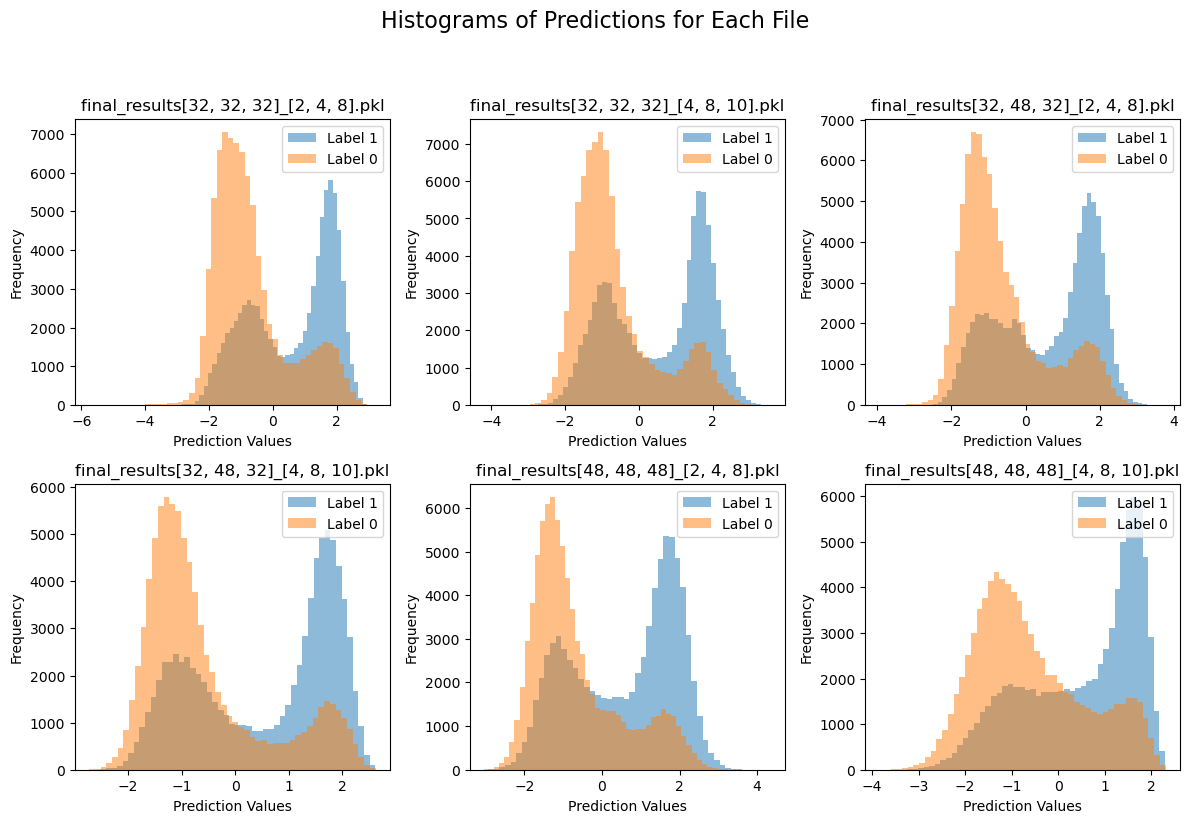

In [80]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# List of file names to load
pkl_files = [
    'final_training_results/final_results[32, 32, 32]_[2, 4, 8].pkl',
    'final_training_results/final_results[32, 32, 32]_[4, 8, 10].pkl',
    'final_training_results/final_results[32, 48, 32]_[2, 4, 8].pkl',
    'final_training_results/final_results[32, 48, 32]_[4, 8, 10].pkl',
    'final_training_results/final_results[48, 48, 48]_[2, 4, 8].pkl',
    'final_training_results/final_results[48, 48, 48]_[4, 8, 10].pkl'
]

fig, axs = plt.subplots(3, 3, figsize=(12, 12))  
fig.suptitle('Histograms of Predictions for Each Model', fontsize=16)

axs = axs.flatten()

# Process each pkl file and plot histograms 
def process_pkl_file(file_path, ax):
    with open(file_path, 'rb') as f:
        model_data = pickle.load(f)

    predictions_train = np.concatenate(model_data['predictions_train'])
    ground_truths_train = np.concatenate(model_data['ground_truths_train'])

    predictions_0 = predictions_train[ground_truths_train == 0]
    predictions_1 = predictions_train[ground_truths_train == 1]

    predictions_1_flat = predictions_1.flatten()
    predictions_0_flat = predictions_0.flatten()

    ax.hist(predictions_1_flat, bins=50, alpha=0.5, label='Label 1')
    ax.hist(predictions_0_flat, bins=50, alpha=0.5, label='Label 0')

    ax.set_xlabel('Prediction Values')
    ax.set_ylabel('Frequency')
    ax.legend(loc='upper right')
    ax.set_title(f'{file_path.split("/")[-1]}')

for i, file in enumerate(pkl_files):
    process_pkl_file(file, axs[i])

for j in range(len(pkl_files), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()


C:\Users\Angela\AppData\Local\Temp\ipykernel_170540\160961075.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_loader = torch.load('saved_loaders_bs32/test_loader.p

AUC for final_training_results/final_state[32, 32, 32]_[2, 4, 8].pt: 0.65


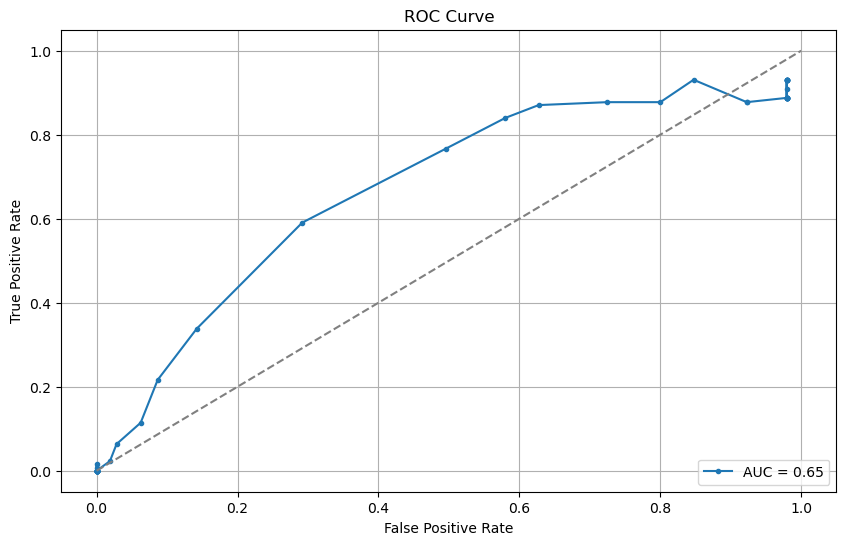

C:\Users\Angela\AppData\Local\Temp\ipykernel_170540\160961075.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_path, map_location

AUC for final_training_results/final_state[32, 32, 32]_[4, 8, 10].pt: 0.66


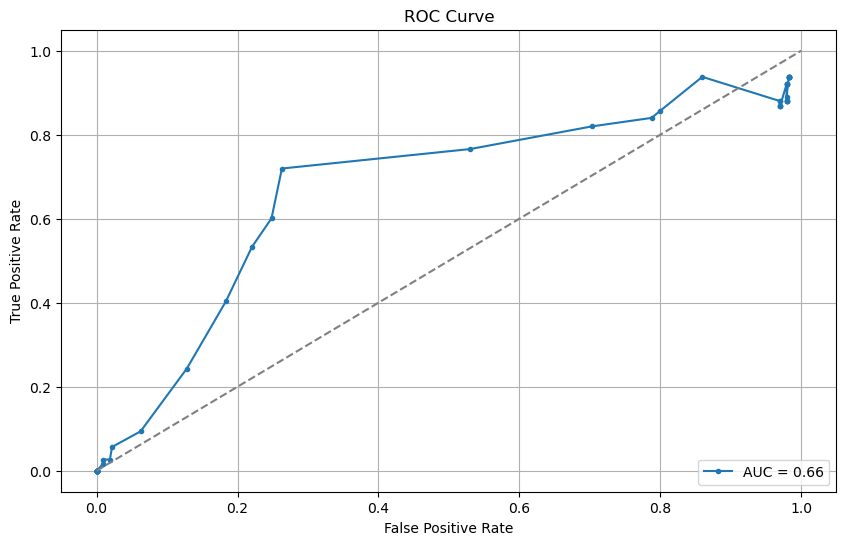

C:\Users\Angela\AppData\Local\Temp\ipykernel_170540\160961075.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_path, map_location

AUC for final_training_results/final_state[32, 48, 32]_[2, 4, 8].pt: 0.70


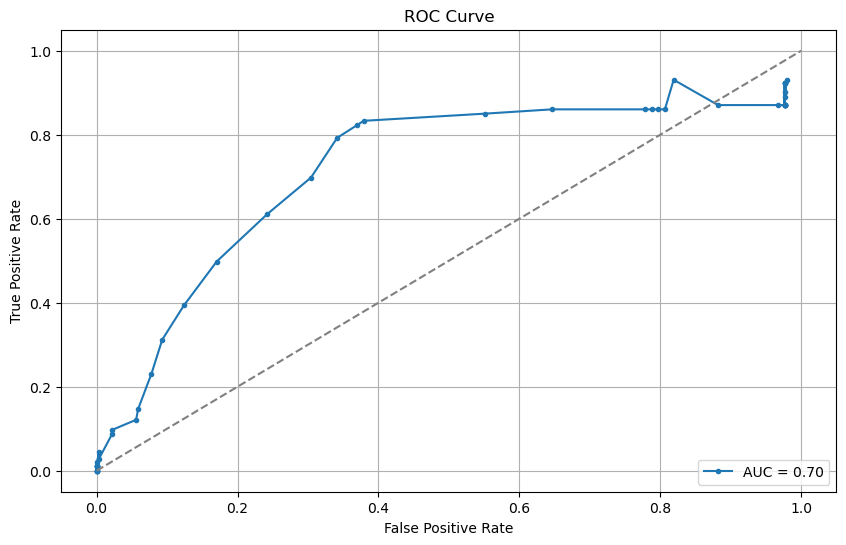

C:\Users\Angela\AppData\Local\Temp\ipykernel_170540\160961075.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_path, map_location

AUC for final_training_results/final_state[32, 48, 32]_[4, 8, 10].pt: 0.61


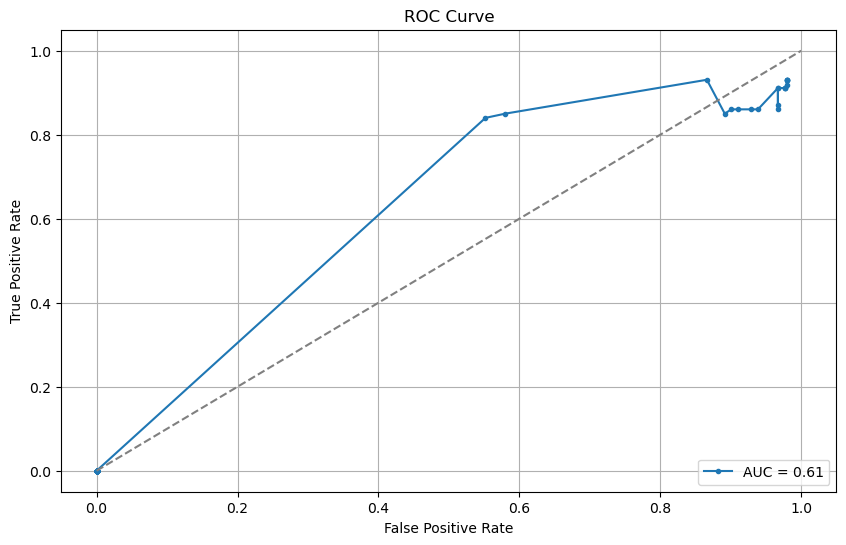

C:\Users\Angela\AppData\Local\Temp\ipykernel_170540\160961075.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_path, map_location

AUC for final_training_results/final_state[48, 48, 48]_[2, 4, 8].pt: 0.70


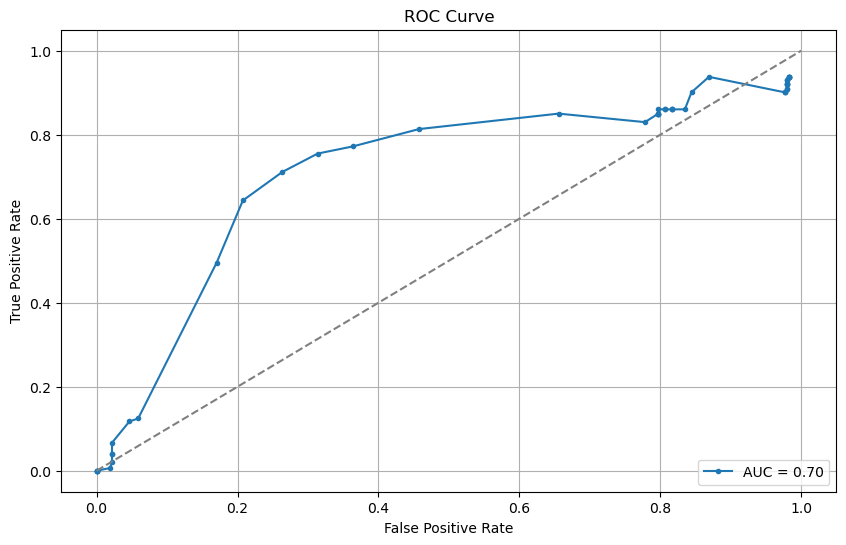

C:\Users\Angela\AppData\Local\Temp\ipykernel_170540\160961075.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_path, map_location

AUC for final_training_results/final_state[48, 48, 48]_[4, 8, 10].pt: 0.64


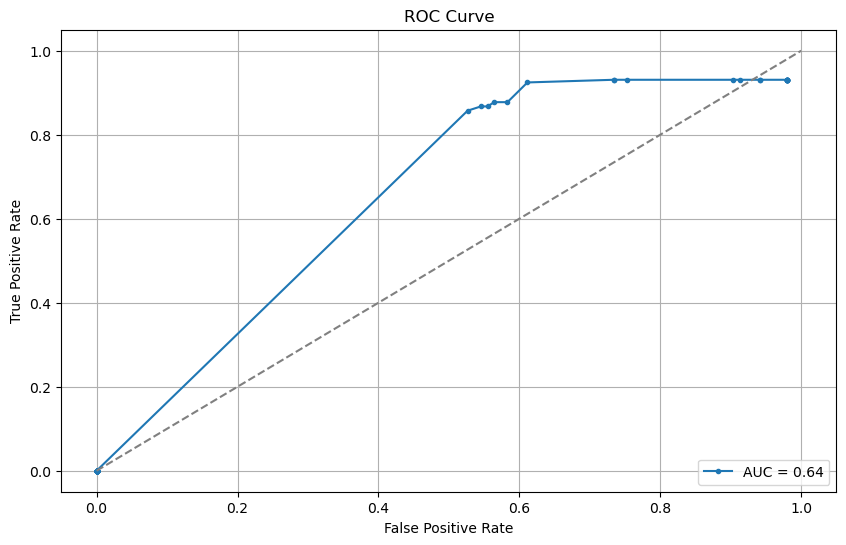

In [83]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from rockpool.nn.networks import SynNet

device = torch.device("cpu")

# List of model state paths and their corresponding parameters
model_configs = [
    {'state_path': 'final_training_results/final_state[32, 32, 32]_[2, 4, 8].pt', 'size_hidden_layers': [32, 32, 32], 'time_constants': [2, 4, 8]},
    {'state_path': 'final_training_results/final_state[32, 32, 32]_[4, 8, 10].pt', 'size_hidden_layers': [32, 32, 32], 'time_constants': [4, 8, 10]},
    {'state_path': 'final_training_results/final_state[32, 48, 32]_[2, 4, 8].pt', 'size_hidden_layers': [32, 48, 32], 'time_constants': [2, 4, 8]},
    {'state_path': 'final_training_results/final_state[32, 48, 32]_[4, 8, 10].pt', 'size_hidden_layers': [32, 48, 32], 'time_constants': [4, 8, 10]},
    {'state_path': 'final_training_results/final_state[48, 48, 48]_[2, 4, 8].pt', 'size_hidden_layers': [48, 48, 48], 'time_constants': [2, 4, 8]},
    {'state_path': 'final_training_results/final_state[48, 48, 48]_[4, 8, 10].pt', 'size_hidden_layers': [48, 48, 48], 'time_constants': [4, 8, 10]}
]

# Load the test loader once
test_loader = torch.load('saved_loaders_bs32/test_loader.pth')

# Function to plot the ROC curve and calculate AUC
def plot_roc_curve(model, test_loader, threshold_vals):
    TPRs = []
    FPRs = []

    model.output = 'spike'

    for th in threshold_vals:
        model.seq[-1].threshold = torch.tensor(th, dtype=torch.float32).to(device)

        true_positive = 0
        false_positive = 0
        true_negative = 0
        false_negative = 0

        for inputs, labels in test_loader:
            inputs = inputs.permute(0, 2, 1).to(device)
            labels = labels.to(device)

            outputs, _, _ = model(inputs, record=True)
            outputs_sum = outputs.sum(dim=1).detach().cpu().numpy()

            # Binary prediction based on summed spiking activity
            predictions = (outputs_sum > 0).astype(int)

            true_positive += ((predictions == 1) & (labels.cpu().numpy() == 1)).sum()
            false_positive += ((predictions == 1) & (labels.cpu().numpy() == 0)).sum()
            true_negative += ((predictions == 0) & (labels.cpu().numpy() == 0)).sum()
            false_negative += ((predictions == 0) & (labels.cpu().numpy() == 1)).sum()

        # Calculate TPR and FPR for the current threshold
        TPR = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0.0
        FPR = false_positive / (false_positive + true_negative) if (false_positive + true_negative) > 0 else 0.0

        TPRs.append(TPR)
        FPRs.append(FPR)

    # Sort the FPRs and TPRs together
    sorted_indices = np.argsort(FPRs)
    FPRs_sorted = np.array(FPRs)[sorted_indices]
    TPRs_sorted = np.array(TPRs)[sorted_indices]

    # Calculate the AUC using the sorted values
    auc_value = auc(FPRs_sorted, TPRs_sorted)

    # Plot ROC Curve
    plt.plot(FPRs_sorted, TPRs_sorted, marker='.', label=f'AUC = {auc_value:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()

    return auc_value

# Loop through each model configuration
for config in model_configs:
    state_path = config['state_path']
    size_hidden_layers = config['size_hidden_layers']
    time_constants = config['time_constants']

    # Load the model with the specified parameters
    model = SynNet(
        output="vmem",
        n_channels=16,
        n_classes=1,
        dt=10e-3,
        size_hidden_layers=size_hidden_layers,
        time_constants_per_layer=time_constants,
        tau_syn_base=0.02,
        tau_mem=0.02,
        tau_syn_out=0.02,
        train_threshold=True,
        p_dropout=0.2
    ).to(device)

    model.load_state_dict(torch.load(state_path, map_location=device))
    model.to(device)
    model.reset_state()
    model.eval()

    # Plot ROC curve for this model
    plt.figure(figsize=(10, 6))
    threshold_vals = np.arange(0.1, 5.0, 0.1)
    auc_value = plot_roc_curve(model, test_loader, threshold_vals)

    print(f"AUC for {state_path}: {auc_value:.2f}")
    plt.show()
